We investigate the velocity distribution, considering the relation of the floe velocities to the Normal distribution. Initially, we examine the velocity distribution using the full set of measurements, then examine the effects of local sea ice concentration, distance to the sea ice edge, floe size, and time of year.

A key question not really asked by the reviewers but important for us is the question of whether the mean flow is adequately addressed. The ideal thing to do would be to look at the centered 5-day average with the IFT dataset but we don't really have enough data for that. Using the NSIDC data as a reference for the mean flow field is not perfect, as the resolution is not the highest and we've got variation in time of how much buoy data is available. 

## Updating the analysis
When we talk about velocity anomalies, there is the question of trying to remove the mean flow. What is the mean flow in this case? Would it work to use 5-day net displacement, as with the simulation study?

* Can we make a simple comparison to IABP data in this case? I think a really neat analysis would be to show a distribution from IABP buoys, even a small set of them, account for at least monthly differences and maybe north / south and interior / edge differences. Then, we can see if the IFT data falls into the same distribution.
* Then, we can look at how within each of these categories, the IFT data can be subdivided by the ice floe size.


In [1]:
import itertools
import numpy as np
import pandas as pd
import ultraplot as pplt
import os
import sys
import warnings

sys.path.append('../scripts/')
from drifter import compute_along_across_components
from scipy.interpolate import interp2d
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

df_ift = pd.read_csv('../data/floe_tracker/ift_floe_trajectories.csv', index_col=0)
df_ift['datetime'] = pd.to_datetime(df_ift['datetime'].values)

# Calculations
# Length scale bins need area adjustment
df_ift['area_adj_km2'] = (np.sqrt(df_ift.area) + 6)**2*.25*.25 # 6 pixel shift minimizes error against manual

edge_bins = np.arange(0, 800, 25)
df_ift['edge_bin'] = np.digitize(df_ift.edge_dist_km, bins=edge_bins)

length_bins = np.arange(0, 50, 2)
df_ift['length_scale'] = df_ift['area_adj_km2']**0.5
df_ift['length_bin'] = np.digitize(df_ift.length_scale, bins=length_bins)

In [2]:
# Additional filter
speed = df_ift['speed'].copy()
print('Anomalous speed n =', len(speed[speed > 1.5]))
mean_u = df_ift.loc[:, 'u'].mean()
mean_v = df_ift.loc[:, 'v'].mean()

z = np.sqrt((df_ift.u - mean_u)**2 + (df_ift.v - mean_v)**2)/np.std(speed)
df_ift['qc_flag'] = 0
df_ift.loc[np.abs(z) > 6, 'qc_flag'] = 1
df_filtered = df_ift.loc[df_ift.qc_flag==0]
print('Flagged: ', df_ift.qc_flag.sum())

Anomalous speed n = 0
Flagged:  0


In [8]:
df_ift.columns

Index(['datetime', 'floe_id', 'longitude', 'latitude', 'x_stere', 'y_stere',
       'area', 'perimeter', 'axis_major_length', 'axis_minor_length',
       'solidity', 'circularity', 'nsidc_sic', 'lr_probability', 'zeta',
       'zeta_est', 'u', 'v', 'bearing', 'speed', 'area_km2', 'perimeter_km',
       'axis_major_length_km', 'axis_minor_length_km', 'edge_dist_km',
       'coast_dist_km', 'u_nsidc', 'v_nsidc', 'u5D_nsidc', 'v5D_nsidc',
       'u15D_nsidc', 'v15D_nsidc', 'u31D_nsidc', 'v31D_nsidc', 'area_adj_km2',
       'edge_bin', 'length_scale', 'length_bin', 'qc_flag'],
      dtype='object')

In [16]:
df_ift_longer = df_ift.groupby('floe_id').filter(lambda group: group.datetime.max() - group.datetime.min() >= pd.to_timedelta(5, 'd'))

In [65]:
# Select 5-day range for each floe
# Then compute the net displacement over a 5 day window
# Each track should have daily data if it was available
df_updated = []
for floe_id, group in df_ift_longer.groupby('floe_id'):
    idx0 = group.index.values[0]
    idx1 = group.index.values[5]
    if group.datetime[idx1] - group.datetime[idx0] >= pd.to_timedelta(5, 'd'):  
        dx = group.loc[idx1, 'x_stere'] - group.loc[idx0, 'x_stere']
        dy = group.loc[idx1, 'y_stere'] - group.loc[idx0, 'y_stere']
        dt = (group.datetime.max() - group.datetime.min()).total_seconds()
        group['u_5D_ift'] = dx/dt
        group['v_5D_ift'] = dy/dt
        df_updated.append(group.loc[idx0:idx1, :].copy())
df_updated = pd.concat(df_updated)

In [73]:
df_updated['u_anom'] = df_updated['u'] - df_updated['u_5D_ift']
df_updated['v_anom'] = df_updated['v'] - df_updated['v_5D_ift']

In [53]:
mean_loc.loc[mean_loc.datetime.dt.month == 5]

datetime  longitude   latitude        x_stere  \
floe_id                                                               
2003_01819 2003-05-01 12:00:00 -18.665116  71.991192  872294.969160   
2003_01830 2003-05-01 12:00:00 -17.202808  72.542260  888470.087970   
2003_01855 2003-05-01 12:00:00 -19.720412  71.998246  839379.737728   
2003_01859 2003-05-01 12:00:00 -14.826192  74.689238  838330.873432   
2003_01860 2003-05-01 12:00:00 -20.335448  72.618930  791508.241050   
...                        ...        ...        ...            ...   
2020_06082 2020-05-08 12:00:00 -19.731758  72.899318  796441.948352   
2020_06098 2020-05-08 12:00:00 -15.770938  72.390304  938548.804886   
2020_06101 2020-05-08 12:00:00 -16.944796  74.010098  819669.668560   
2020_06248 2020-05-09 12:00:00 -15.846926  72.617800  924075.942090   
2020_06409 2020-05-11 12:00:00 -18.101204  71.333728  922580.817572   

                 y_stere         area   perimeter  axis_major_length  \
floe_id                                                                
2003_01819 -1.762358e+06  1305.346482  153.412678          58.315102   
2003_01830 -1.685487e+06   830.805112  115.421356          40.487194   
2003_01855 -1.777405e+06  1966.448400  171.128960          52.871362   
2003_01859 -1.442133e+06   719.138924  112.549440          44.109474   
2003_01860 -1.723794e+06   701.226364  107.269858          39.800092   
...                  ...          ...         ...                ...   
2020_06082 -1.687256e+06  1405.565610  161.446162          61.692572   
2020_06098 -1.677436e+06   921.290388  130.442358          43.031492   
2020_06101 -1.538230e+06   834.582096  114.524712          35.593790   
2020_06248 -1.656669e+06   847.697468  128.673828          43.553284   
2020_06409 -1.818789e+06  1575.421330  186.256902          75.735592   

            axis_minor_length  solidity  ...  v5D_nsidc  u15D_nsidc  \
floe_id                                  ...                          
2003_01819          29.278146  0.919818  ...  -0.122400   -0.044400   
2003_01830          26.969380  0.933670  ...  -0.129600   -0.056200   
2003_01855          48.294500  0.953728  ...  -0.100400   -0.028200   
2003_01859          21.318098  0.916220  ...  -0.128600   -0.066800   
2003_01860          23.222242  0.922420  ...  -0.055333   -0.021333   
...                       ...       ...  ...        ...         ...   
2020_06082          29.698508  0.921622  ...  -0.073400   -0.020600   
2020_06098          29.961244  0.883828  ...  -0.101400   -0.026400   
2020_06101          30.983404  0.937482  ...  -0.142600   -0.033200   
2020_06248          27.795400  0.877822  ...  -0.120800   -0.027200   
2020_06409          28.196756  0.868290  ...  -0.085800   -0.010000   

            v15D_nsidc  u31D_nsidc  v31D_nsidc  area_adj_km2  edge_bin  \
floe_id                                                                  
2003_01819   -0.114000   -0.026600   -0.083800    110.929909       7.4   
2003_01830   -0.110200   -0.032000   -0.078400     75.791636       8.4   
2003_01855   -0.099600   -0.015400   -0.074600    158.410328       8.4   
2003_01859   -0.109200   -0.047600   -0.084800     67.307546       6.6   
2003_01860   -0.059333   -0.009333   -0.043333     65.935458      11.2   
...                ...         ...         ...           ...       ...   
2020_06082   -0.088200   -0.011400   -0.059000    118.204371      11.2   
2020_06098   -0.104000   -0.015200   -0.066800     82.594439       6.0   
2020_06101   -0.126800   -0.022200   -0.078800     76.077489      12.2   
2020_06248   -0.113000   -0.017200   -0.070000     77.060590       6.8   
2020_06409   -0.064000   -0.009000   -0.044600    130.479003       5.8   

            length_scale  length_bin  qc_flag  
floe_id                                        
2003_01819     10.531918         6.0      0.0  
2003_01830      8.705439         5.0      0.0  
2003_01855     12.585768         7.0      0.0  
2003_01859      8.203788         5

# Check for errors
- THere's no reason there should be the same number of floes in each month. This likely shows something gone wrong.

4 684
5 710
6 722


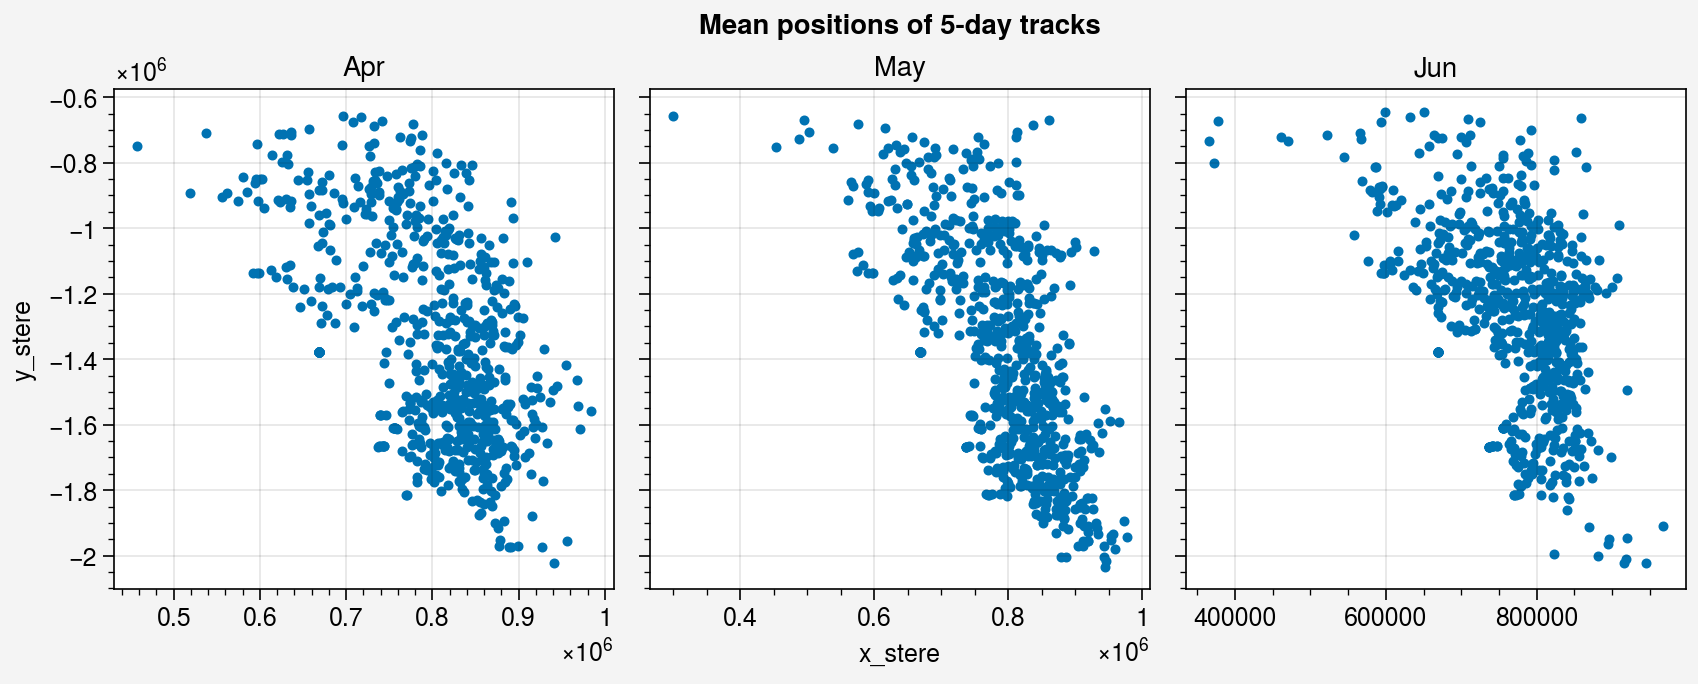

In [58]:
mean_loc = df_updated.groupby('floe_id').mean()
months = {4: 'Apr', 5: 'May', 6: 'Jun'}
fig, axs = pplt.subplots(ncols=3)
for ax, month in zip(axs, [4, 5, 6]):
    idx = mean_loc.datetime.dt.month == month
    print(month, len(mean_loc.x_stere[idx]))
    ax.scatter(mean_loc.x_stere[idx], mean_loc.y_stere[idx], marker='.')
    ax.format(title = months[month], suptitle='Mean positions of 5-day tracks')

# To do:
Try plotting some typical trajectories and look at the net displacement vs the travel.

In [148]:
# Drop these - it's all the same spots!
df_updated.loc[np.abs(df_updated.u_5D_ift) < 1e-6, :].groupby('floe_id').mean()

datetime  longitude   latitude        x_stere       y_stere  \
floe_id                                                                    
2003_00442 2003-04-17 -19.126558  75.922022  668733.089268 -1.378827e+06   
2003_02593 2003-05-11 -19.127092  75.922905  668678.165158 -1.378745e+06   
2005_00952 2005-04-19 -19.127287  75.922900  668673.400000 -1.378748e+06   
2005_02388 2005-05-15 -19.127100  75.922900  668678.100000 -1.378746e+06   
2005_03460 2005-06-10 -19.127100  75.922900  668678.100000 -1.378746e+06   
2006_00998 2006-06-14 -19.127212  75.922835  668678.450998 -1.378753e+06   
2007_00350 2007-04-17 -19.127100  75.922900  668678.100000 -1.378746e+06   
2007_00983 2007-04-26 -19.127100  75.922900  668678.100000 -1.378746e+06   
2007_03130 2007-06-09 -19.127100  75.922900  668678.100000 -1.378746e+06   
2008_00044 2008-04-04 -19.127100  75.922900  668678.100000 -1.378746e+06   
2009_00016 2009-04-04 -19.127100  75.922900  668678.100000 -1.378746e+06   
2010_00100 2010-04-12 -19.126267  75.922842  668700.879688 -1.378742e+06   
2010_01071 2010-04-27 -19.127068  75.922900  668678.933990 -1.378746e+06   
2010_02847 2010-05-26 -19.127100  75.922900  668678.100000 -1.378746e+06   
2010_02991 2010-06-03 -21.161562  73.289140  736647.871678 -1.667175e+06   
2011_00184 2011-04-24 -19.127100  75.922900  668678.100000 -1.378746e+06   
2011_01755 2011-06-14 -19.126882  75.922853  668685.641082 -1.378748e+06   
2012_03401 2012-05-19 -19.127100  75.922900  668678.100000 -1.378746e+06   
2013_00566 2013-04-09 -19.127100  75.922900  668678.100000 -1.378746e+06   
2013_03819 2013-05-26 -19.127100  75.922900  668678.100000 -1.378746e+06   
2013_04259 2013-06-07 -19.127798  75.923168  668648.523510 -1.378728e+06   
2014_02565 2014-05-11 -19.127075  75.923020  668673.017522 -1.378734e+06   
2015_00432 2015-04-29 -19.127100  75.922900  668678.100000 -1.378746e+06   
2016_00021 2016-04-04 -19.127100  75.922900  668678.100000 -1.378746e+06   
2016_00541 2016-04-15 -19.127115  75.922853  668679.651663 -1.378750e+06   
2016_02361 2016-05-10 -19.127100  75.922900  668678.100000 -1.378746e+06   
2016_03508 2016-06-06 -19.127100  75.922900  668678.100000 -1.378746e+06   
2017_00044 2017-04-04 -19.127100  75.922900  668678.100000 -1.378746e+06   
2017_01741 2017-05-03 -19.127100  75.922900  668678.100000 -1.378746e+06   
2017_06459 2017-06-22 -22.587033  70.274610  822536.173707 -1.994339e+06   
2018_00219 2018-04-11 -19.127100  75.922900  668678.100000 -1.378746e+06   
2018_02076 2018-05-28 -19.127100  75.922900  668678.100000 -1.378746e+06   
2019_00016 2019-04-04 -19.127100  75.922900  668678.100000 -1.378746e+06   
2019_03052 2019-05-14 -19.127100  75.922900  668678.100000 -1.378746e+06   
2019_03664 2019-06-03 -19.127100  75.922900  668678.100000 -1.378746e+06   

                   area   perimeter  axis_major_length  axis_minor_length  \
floe_id                                                                     
2003_00442  1499.535937  187.242960          87.444338          22.948343   
2003_02593  1513.813833  189.851195          88.404655          23.000000   
2005_00952  1510.250000  190.162500          88.500000          22.975000   
2005_02388  1514.000000  189.800000          88.400000          23.000000   
2005_03460  1514.000000  189.800000          88.400000          23.000000   
2006_00998  1510.490028  190.071225          88.479773          22.968092   
2007_00350  1514.000000  189.800000          88.400000          23.000000   
2007_00983  1514.000000  189.800000          88.400000          23.000000   
2007_03130  1514.000000  189.800000          88.400000          23.000000   
2008_00044  1514.000000  189.800000          88.400000          23.000000   
2009_00016  1514.000000  189.800000          88.400000          23.000000   
2010_00100  1505.662337  190.395548          88.727550          22.821335   
2010_01071  1513.679233  189.992460          88.400000          23.000000   
2010_02847  1514.000000  189.800000          

<a list of 1 Line2D objects>

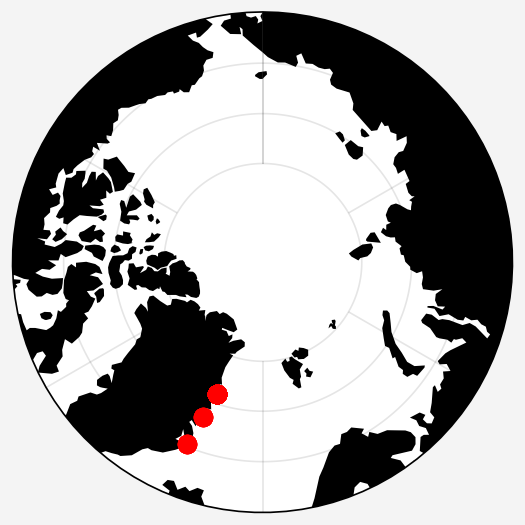

In [154]:
# Drop any with 0 displacement
fig, ax = pplt.subplots(proj='npstere')
ax.format(land=True, boundinglat=65)
ax.plot(df_updated.loc[np.abs(df_updated.u_5D_ift) < 1e-6, 'longitude'],
        df_updated.loc[np.abs(df_updated.u_5D_ift) < 1e-6, 'latitude'], marker='o', color='r', lw=0, zorder=10)

In [135]:
 df_updated.sample(1).floe_id

1987    2011_02604
Name: floe_id, dtype: object

This figure is a reminder that I need to wrap up the paper on the mesoscale eddies and absolute dispersion. When we compare the 5-day segments to the 5-day displacement, it's clear there is typically a curvature that could be ocean eddies. It would also explain, potentially, why I'm not seeing a centered distribution here. But then why would the NSIDC averaged data show a centered distribution? And what do we see with the drifting buoy data?

This is accidentially actually a really compelling figure, I think. I could show the floe shapes on top of these, colored by rotation. But this needs to be in the paper on the mesoscale eddies that I was supposed to finish ages ago - it should be separate from this JoG paper.

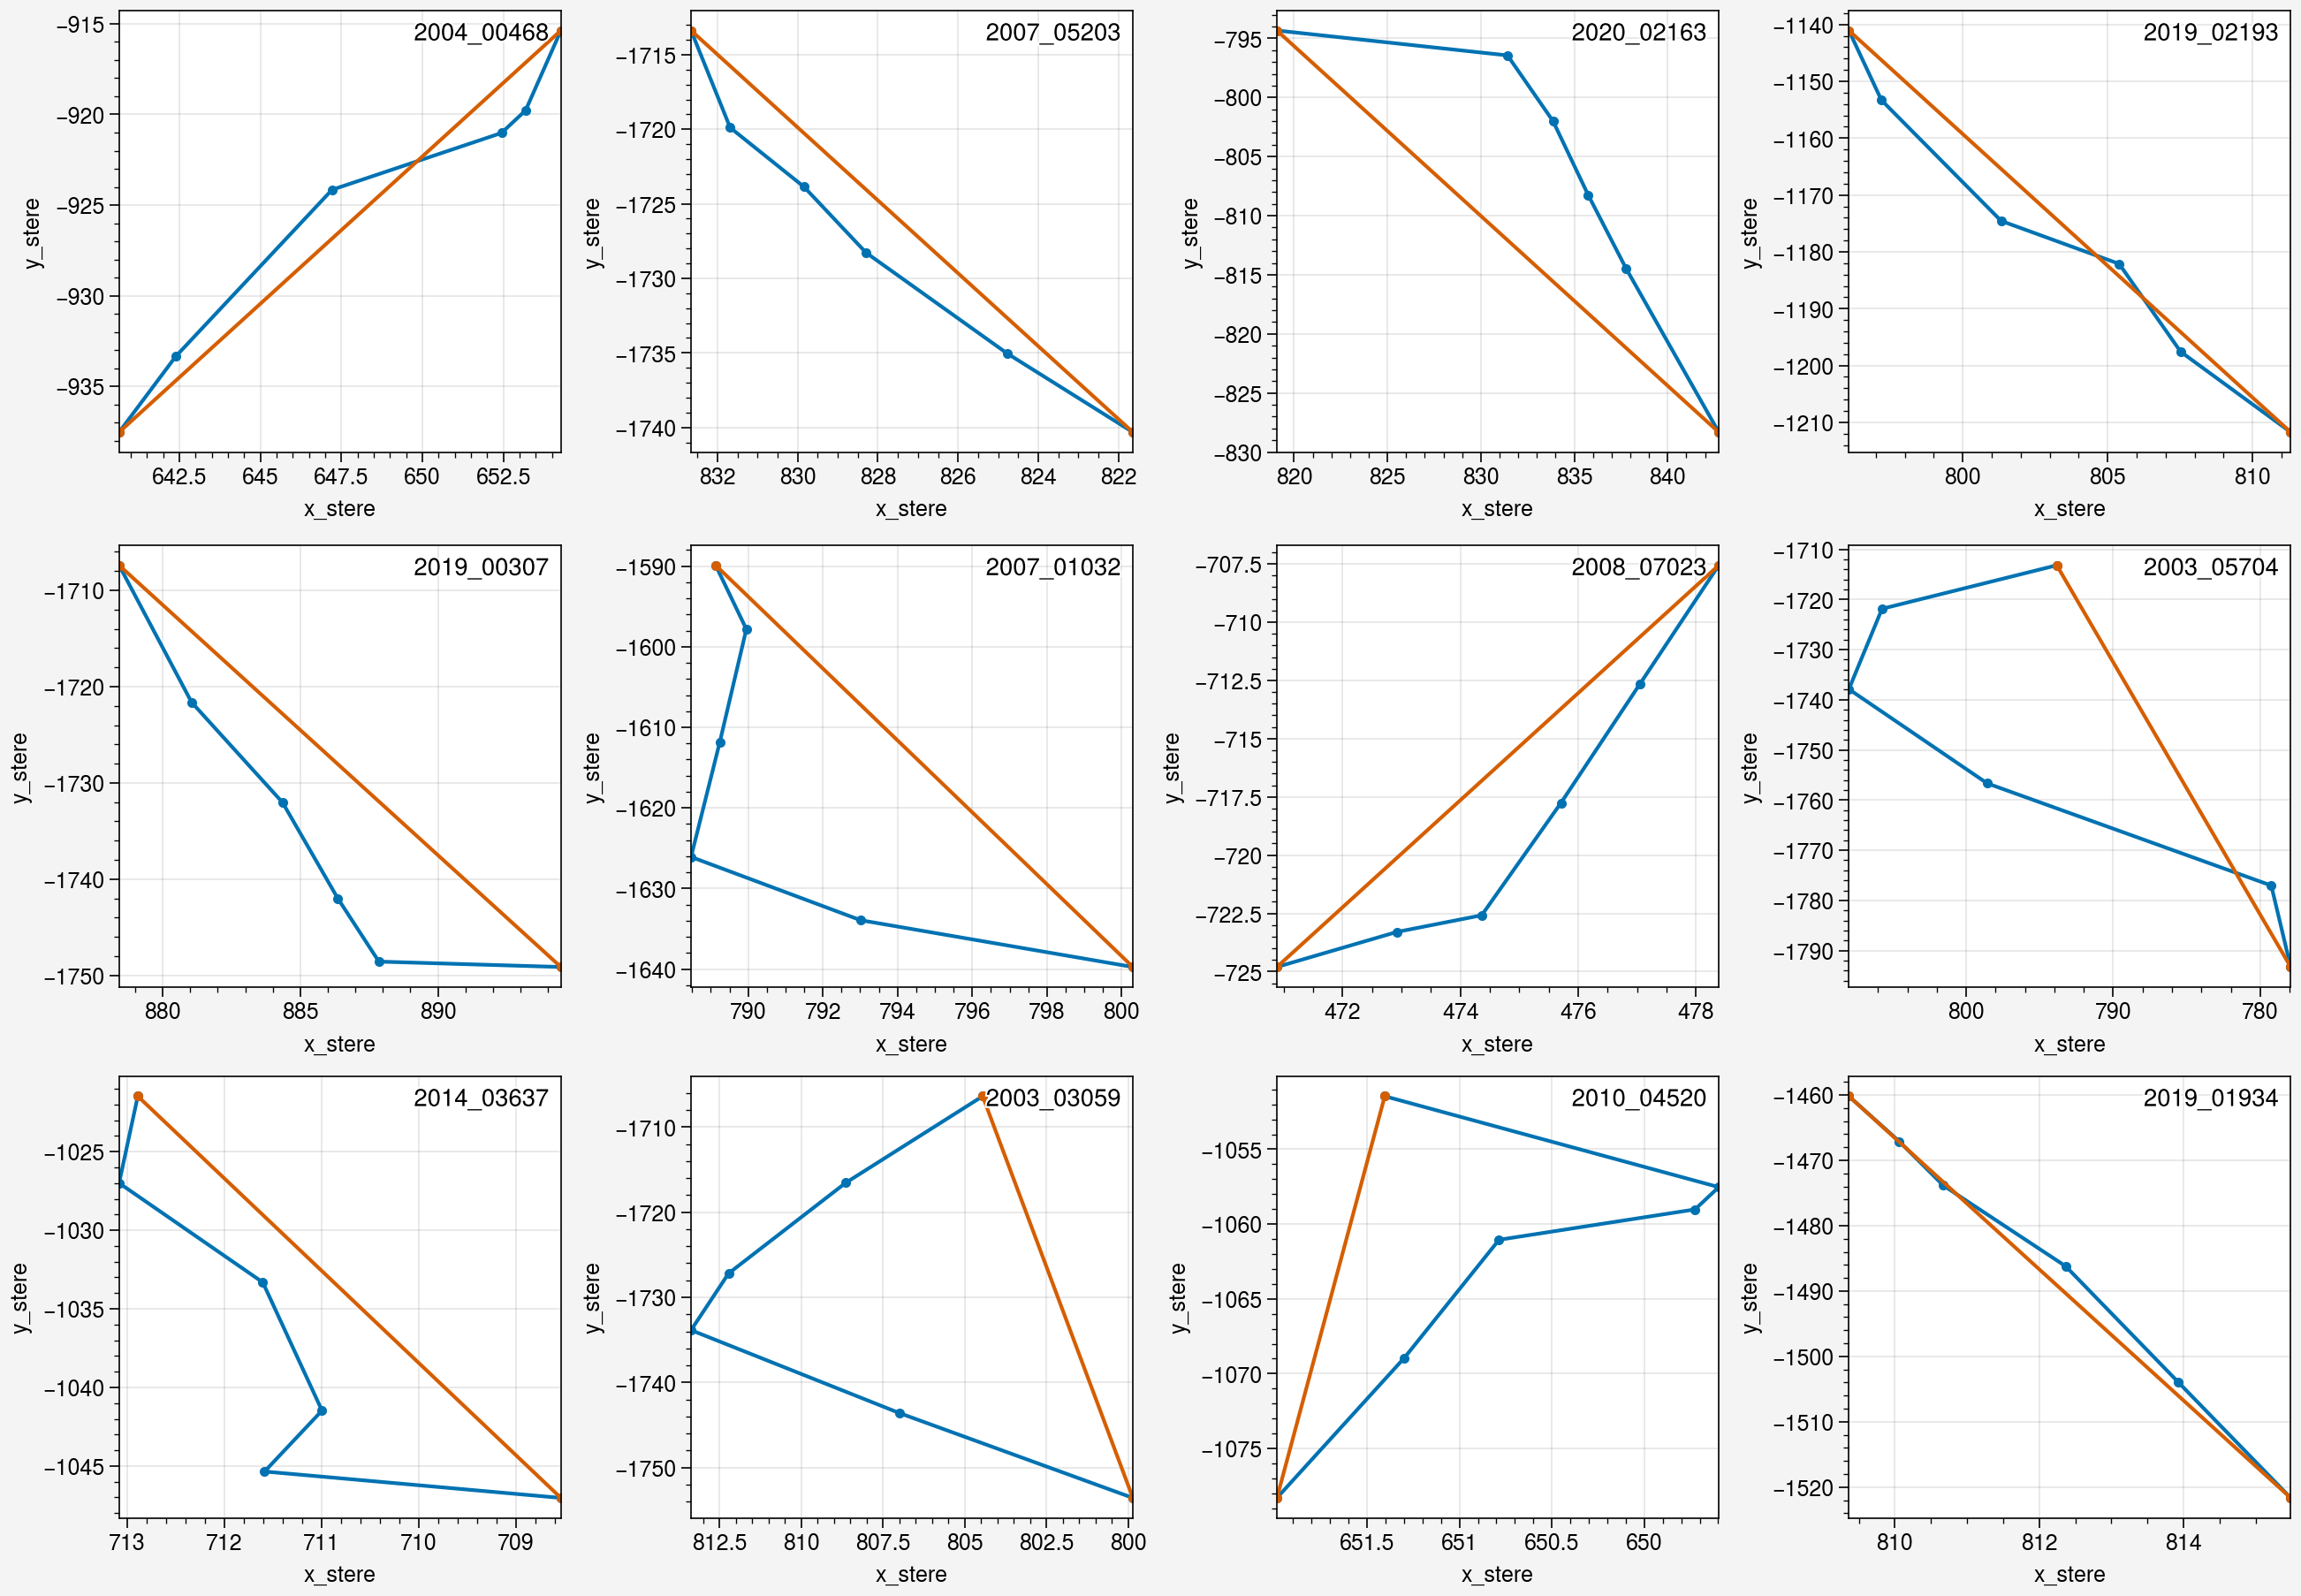

In [158]:
fig, axs = pplt.subplots(ncols=4, nrows=3, share=False)
for ax in axs:
    f_id = df_updated.sample(1).floe_id.values[0]
    df_test = df_updated.loc[df_updated.floe_id == f_id]
    
    ax.plot(df_test.x_stere/1e3, df_test.y_stere/1e3, marker='.')
    ax.plot([df_test.x_stere.values[0]/1e3, df_test.x_stere.values[-1]/1e3],
            [df_test.y_stere.values[0]/1e3, df_test.y_stere.values[-1]/1e3], marker='.')
    ax.format(urtitle=f_id)

In [159]:
df_updated = compute_along_across_components(df_updated, uvar='u_anom', vvar='v_anom',
                                umean='u_5D_ift',
                                vmean='v_5D_ift') 
df_updated.columns

Index(['datetime', 'floe_id', 'longitude', 'latitude', 'x_stere', 'y_stere',
       'area', 'perimeter', 'axis_major_length', 'axis_minor_length',
       'solidity', 'circularity', 'nsidc_sic', 'lr_probability', 'zeta',
       'zeta_est', 'u', 'v', 'bearing', 'speed', 'area_km2', 'perimeter_km',
       'axis_major_length_km', 'axis_minor_length_km', 'edge_dist_km',
       'coast_dist_km', 'u_nsidc', 'v_nsidc', 'u5D_nsidc', 'v5D_nsidc',
       'u15D_nsidc', 'v15D_nsidc', 'u31D_nsidc', 'v31D_nsidc', 'area_adj_km2',
       'edge_bin', 'length_scale', 'length_bin', 'qc_flag', 'u_5D_ift',
       'v_5D_ift', 'u_along', 'v_along', 'u_across', 'v_across',
       'U_fluctuating', 'U_along', 'u_anom', 'v_anom', 'u_anom_along',
       'v_anom_along', 'u_anom_across', 'v_anom_across'],
      dtype='object')

(array([5.000e+00, 1.500e+01, 5.900e+01, 5.130e+02, 4.856e+03, 6.952e+03,
        4.240e+02, 8.100e+01, 1.100e+01, 5.000e+00]),
 array([-0.38185733, -0.3102901 , -0.23872288, -0.16715565, -0.09558842,
        -0.02402119,  0.04754604,  0.11911327,  0.1906805 ,  0.26224772,
         0.33381495]),
 <BarContainer object of 10 artists>)

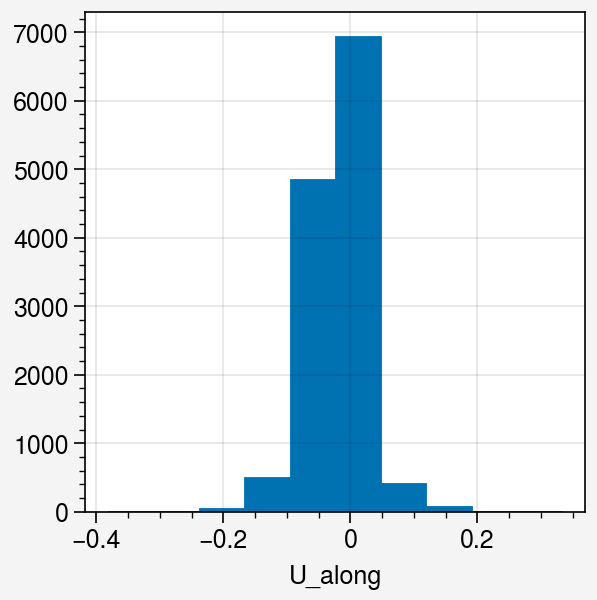

In [91]:
fig, ax = pplt.subplots()
ax.hist(df_updated.U_along)

12921
0.04331430014732919
0.057964170408462995


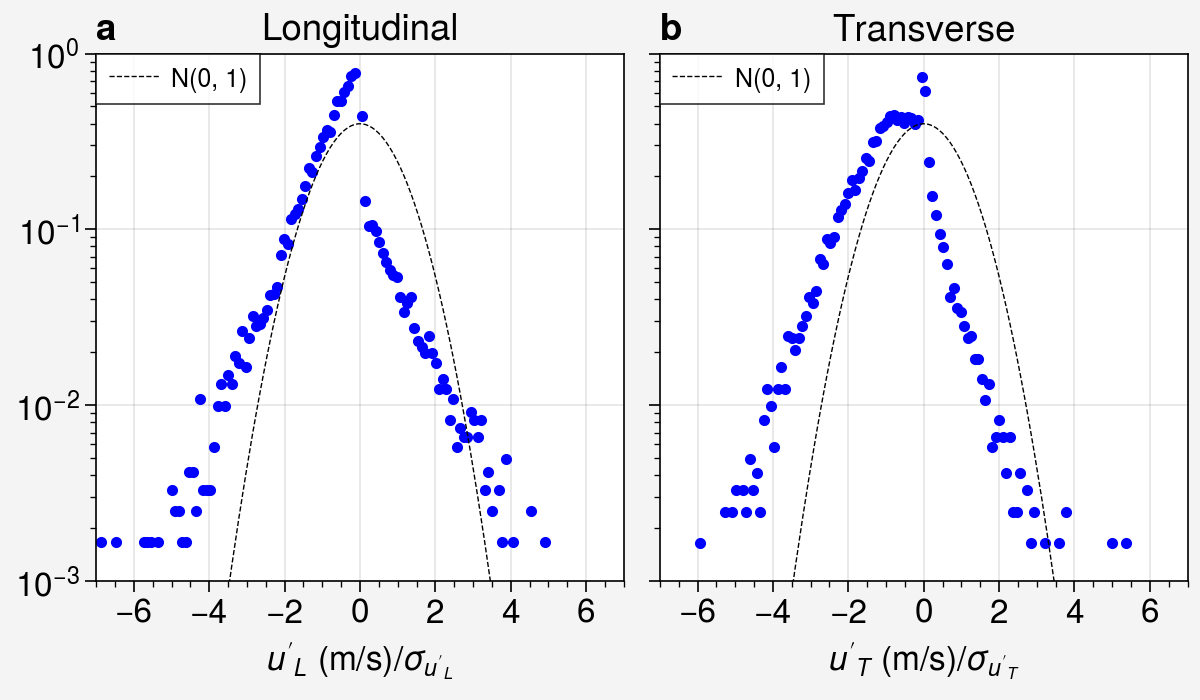

In [92]:
data_df = df_updated.copy()
vel_comp1 = 'U_along'
vel_comp2 = 'U_fluctuating'
vc1_name = 'Longitudinal'
vc2_name = 'Transverse'
all_u = data_df[vel_comp1].dropna()
all_v = data_df[vel_comp2].dropna()
print(len(all_u))
fig, axs = pplt.subplots(ncols=2, width=6, sharex=False)
normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)
for ax, data in zip(axs, [all_u, all_v]):
    pdf, x_bins = np.histogram(data/np.std(data), bins=np.linspace(-7, 7, 151), density=True)
    x_center = 1/2*(x_bins[1:] + x_bins[:-1])
    print(np.std(data))
    ax.plot(x_center, pdf, marker='.', lw=0, color='b') 
    ax.plot(x_center, normal_dist(x_center), marker='', lw=0.5, color='k', ls='--', label='N(0, 1)')
axs[0].format(title=vc1_name, xlabel='$u\'_L$ (m/s)/$\sigma_{u\'_L}$')
axs[1].format(title=vc2_name, xlabel='$u\'_T$ (m/s)/$\sigma_{u\'_T}$')
axs[0].legend(loc='ul', ncols=1)
axs[1].legend(loc='ul', ncols=1)
axs.format(yscale='log', ylim=(1e-3, 1), xlim=(-7, 7),
           yformatter='log', suptitle='', fontsize=12, abc=True)


So the question is: why is this so lopsided? Is it the case that the 5D net displacement is not a good choice? It could be that, but could it also reflect curvature in the trajectories? Rosalinda found some significant and interesting differences in the curvature for tracks following the wind and tracks that didn't follow the wind.

Another question: how can I situate the motion data with the FSD data? Can I identify local patterns here?

12921


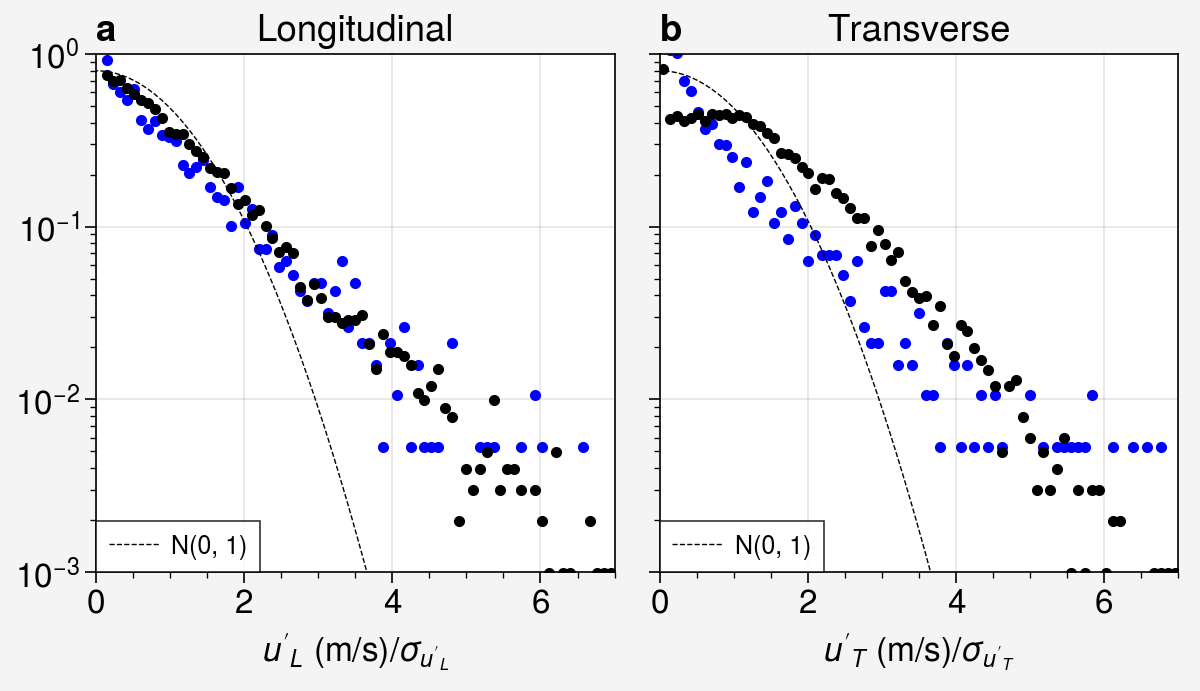

In [185]:
data_df = df_updated.copy()
vel_comp1 = 'U_along'
vel_comp2 = 'U_fluctuating'
vc1_name = 'Longitudinal'
vc2_name = 'Transverse'
all_u = data_df[vel_comp1].dropna()
all_v = data_df[vel_comp2].dropna()
print(len(all_u))
fig, axs = pplt.subplots(ncols=2, width=6, sharex=False)
normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)
for ax, data in zip(axs, [all_u, all_v]):
    pos_data = data[data > 0]
    pdf, x_bins = np.histogram(pos_data/np.std(pos_data), bins=np.linspace(-7, 7, 151), density=True)
    x_center = 1/2*(x_bins[1:] + x_bins[:-1])
    ax.plot(x_center, pdf, marker='.', lw=0, color='b') 

    neg_data = np.abs(data[data < 0])
    pdf, x_bins = np.histogram(neg_data/np.std(neg_data), bins=np.linspace(-7, 7, 151), density=True)
    x_center = 1/2*(x_bins[1:] + x_bins[:-1])
    ax.plot(x_center, pdf, marker='.', lw=0, color='k')
    
    ax.plot(x_center, 2*normal_dist(x_center), marker='', lw=0.5, color='k', ls='--', label='N(0, 1)')
axs[0].format(title=vc1_name, xlabel='$u\'_L$ (m/s)/$\sigma_{u\'_L}$')
axs[1].format(title=vc2_name, xlabel='$u\'_T$ (m/s)/$\sigma_{u\'_T}$')
axs[0].legend(loc='ll', ncols=1)
axs[1].legend(loc='ll', ncols=1)
axs.format(yscale='log', ylim=(1e-3, 1), xlim=(0, 7),
           yformatter='log', suptitle='', fontsize=12, abc=True)


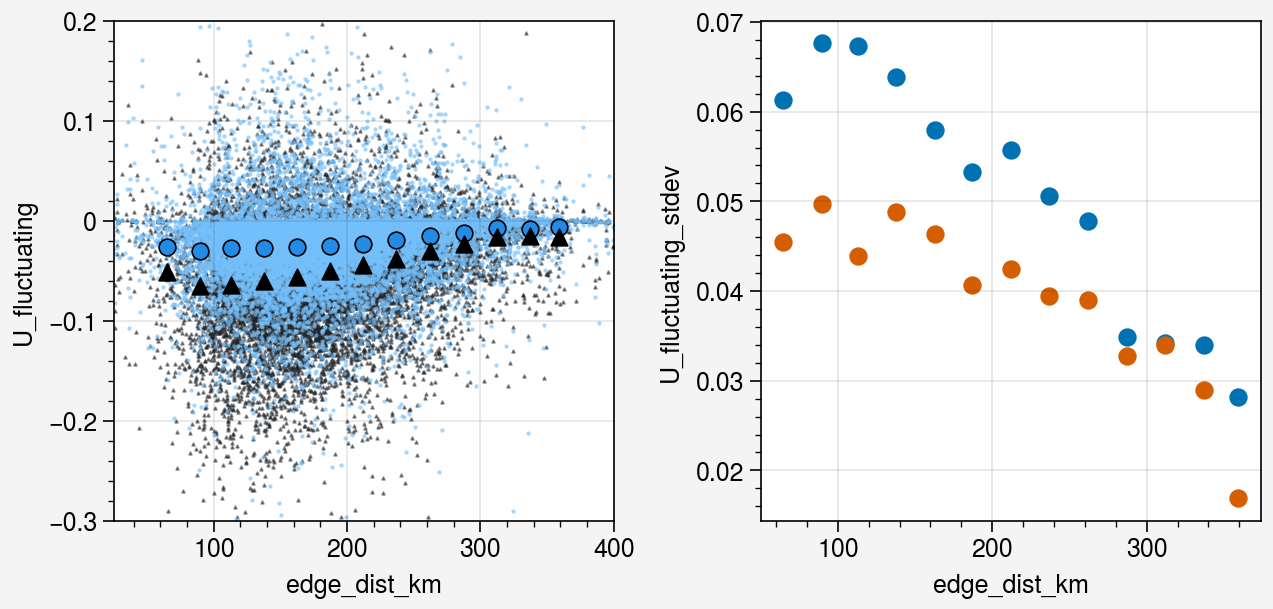

In [119]:
mean_bin = df_updated.loc[:, ['U_fluctuating', 'U_along', 'edge_bin', 'edge_dist_km']].groupby('edge_bin').mean()
std_bin = df_updated.loc[:, ['U_fluctuating', 'U_along', 'edge_bin', 'edge_dist_km']].groupby('edge_bin').std()
cnt_bin = df_updated.loc[:, ['U_fluctuating', 'U_along', 'edge_bin', 'edge_dist_km']].groupby('edge_bin').count()
std_bin.columns = [c+'_stdev' for c in std_bin.columns]
plot_df = pd.concat([mean_bin, std_bin], axis=1)
plot_df['counts'] = cnt_bin['edge_dist_km']
plot_df = plot_df.loc[plot_df.counts > 100]
fig, ax = pplt.subplots(ncols=2, share=False)

ax[0].scatter(df_updated.edge_dist_km, df_updated.U_fluctuating, color='gray9', marker='^', ms=1, alpha=0.5)
ax[0].scatter(df_updated.edge_dist_km, df_updated.U_along, color='blue3', marker='o', ms=1, alpha=0.5)
ax[0].scatter(plot_df.edge_dist_km, plot_df.U_along, color='blue6', marker='o', edgecolor='k')
ax[0].scatter(plot_df.edge_dist_km, plot_df.U_fluctuating, color='k', marker='^')

ax[1].scatter(plot_df.edge_dist_km, plot_df.U_fluctuating_stdev)
ax[1].scatter(plot_df.edge_dist_km, plot_df.U_along_stdev)
ax[0].format(ylim=(-0.3, 0.2), xlim=(25, 400))

(<ultraplot.legend.Legend at 0x323955090>,
 <ultraplot.legend.Legend at 0x3239ea850>)

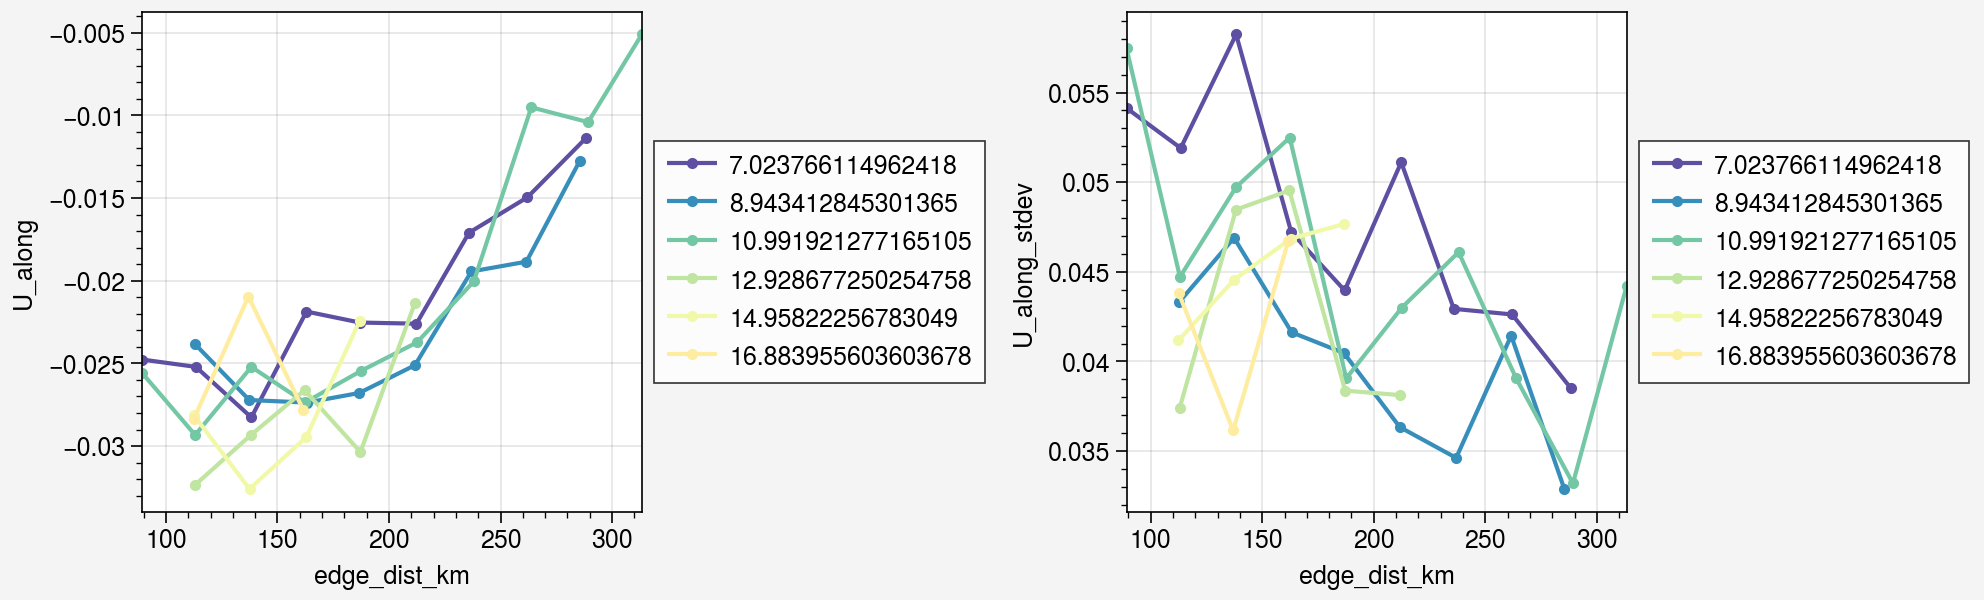

In [127]:
fig, ax = pplt.subplots(ncols=2, share=False)
for binnum, group in df_updated.groupby('length_bin'):
    mean_bin = group.loc[:, ['U_fluctuating', 'U_along', 'edge_bin', 'edge_dist_km']].groupby('edge_bin').mean()
    std_bin = group.loc[:, ['U_fluctuating', 'U_along', 'edge_bin', 'edge_dist_km']].groupby('edge_bin').std()
    cnt_bin = group.loc[:, ['U_fluctuating', 'U_along', 'edge_bin', 'edge_dist_km']].groupby('edge_bin').count()
    std_bin.columns = [c+'_stdev' for c in std_bin.columns]
    plot_df = pd.concat([mean_bin, std_bin], axis=1)
    plot_df['counts'] = cnt_bin['edge_dist_km']
    plot_df = plot_df.loc[plot_df.counts > 100]
    if len(plot_df) > 0:
        ax[0].plot(plot_df.edge_dist_km, plot_df.U_along, label=str(group.length_scale.mean()), marker='.', cycle='spectral_r')
    # ax[0].scatter(plot_df.edge_dist_km, plot_df.U_fluctuating)
    
    # ax[1].scatter(plot_df.edge_dist_km, plot_df.U_fluctuating_stdev)
        ax[1].plot(plot_df.edge_dist_km, plot_df.U_along_stdev, label=str(group.length_scale.mean()), marker='.', cycle='spectral_r')
    # ax[0].format(ylim=(-0.3, 0.2), xlim=(25, 400))
ax.legend(loc='r', ncols=1)

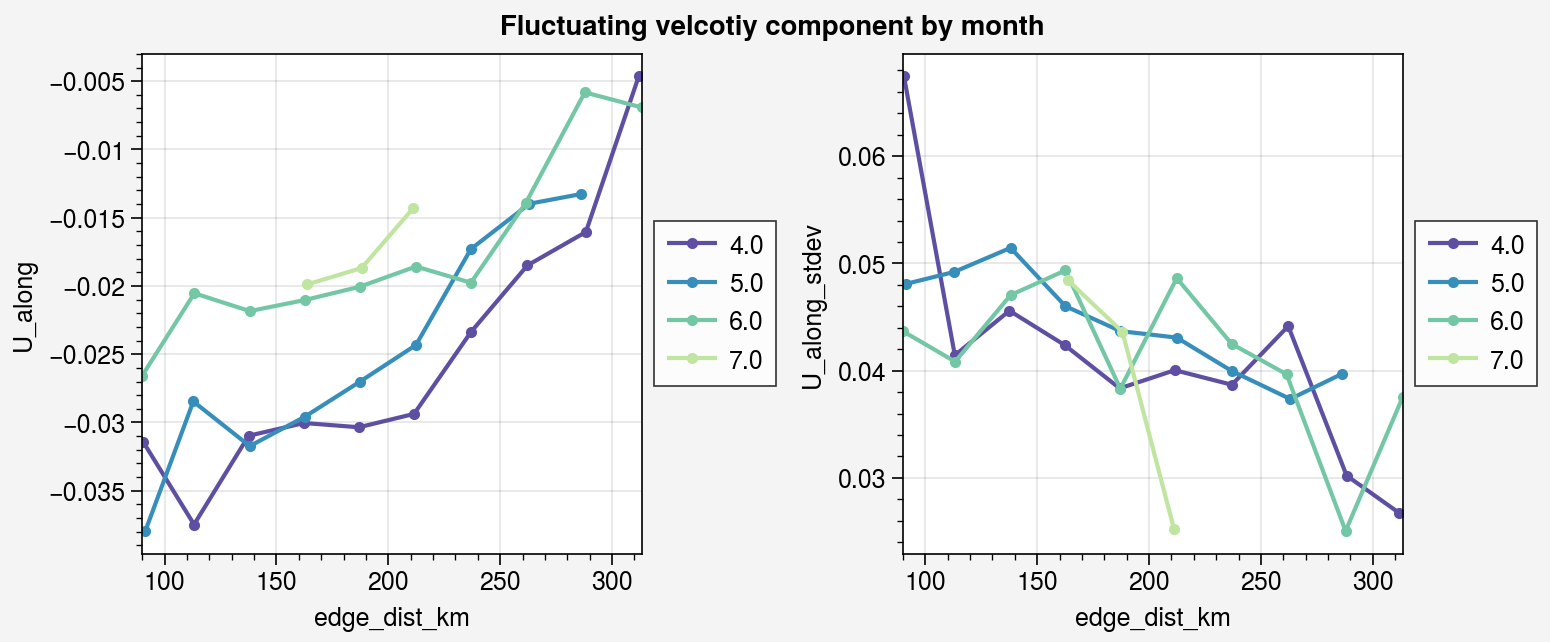

In [166]:
fig, ax = pplt.subplots(ncols=2, share=False)
for binnum, group in df_updated.groupby(df_updated.datetime.dt.month):
    mean_bin = group.loc[:, ['U_fluctuating', 'U_along', 'edge_bin', 'edge_dist_km']].groupby('edge_bin').mean()
    std_bin = group.loc[:, ['U_fluctuating', 'U_along', 'edge_bin', 'edge_dist_km']].groupby('edge_bin').std()
    cnt_bin = group.loc[:, ['U_fluctuating', 'U_along', 'edge_bin', 'edge_dist_km']].groupby('edge_bin').count()
    std_bin.columns = [c+'_stdev' for c in std_bin.columns]
    plot_df = pd.concat([mean_bin, std_bin], axis=1)
    plot_df['counts'] = cnt_bin['edge_dist_km']
    plot_df = plot_df.loc[plot_df.counts > 100]
    if len(plot_df) > 0:
        ax[0].plot(plot_df.edge_dist_km, plot_df.U_along, label=str(group.datetime.dt.month.mean()), marker='.', cycle='spectral_r')
    # ax[0].scatter(plot_df.edge_dist_km, plot_df.U_fluctuating)
    
    # ax[1].scatter(plot_df.edge_dist_km, plot_df.U_fluctuating_stdev)
        ax[1].plot(plot_df.edge_dist_km, plot_df.U_along_stdev, label=str(group.datetime.dt.month.mean()), marker='.', cycle='spectral_r')
    # ax[0].format(ylim=(-0.3, 0.2), xlim=(25, 400))
ax.legend(loc='r', ncols=1)
ax.format(suptitle='Fluctuating velcotiy component by month')

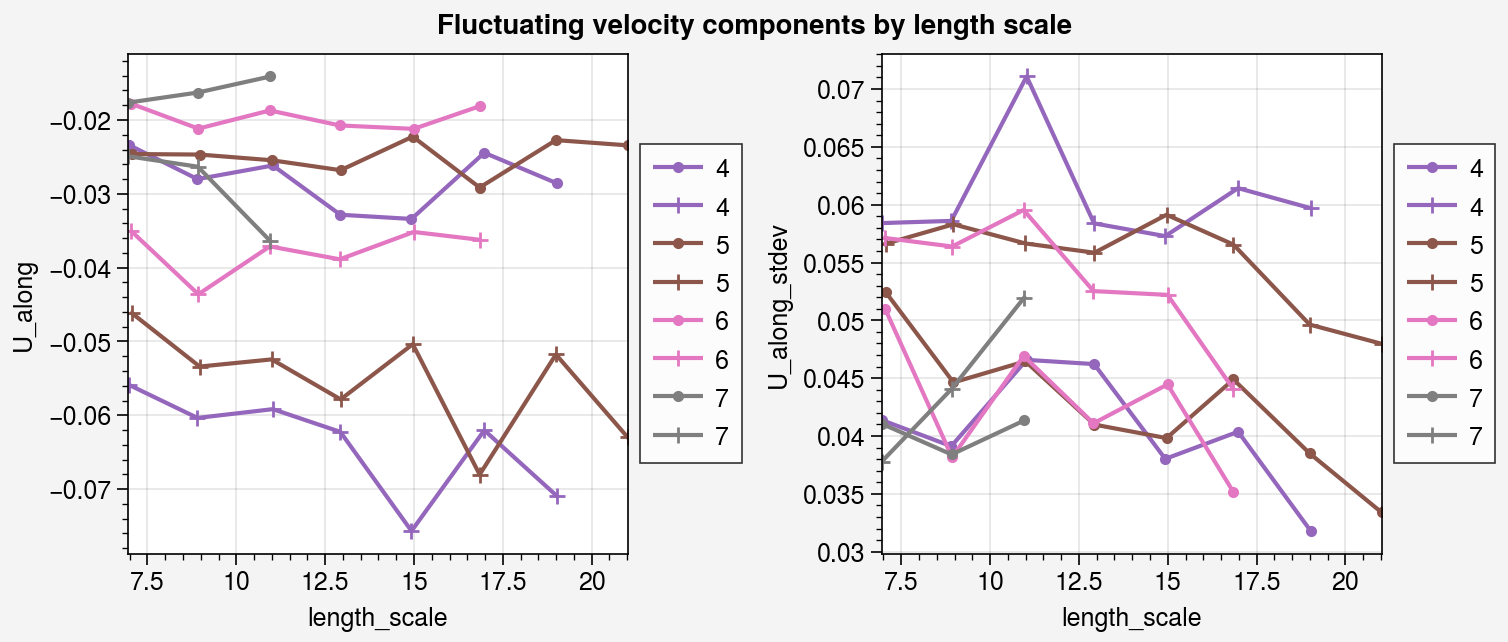

In [181]:
colors = [c['color'] for c in pplt.Cycle('tab10', 10)]

fig, ax = pplt.subplots(ncols=2, share=False)
for binnum, group in df_updated.groupby(df_updated.datetime.dt.month):
    mean_bin = group.loc[:, ['U_fluctuating', 'U_along', 'length_bin', 'length_scale']].groupby('length_bin').mean()
    std_bin = group.loc[:, ['U_fluctuating', 'U_along', 'length_bin', 'length_scale']].groupby('length_bin').std()
    cnt_bin = group.loc[:, ['U_fluctuating', 'U_along', 'length_bin', 'length_scale']].groupby('length_bin').count()
    std_bin.columns = [c+'_stdev' for c in std_bin.columns]
    plot_df = pd.concat([mean_bin, std_bin], axis=1)
    plot_df['counts'] = cnt_bin['length_scale']
    plot_df = plot_df.loc[plot_df.counts > 100]
    if len(plot_df) > 0:
        ax[0].plot(plot_df.length_scale, plot_df.U_along, label=str(binnum), marker='.', color=colors[binnum])
        ax[0].plot(plot_df.length_scale, plot_df.U_fluctuating, label=str(binnum), marker='+', color=colors[binnum])

        ax[1].plot(plot_df.length_scale, plot_df.U_along_stdev, label=str(binnum), marker='.', color=colors[binnum])
        ax[1].plot(plot_df.length_scale, plot_df.U_fluctuating_stdev, label=str(binnum), marker='+', color=colors[binnum])

ax.legend(loc='r', ncols=1)
ax.format(suptitle='Fluctuating velocity components by length scale')

In [89]:
sim_ualong = pd.read_csv('../data/simulation/u_along.csv', index_col=0)
sim_uacross = pd.read_csv('../data/simulation/u_across.csv', index_col=0)
sim_std_dev = pd.read_csv('../data/simulation/stdev.csv', index_col=0)

The data are flagged based on travel distance (minimum 1 pixel), circularity (minimum 0.6), and speed (max speed, and the minimum of the daily speeds). Probably too many floes are flagged, but we have to start somewhere. I've calculated the 5-day, 15-day, and 31-day local averages using the NSIDC data. We use these fields as an estimate of the direction of the mean current. We examine 

In [4]:
def plot_velocity_distribution(data_df, savename='../figures/velocity_histogram.png',
                             vel_comp1='U_along', vel_comp2='U_fluctuating',
                             vc1_name='Longitudinal', vc2_name='Transverse'):
    """Plots the histograms of the specified velocity components (normalized by standard deviation)
    against a Gaussian distribution. All floes in data_df lumped together. Future update could provide some
    sort of weighting."""

    all_u = data_df[vel_comp1].dropna()
    all_v = data_df[vel_comp2].dropna()
    print(len(all_u))
    fig, axs = pplt.subplots(ncols=2, width=6, sharex=False)
    normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)
    for ax, data in zip(axs, [all_u, all_v]):
        pdf, x_bins = np.histogram(data/np.std(data), bins=np.linspace(-7, 7, 151), density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])
        print(np.std(data))
        ax.plot(x_center, pdf, marker='.', lw=0, color='b') 
        ax.plot(x_center, normal_dist(x_center), marker='', lw=0.5, color='k', ls='--', label='N(0, 1)')
    axs[0].format(title=vc1_name, xlabel='$u\'_L$ (m/s)/$\sigma_{u\'_L}$')
    axs[1].format(title=vc2_name, xlabel='$u\'_T$ (m/s)/$\sigma_{u\'_T}$')
    axs[0].legend(loc='ul', ncols=1)
    axs[1].legend(loc='ul', ncols=1)
    axs.format(yscale='log', ylim=(1e-3, 1), xlim=(-7, 7),
               yformatter='log', suptitle='', fontsize=12, abc=True)
    if savename is not None:
        fig.save(savename, dpi=300)

The crux of the analysis is the computation of along and across track velocity components, and the bias adjustment in the mean. I found that 

In [70]:
results = {}
for tau in ['5D', '15D', '31D']:
    tau_alt = ''
    if tau != '5D':
        tau_alt = '_' + tau

    df_rotated = compute_along_across_components(df_ift, uvar='u', vvar='v',
                                umean='u' + tau + '_nsidc',
                                vmean='u' + tau + '_nsidc') 
    
    data = pd.DataFrame({'datetime': df_ift['datetime'],
                         'floe_id': df_ift['floe_id'],
                         'u': df_ift['u'], 
                         'v': df_ift['v'],
                         'u_mean': df_ift['u' + tau + '_nsidc'],
                         'v_mean': df_ift['v' + tau + '_nsidc'],
                         'u_along': df_rotated['u_along'],
                         'v_along': df_rotated['v_along'],
                         'u_across': df_rotated['u_across'],
                         'v_across': df_rotated['v_across'],
                         'U_fluctuating': df_rotated['U_fluctuating'],
                         'U_along': df_rotated['U_along']
                         }).dropna()
    # data = data.loc[data.qc_flag==0].copy()
    # data = compute_along_across_components(data)
    results[tau] = data.copy()

results_anomalies = {}
for tau in ['5D', '15D', '31D']:
    data = pd.DataFrame({'datetime': df_ift['datetime'],
                         'floe_id': df_ift['floe_id'],
                         'edge_dist': df_ift['edge_dist_km'],
                         'coast_dist': df_ift['coast_dist_km'],
                         'floe_size': df_ift['area_km2'],
                         'rotation_rate': df_ift['zeta'],
                         'sea_ice_concentration': df_ift['nsidc_sic'],
                         'u': df_ift['u'] - df_ift['u_nsidc'], 
                         'v': df_ift['v'] - df_ift['v_nsidc'],
                         'u_mean': df_ift['u' + tau + '_nsidc'],
                         'v_mean': df_ift['v' + tau + '_nsidc']
                         }).dropna()
    data = compute_along_across_components(data)
    results_anomalies[tau] = data.copy()

In [43]:
results_anomalies['5D']['u']

0.06031013252433559

Some things to think about
1. Should we expect that the along-track component is symmetric around 0? If the climatological direction is correct, I think we should expect assymetry in the magnitude. The anomalies in the along track and cross track directions may be different in interesting ways. If the NSIDC product is biased low, then we expect a distribution where there are more positive anomalies than negative anomalies.

5D U_along 11.199 cm/s
15D U_along 10.83 cm/s
31D U_along 10.487 cm/s
5D U_fluctuating 7.829 cm/s
15D U_fluctuating 7.475 cm/s
31D U_fluctuating 7.177 cm/s


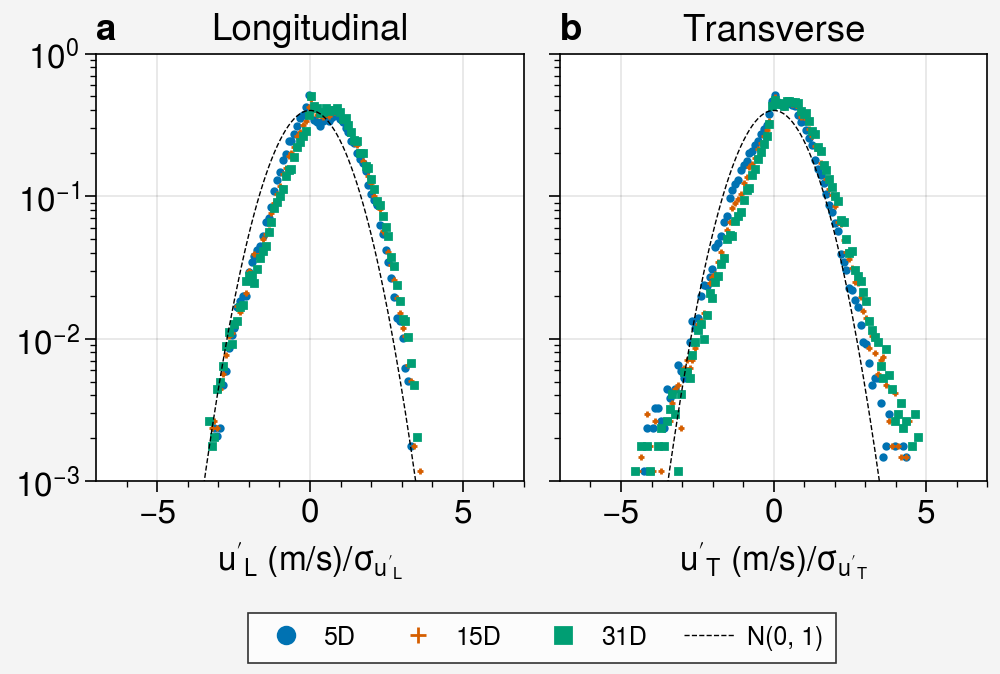

In [33]:
fig, axs = pplt.subplots(ncols=2, width="5in", sharex=False)
normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)
for ax, var in zip(axs, ['U_along', 'U_fluctuating']):
    for tau, m in zip(results, ['o', '+', 's']):
        u = results[tau][var]
        ustd = results[tau][var].std()
        print(tau, var, np.round(ustd*100, 3), 'cm/s')   
        pdf, x_bins = np.histogram(u/ustd, bins=np.linspace(-7, 7, 151), density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])
        if 'along' in var:
            label = tau
            label_pdf = 'N(0, 1)'
        else:
            label = ''
            label_pdf = ''
        ax.plot(x_center, pdf, marker=m, lw=0, label=label, ms=2) 
     
    ax.plot(x_center, normal_dist(x_center), marker='', lw=0.5, color='k', ls='--', label=label_pdf)
axs[0].format(title='Longitudinal', xlabel='$u\'_L$ (m/s)/$\sigma_{u\'_L}$')
axs[1].format(title='Transverse', xlabel='$u\'_T$ (m/s)/$\sigma_{u\'_T}$')
# axs[0].legend(loc='ul', ncols=1)
fig.legend(loc='b', ncols=4, ms=6)
axs.format(yscale='log', ylim=(1e-3, 1), xlim=(-7, 7),
           yformatter='log', suptitle='', fontsize=12, abc=True)
fig.save('../figures/fig_01v1_alongtrack_crosstrack_velocity.pdf', dpi=300)

## Vector difference between IFT and NSIDC

(array([4.162e+03, 4.024e+03, 2.386e+03, 1.411e+03, 8.260e+02, 5.230e+02,
        3.290e+02, 1.900e+02, 1.180e+02, 7.900e+01, 4.700e+01, 3.500e+01,
        3.500e+01, 2.200e+01, 1.000e+01, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([2.20556706e-04, 2.30985012e-02, 4.59764457e-02, 6.88543902e-02,
        9.17323347e-02, 1.14610279e-01, 1.37488224e-01, 1.60366168e-01,
        1.83244113e-01, 2.06122057e-01, 2.29000002e-01, 2.51877946e-01,
        2.74755891e-01, 2.97633835e-01, 3.20511780e-01, 3.43389724e-01,
        3.66267669e-01, 3.89145613e-01, 4.12023558e-01, 4.34901502e-01,
        4.57779447e-01]),
 <BarContainer object of 20 artists>)

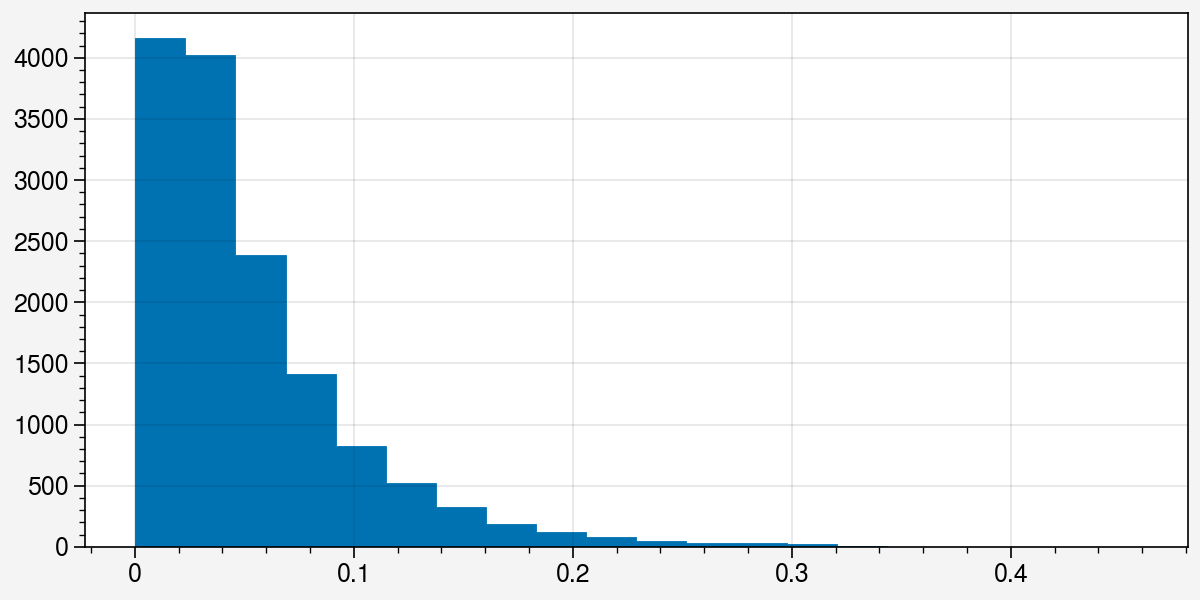

In [81]:
fig, ax = pplt.subplots(width=6, height=3)
ax.hist(np.sqrt((df_ift['u']-df_ift['u_nsidc'])**2 - (df_ift['v'] - df_ift['v_nsidc'])**2), bins=20)

<AxesSubplot:xlabel='datetime'>

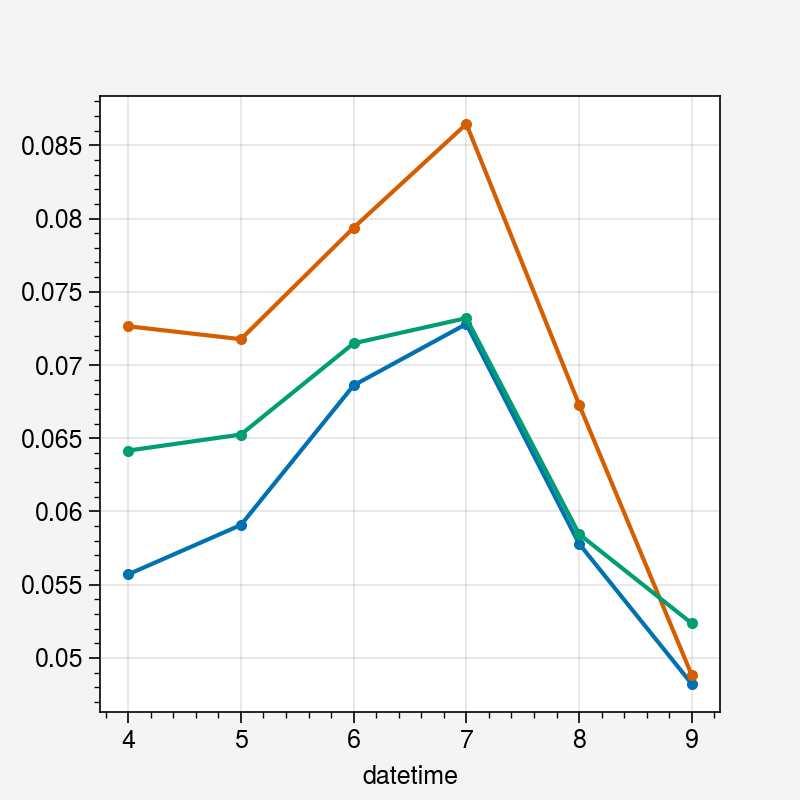

In [91]:
(df_ift['u']-df_ift['u_nsidc']).groupby(df_ift.datetime.dt.month).std().plot(marker='.')
(df_ift['v']-df_ift['v_nsidc']).groupby(df_ift.datetime.dt.month).std().plot(marker='.')
(df_ift['speed']-np.sqrt(df_ift['v_nsidc']**2 + df_ift['u_nsidc']**2)).groupby(df_ift.datetime.dt.month).std().plot(marker='.')

In [121]:
6.62 * 1000 / (60*60*24)

0.07662037037037037

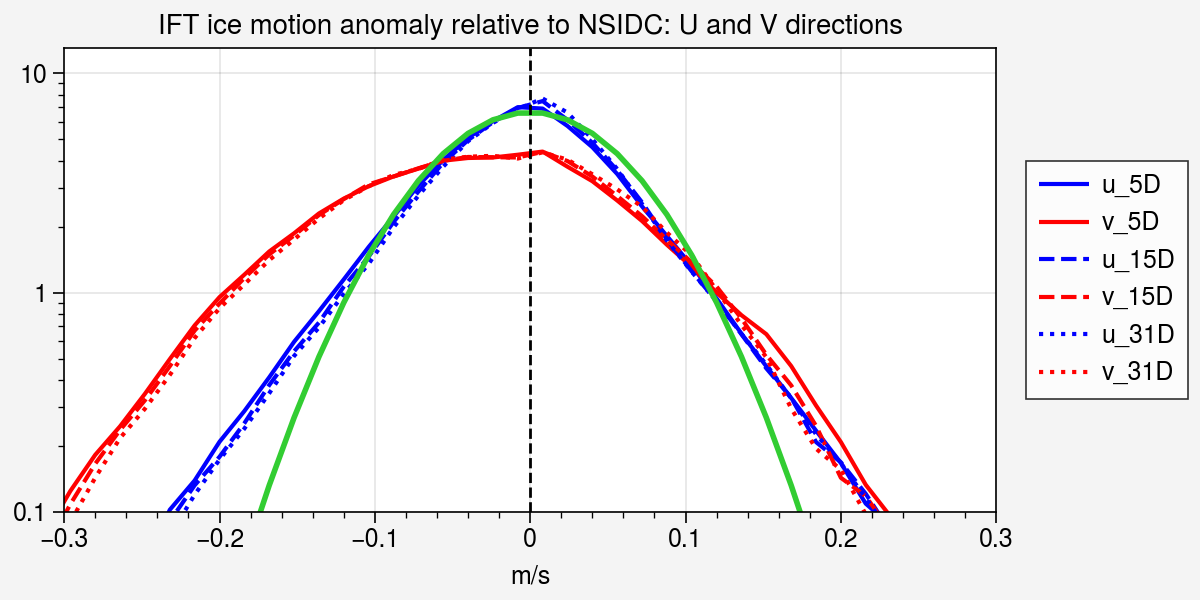

In [192]:
## Directional anomalies
sigma = 0.06
normal_dist = lambda x: 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2 * (x/sigma)**2)

fig, ax = pplt.subplots(width=6, height=3)
x_bins = np.linspace(-0.4, 0.4, 51)
for tau, ls in zip(['5D', '15D', '31D'], ['-', '--', ':']):
    u_mean = results[tau]['u_mean']
    v_mean = results[tau]['v_mean']
    u = df_ift['u']
    v = df_ift['v']
    s = np.sqrt(u**2 + v**2)
    s_mean = np.sqrt(u_mean**2 + v_mean**2)
    u_pdf, _ = np.histogram(u - u_mean, bins=x_bins, density=True)
    v_pdf, _ = np.histogram(v - v_mean, bins=x_bins, density=True)
    s_pdf, _ = np.histogram(s - s_mean, bins=x_bins, density=True)
    x_center = 1/2*(x_bins[1:] + x_bins[:-1])
    ax.plot(x_center, u_pdf, color='b', label='u_' + tau, ls=ls)
    ax.plot(x_center, v_pdf, color='r', label='v_' + tau, ls=ls)
    # ax.plot(x_center, s_pdf, color='k', label='speed_' + tau, ls=ls)
ax.plot(x_center, normal_dist(x_center), marker='', lw=2, color='limegreen', ls='-', label=label_pdf)    
ax.legend(loc='r', ncols=1)
ax.format(title='IFT ice motion anomaly relative to NSIDC: U and V directions', xlabel='m/s', yscale='log', xlim=(-0.3, 0.3), ylim=(0.1, 13))
ax.axvline(0, c='k', lw=1, ls='--')

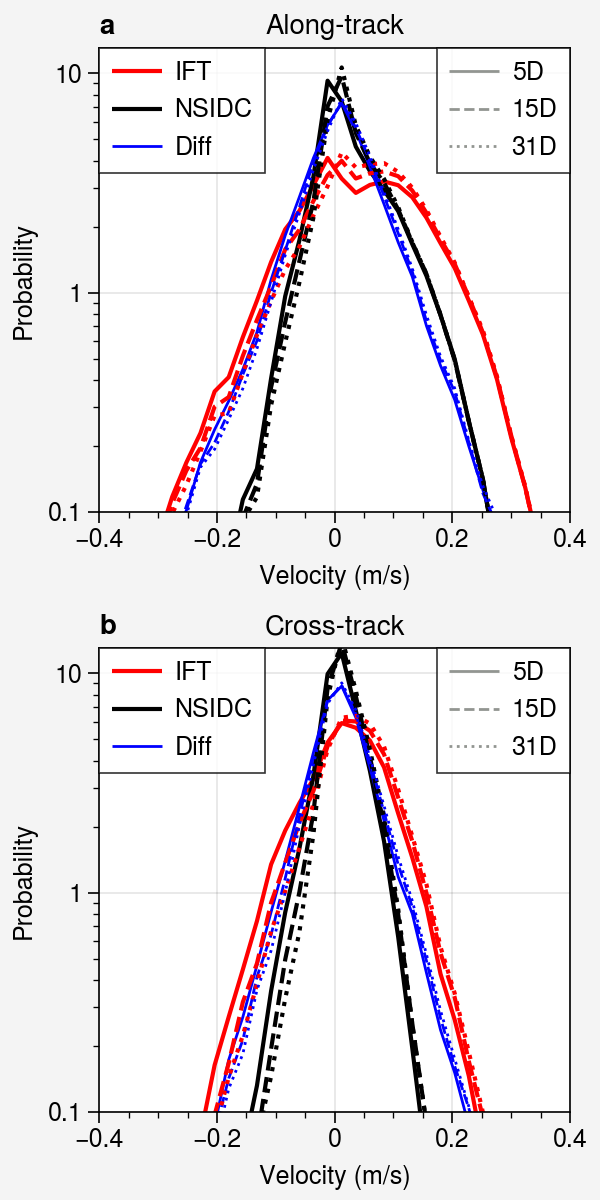

In [5]:
## Directional anomalies
sigma = 0.06
normal_dist = lambda x: 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2 * (x/sigma)**2)

fig, axs = pplt.subplots(width=3, height=6, nrows=2, share=False)
x_bins = np.linspace(-0.6, 0.6, 51)
for tau, ls in zip(['5D', '15D', '31D'], ['-', '--', ':']):
    df_rot_ift = compute_along_across_components(df_ift.copy(), uvar='u', vvar='v',
                                    umean='u' + tau + '_nsidc',
                                    vmean='u' + tau + '_nsidc')
    df_rot_nsidc = compute_along_across_components(df_ift.drop(['u', 'v'], axis=1).rename({'u_nsidc': 'u', 'v_nsidc': 'v'}, axis=1), uvar='u', vvar='v',
                                    umean='u' + tau + '_nsidc',
                                    vmean='u' + tau + '_nsidc')
    for data, color, product in zip([df_rot_ift, df_rot_nsidc], ['r', 'k'], ['IFT', 'NSIDC']):
    
        u = data['U_along']
        v = data['U_fluctuating']
        u_pdf, _ = np.histogram(u, bins=x_bins, density=True)
        v_pdf, _ = np.histogram(v, bins=x_bins, density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])

        label = product
        if tau != '5D':
            label = ''
            
        axs[0].plot(x_center, u_pdf, color=color, label=label, ls=ls)
        axs[1].plot(x_center, v_pdf, color=color, label=label, ls=ls)
    comp = df_ift.copy()
    comp['u'] = comp['u'] - comp['u_nsidc']
    comp['v'] = comp['v'] - comp['v_nsidc']
    df_comp = compute_along_across_components(comp, uvar='u', vvar='v',
                                        umean='u' + tau + '_nsidc',
                                        vmean='u' + tau + '_nsidc')
    u = df_comp['U_along']
    v = df_comp['U_fluctuating']
    u_pdf, _ = np.histogram(u, bins=x_bins, density=True)
    v_pdf, _ = np.histogram(v, bins=x_bins, density=True)
    x_center = 1/2*(x_bins[1:] + x_bins[:-1])

    label = 'Diff'
    if tau != '5D':
        label = ''
        
    axs[0].plot(x_center, u_pdf, color='b', label=label, ls=ls, lw=1)
    axs[1].plot(x_center, v_pdf, color='b', label=label, ls=ls, lw=1)

axs[0].legend(loc='ul', ncols=1)
axs[1].legend(loc='ul', ncols=1)

h = [axs[0].plot([],[], lw=1, color='gray', ls=ls) for ls in ['-', '--', ':']]
axs[0].legend(h, ['5D', '15D', '31D'], loc='ur', ncols=1)
axs[1].legend(h, ['5D', '15D', '31D'], loc='ur', ncols=1)

axs[0].format(title='Along-track', ylabel='Probability')
axs[1].format(title='Cross-track', ylabel='Probability')
axs.format(xlabel='Velocity (m/s)', yscale='log', xlim=(-0.4, 0.4), ylim=(0.1, 13), abc=True)

31D U_along 7.995 cm/s
Fitted exponential dist. scale param: 0.74
31D U_fluctuating 6.341 cm/s
Fitted exponential dist. scale param: 0.74


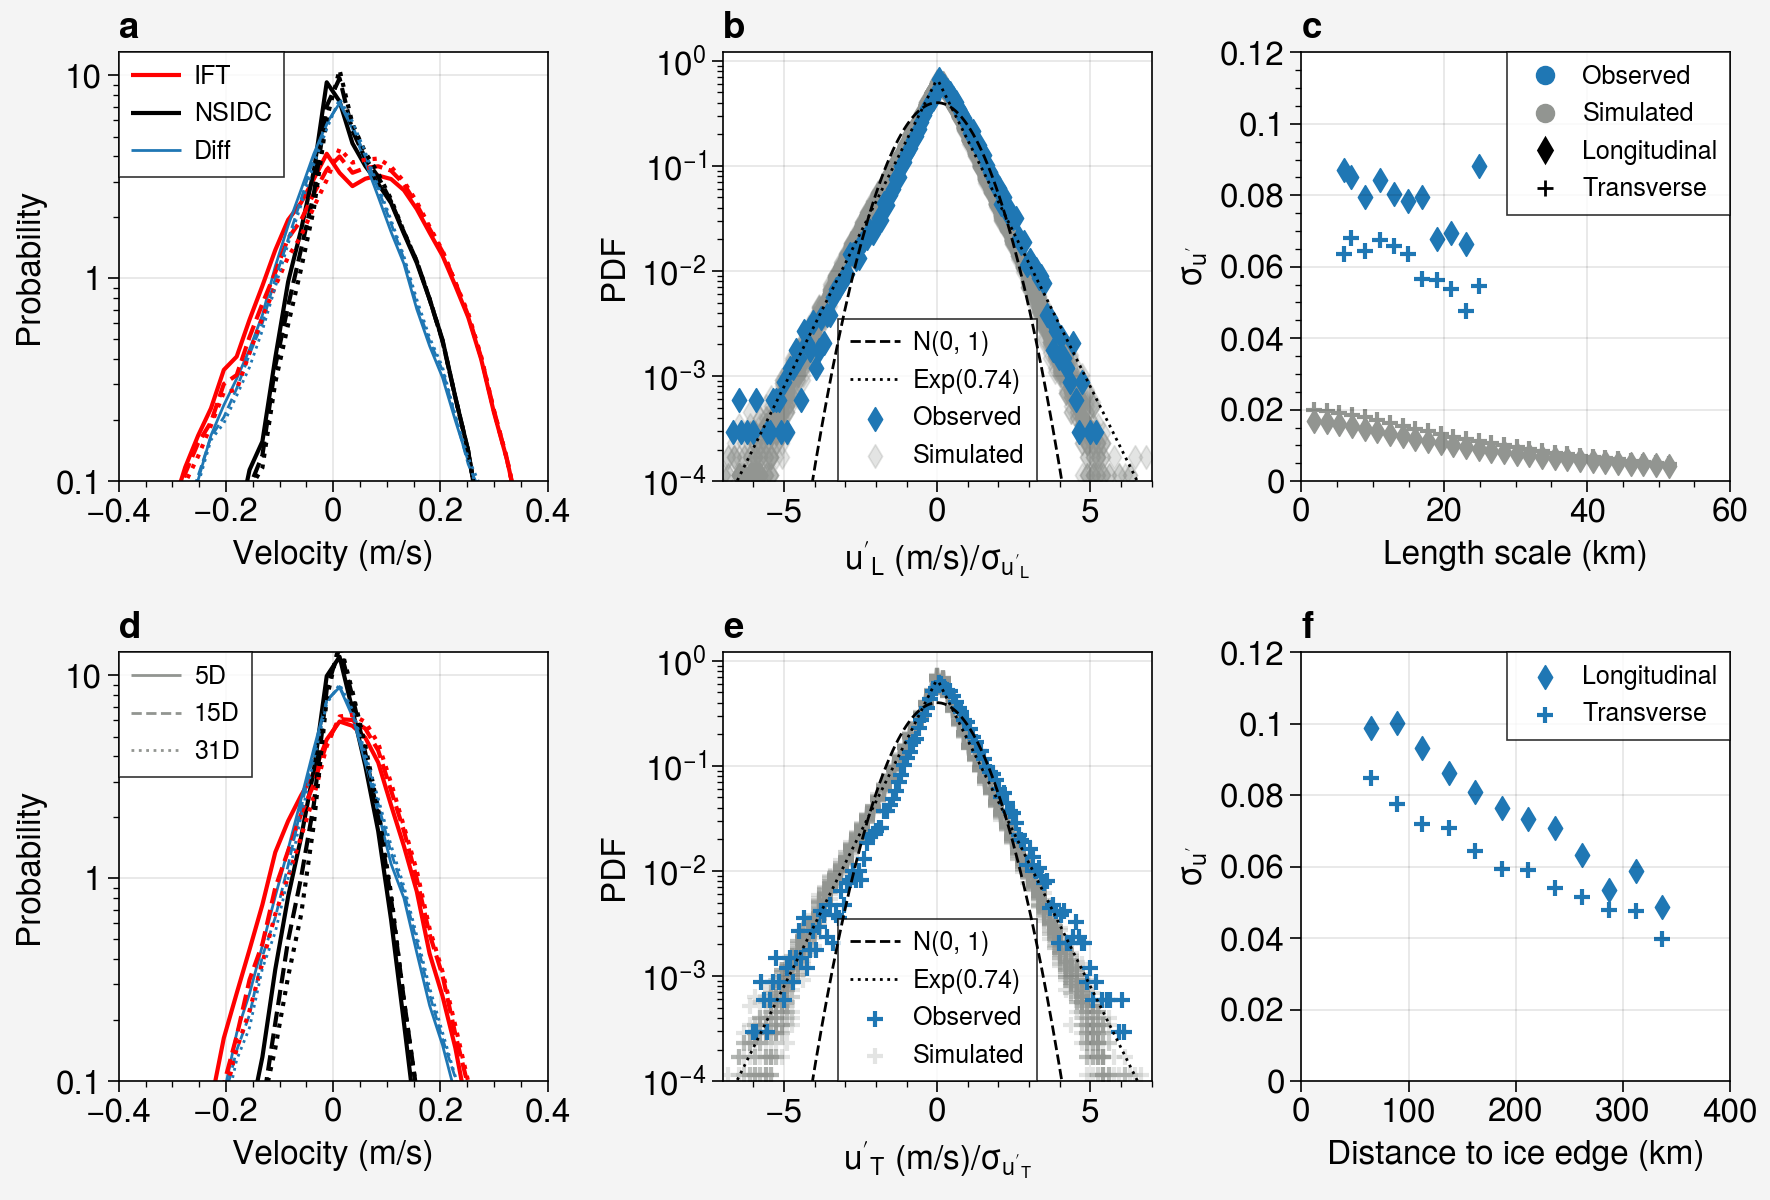

In [62]:
# Compute anomaly relative to the NSIDC data
tau = '5D'
comp = df_ift.copy()
comp['u'] = comp['u'] - comp['u_nsidc']
comp['v'] = comp['v'] - comp['v_nsidc']
df_comp = compute_along_across_components(comp, uvar='u', vvar='v',
                                    umean='u' + tau + '_nsidc',
                                    vmean='u' + tau + '_nsidc')

length_bins = np.arange(0, 50, 2)

df_edge = pd.concat({'sigma_ut': df_comp[['edge_bin', 'U_fluctuating']].groupby('edge_bin').std(),
                      'sigma_ul': df_comp[['edge_bin', 'U_along']].groupby('edge_bin').std(),
              'n': df_comp[['edge_bin', 'U_fluctuating']].groupby('edge_bin').count(),
             'd': df_comp[['edge_bin', 'edge_dist_km']].groupby('edge_bin').mean()}, axis=1)
df_edge.columns = pd.Index(['sigma_ut', 'sigma_ul', 'n', 'd'])

df_lscale = pd.concat({'sigma_ut': df_comp[['length_bin', 'U_fluctuating']].groupby('length_bin').std(),
                      'sigma_ul': df_comp[['length_bin', 'U_along']].groupby('length_bin').std(),
              'n': df_comp[['length_bin', 'U_fluctuating']].groupby('length_bin').count(),
             'L': df_comp[['length_bin', 'length_scale']].groupby('length_bin').mean()}, axis=1)
df_lscale.columns = pd.Index(['sigma_ut', 'sigma_ul', 'n', 'L'])

R = sim_std_dev['u_along (m/s)'].index
L = np.sqrt(np.pi)*R

normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)

## Directional anomalies
sigma = 1
normal_dist = lambda x: 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2 * (x/sigma)**2)

fig, axs = pplt.subplots(height=6, nrows=2, ncols=3, share=False)
x_bins = np.linspace(-0.6, 0.6, 51)
for tau, ls in zip(['5D', '15D', '31D'], ['-', '--', ':']):
    df_rot_ift = compute_along_across_components(df_ift.copy(), uvar='u', vvar='v',
                                    umean='u' + tau + '_nsidc',
                                    vmean='u' + tau + '_nsidc')
    df_rot_nsidc = compute_along_across_components(df_ift.drop(['u', 'v'], axis=1).rename({'u_nsidc': 'u', 'v_nsidc': 'v'}, axis=1), uvar='u', vvar='v',
                                    umean='u' + tau + '_nsidc',
                                    vmean='u' + tau + '_nsidc')
    for data, color, product in zip([df_rot_ift, df_rot_nsidc], ['r', 'k'], ['IFT', 'NSIDC']):
    
        u = data['U_along']
        v = data['U_fluctuating']
        u_pdf, _ = np.histogram(u, bins=x_bins, density=True)
        v_pdf, _ = np.histogram(v, bins=x_bins, density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])

        label = product
        if tau != '5D':
            label = ''
            
        axs[0, 0].plot(x_center, u_pdf, color=color, label=label, ls=ls)
        axs[1, 0].plot(x_center, v_pdf, color=color, label=label, ls=ls)
    comp = df_ift.copy()
    comp['u'] = comp['u'] - comp['u_nsidc']
    comp['v'] = comp['v'] - comp['v_nsidc']
    df_comp = compute_along_across_components(comp, uvar='u', vvar='v',
                                        umean='u' + tau + '_nsidc',
                                        vmean='u' + tau + '_nsidc')
    u = df_comp['U_along']
    v = df_comp['U_fluctuating']
    u_pdf, _ = np.histogram(u, bins=x_bins, density=True)
    v_pdf, _ = np.histogram(v, bins=x_bins, density=True)
    x_center = 1/2*(x_bins[1:] + x_bins[:-1])

    label = 'Diff'
    if tau != '5D':
        label = ''
        
    axs[0, 0].plot(x_center, u_pdf, color='tab:blue', label=label, ls=ls, lw=1)
    axs[1, 0].plot(x_center, v_pdf, color='tab:blue', label=label, ls=ls, lw=1)

axs[0, 0].legend(loc='ul', ncols=1)
# axs[1, 0].legend(loc='ul', ncols=1)

h = [axs[0,0].plot([],[], lw=1, color='gray', ls=ls) for ls in ['-', '--', ':']]
# axs[0,0].legend(h, ['5D', '15D', '31D'], loc='ur', ncols=1)
axs[1,0].legend(h, ['5D', '15D', '31D'], loc='ul', ncols=1)

axs[0,0].format(title='', ylabel='Probability')
axs[1,0].format(title='', ylabel='Probability')
axs.format(xlabel='Velocity (m/s)', yscale='log', xlim=(-0.4, 0.4), ylim=(0.1, 13), abc=True)


#### Fluctuating Velocity Distributions
for ax, symb, var in zip([axs[0, 1], axs[1, 1]], ['d', '+'], ['U_along', 'U_fluctuating']):
    ustd = df_comp[var].std()
    u = df_comp[var]
    print(tau, var, np.round(ustd*100, 3), 'cm/s')   
    pdf, x_bins = np.histogram(u/ustd, bins=np.linspace(-7, 7, 151), density=True)
    x_center = 1/2*(x_bins[1:] + x_bins[:-1])
    if 'along' in var:
        label_pdf = 'N(0, 1)'
    else:
        label_pdf = ''

    ax.scatter(x_center, pdf, marker=symb, zorder=5, color='tab:blue', label='Observed') 
    # ax.plot(x_center, normal_dist(x_center), marker='',
    #         lw=0.5, color='k', ls='--', label=label_pdf, zorder=1)


    train = df_comp.dropna(subset=var).sample(1000, replace=False)
    test = df_comp.dropna(subset=var)
    test = test.loc[[x for x in test.index if x not in train.index]]
    abs_u_train = np.abs(train[var])/np.std(train[var])
    abs_u_test = np.abs(test[var])/np.std(test[var])
    exp_loc, exp_scale = stats.expon.fit(abs_u_train, floc=0)
    print('Fitted exponential dist. scale param:', np.round(exp_scale, 2))
    expon_dist = stats.expon(loc=0, scale=exp_scale).pdf
    normal_dist = stats.norm(loc=0, scale=1).pdf
    
    ax.plot(x_center, normal_dist(x_center), marker='',
            lw=1, color='k', ls='--', label='N(0, 1)', zorder=10)
    ax.plot(x_center, 0.5*expon_dist(np.abs(x_center)), marker='',
            lw=1, color='k', ls=':', label='Exp({s})'.format(s=np.round(exp_scale, 2)), zorder=10)

# The normalization in np.histogram is not the same as the normalization in
# Minki's matlab routine, to bring them to the same convention, we need to divide by
# the bin spacing. 
dx = np.diff(sim_uacross.index)[0]
   
for col in sim_ualong.columns:
    if col == sim_ualong.columns[0]:
        label='Simulated'
    else:
        label=''
    axs[0, 1].scatter(sim_ualong.index, sim_ualong.loc[:, col]/dx, color='gray',
                m='d', alpha=0.25, label=label, zorder=0)
    axs[1, 1].scatter(sim_uacross.index, sim_uacross.loc[:, col]/dx, color='gray',
                alpha=0.25, m='+',  label=label, zorder=0)
    
axs[0, 1].format(title='', xlabel='$u\'_L$ (m/s)/$\sigma_{u\'_L}$',
              yscale='log', ylim=(1e-4, 1.2), xlim=(-7, 7),
              yformatter='log', ylabel='PDF')
axs[1, 1].format(title='', xlabel='$u\'_T$ (m/s)/$\sigma_{u\'_T}$',
              yscale='log', ylim=(1e-4, 1.2), xlim=(-7, 7),
              yformatter='log', ylabel='PDF')

axs[0, 1].legend(ncols=1)
axs[1, 1].legend(ncols=1)

# Length scale dependence, for length scales with at least 300 observations
idx = df_lscale.n > 300
ax = axs[0, 2]
ax.scatter(df_lscale.loc[idx, 'L'].values,
        df_lscale.loc[idx, 'sigma_ul'].values,
        marker='d', label='', color='tab:blue')
ax.scatter(df_lscale.loc[idx, 'L'].values,
        df_lscale.loc[idx, 'sigma_ut'].values,
        marker='+', label='', color='tab:blue')
ax.scatter(L, sim_std_dev['u_along (m/s)'],
           marker='d', label='', color='gray')
ax.scatter(L, sim_std_dev['u_across (m/s)'],
           marker='+', label='', color='gray')
ax.format(xlabel='Length scale (km)', ylabel='$\sigma_{u\'}$', title='', ylim=(0, 0.12), xlim=(0, 60), yscale='linear')
# ax.plot([], 

# Edge distance, for edge bins with at least 300 observations
idx = df_edge.n > 300
ax = axs[1, 2]
ax.scatter(df_edge.loc[idx, 'd'].values,
               df_edge.loc[idx, 'sigma_ul'].values, marker='d', color='tab:blue', label='Longitudinal')
ax.scatter(df_edge.loc[idx, 'd'].values,
               df_edge.loc[idx, 'sigma_ut'].values, marker='+', color='tab:blue', label='Transverse')
ax.format(ylim=(0, 0.12), ytickminor=False, xtickminor=False, yscale='linear', xlim=(0, 400),
         ylabel='$\sigma_{u\'}$', xlabel='Distance to ice edge (km)', fontsize=12)
ax.legend(loc='ur', ncols=1)

l = ['Observed', 'Simulated', 'Longitudinal', 'Transverse']
h = [ax.plot([],[], marker=m, color=c, lw=0) for m, c in zip(['o', 'o', 'd', '+'],
                                                           ['tab:blue', 'gray', 'k', 'k'])]
axs[0, 2].legend(h, l, ncols=1)

fig.format(fontsize=12)
fig.save('../figures/fig12_velocity_obs_sim.pdf', dpi=300)
fig.save('../figures/fig12_velocity_obs_sim.png', dpi=300)

In [64]:
train = df_comp.dropna(subset=var).sample(1000, replace=False)
test = df_comp.dropna(subset=var)
test = test.loc[[x for x in test.index if x not in train.index]]
abs_u_train = np.abs(train[var])/np.std(train[var])
abs_u_test = np.abs(test[var])/np.std(test[var])
expon_dist = stats.expon(loc=0, scale=exp_scale)


In [69]:
n = len(abs_u_test)
n

225694

In [90]:
d = np.array([stats.ks_1samp(expon_dist.rvs(1000), cdf=expon_dist.cdf).statistic for x in range(1000)])

In [105]:

d2 =  np.array([stats.ks_1samp(abs_u_test.sample(1000), cdf=expon_dist.cdf).statistic for x in range(1000)])

In [102]:
x = test[var][test[var] > 0]/np.std(test[var][test[var] > 0])
stats.ks_1samp(x, cdf=expon_dist.cdf)

KstestResult(statistic=0.15949278177086768, pvalue=0.0)

In [103]:
x = test[var][test[var] < 0]/np.std(test[var][test[var] < 0])
stats.ks_1samp(np.abs(x), cdf=expon_dist.cdf)

KstestResult(statistic=0.03654341208348011, pvalue=6.175536064799098e-96)

In [112]:
df_ift.columns

Index(['datetime', 'floe_id', 'longitude', 'latitude', 'x_stere', 'y_stere',
       'area', 'perimeter', 'axis_major_length', 'axis_minor_length',
       'solidity', 'circularity', 'nsidc_sic', 'lr_probability', 'zeta',
       'zeta_est', 'u', 'v', 'bearing', 'speed', 'area_km2', 'perimeter_km',
       'axis_major_length_km', 'axis_minor_length_km', 'edge_dist_km',
       'coast_dist_km', 'u_nsidc', 'v_nsidc', 'u5D_nsidc', 'v5D_nsidc',
       'u15D_nsidc', 'v15D_nsidc', 'u31D_nsidc', 'v31D_nsidc', 'area_adj_km2',
       'edge_bin', 'length_scale', 'length_bin', 'qc_flag'],
      dtype='object')

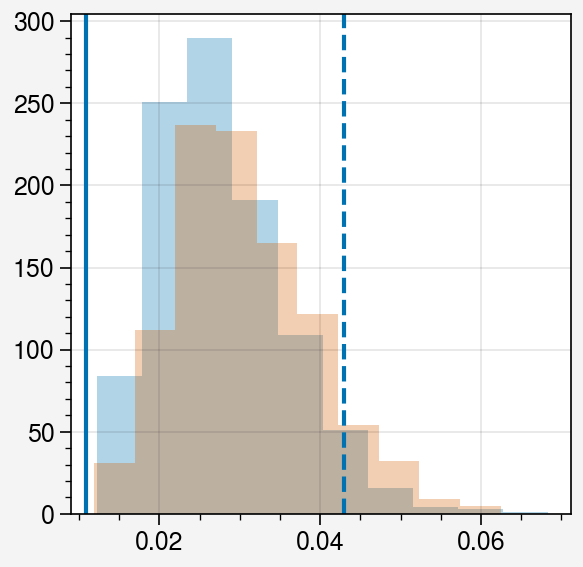

In [110]:
fig, ax = pplt.subplots()
ax.hist(d, alpha=0.3)
ax.hist(d2, alpha=0.3)
ax.axvline(np.quantile(d, 0.95), ls='--')
ax.axvline(stats.ks_1samp(abs_u_test, cdf=expon_dist.cdf).statistic)

In [87]:
tau = '5D'
df_rot_ift = compute_along_across_components(df_ift.copy(), uvar='u', vvar='v',
                                umean='u' + tau + '_nsidc',
                                vmean='u' + tau + '_nsidc')
df_rot_nsidc = compute_along_across_components(df_ift.drop(['u', 'v'], axis=1).rename({'u_nsidc': 'u', 'v_nsidc': 'v'}, axis=1), uvar='u', vvar='v',
                                umean='u' + tau + '_nsidc',
                                vmean='u' + tau + '_nsidc')

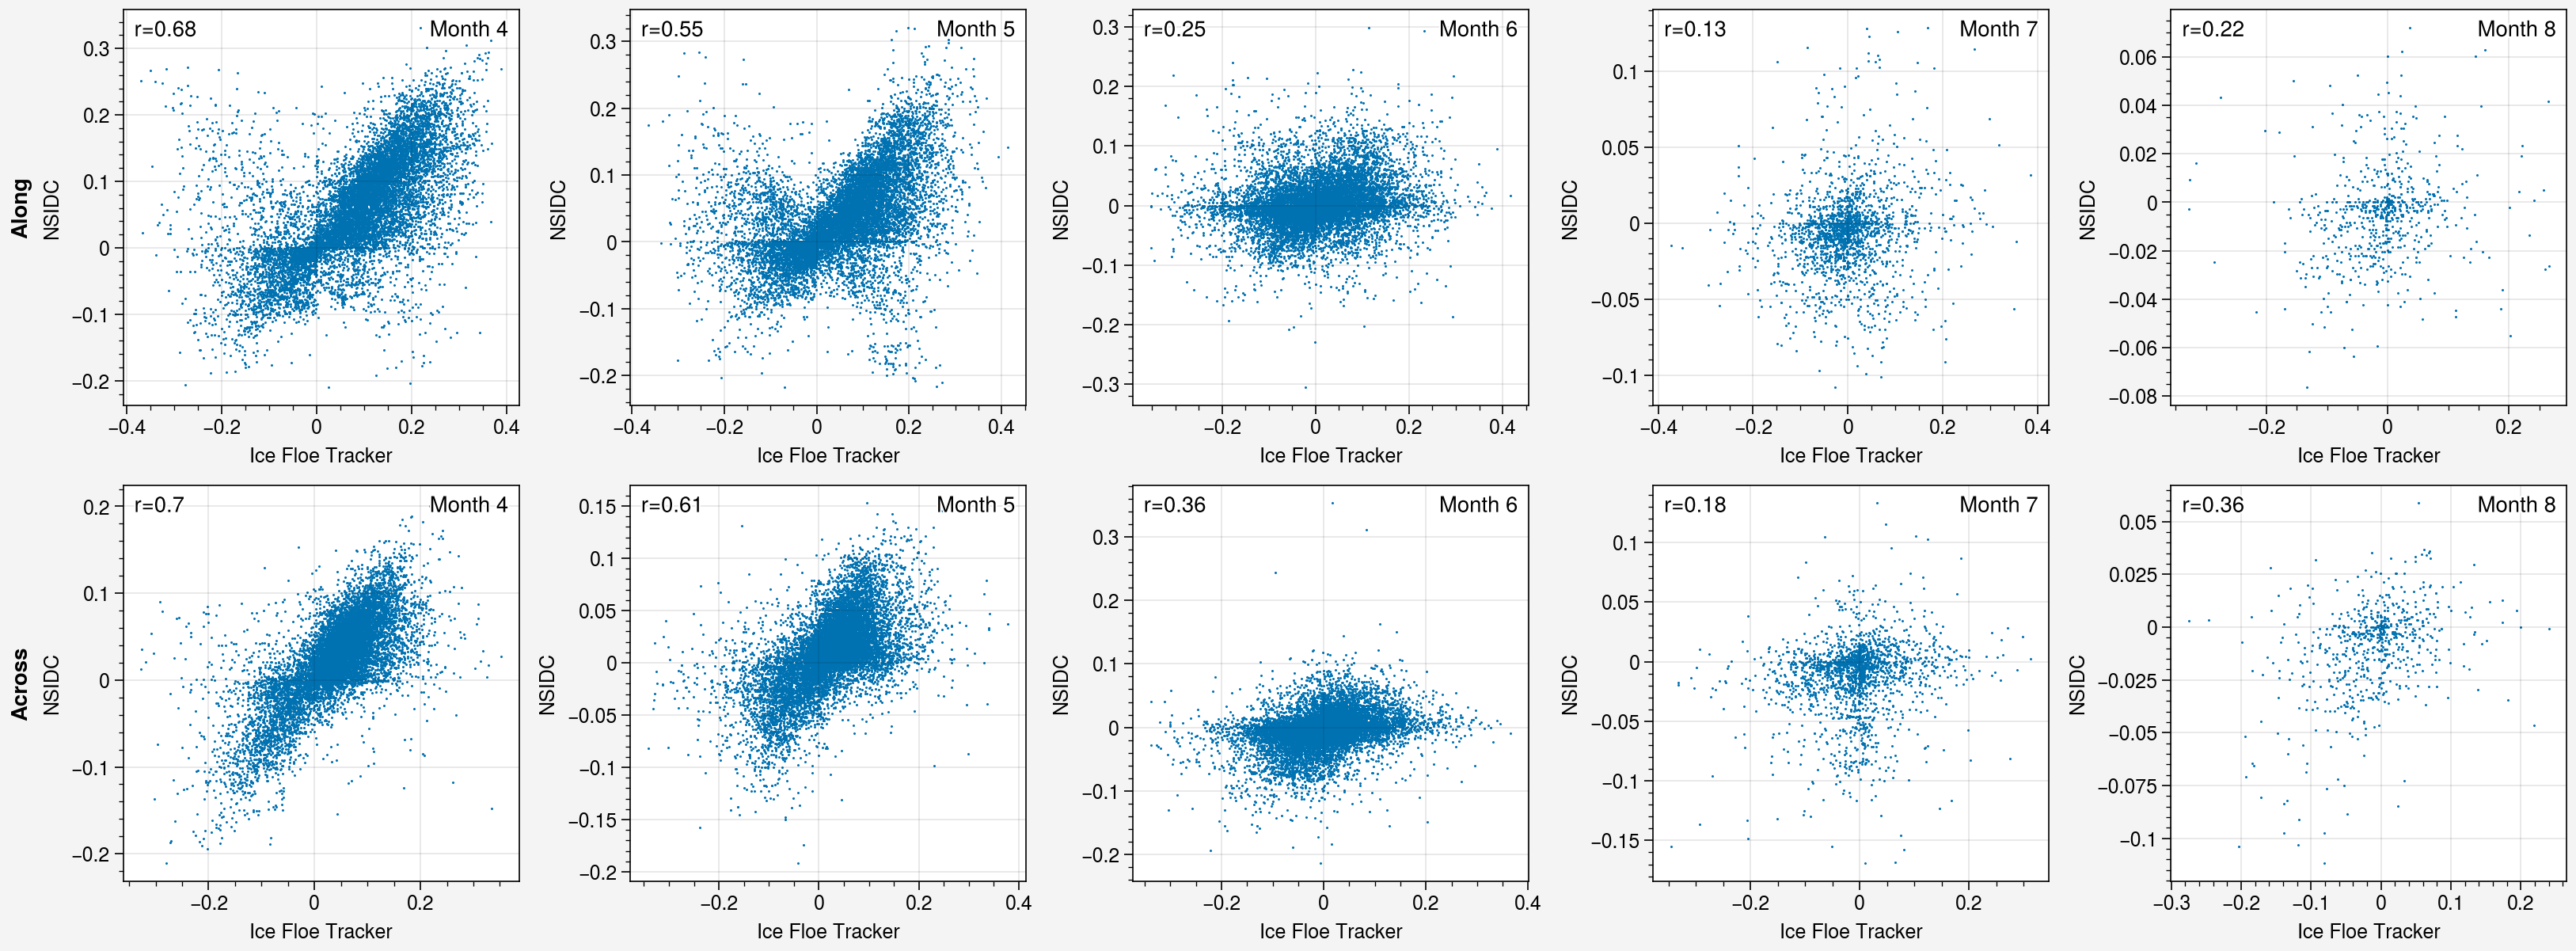

In [88]:
fig, axs = pplt.subplots(ncols=5, nrows=2, share=False)
for row, var in enumerate(['U_along', 'U_fluctuating']):
    for col, month in enumerate(range(4, 9)):
        ax = axs[row, col]
        sel = df_rot_ift.datetime.dt.month == month
        ax.scatter(df_rot_ift.loc[sel, var], df_rot_nsidc.loc[sel, var], marker='.', ms=1)
        ax.format(ultitle='r=' + str(df_rot_ift.loc[sel, var].corr(df_rot_nsidc.loc[sel, var], method='spearman').round(2)),
                  urtitle='Month ' + str(month), xlabel='Ice Floe Tracker', ylabel='NSIDC', leftlabels=['Along', 'Across'])
        # ax.plot([-0.2, 0.3], [-0.2, 0.3])

Correlation analysis: 
* more often than not, components are aligned (share the same sign).
* correlation is highest early in the year (~0.7) dropping to 0.36 or less later. Lowest in July.
* some variation in correlation strength when comparing to different time average flows, but not much
* Similar correlation in both along and across components.

Other things that can be considered:
* Dependence on floe size. Are the misaligned components more likely to be small/large?
* Is there a strong tendency with location? Regions where the errors are larger?
* How large are the residuals? How can we transition into the discussion of the sub-grid scale variability?

In [182]:
n = len(df_rot_ift.loc[sel, var])
r = df_rot_ift.loc[sel, var].corr(df_rot_nsidc.loc[sel, var], method='spearman').round(2)
t = r*np.sqrt(n - 2)/np.sqrt(1 - r**2)
n, r, t

(1719, 0.31, 13.510973688121306)

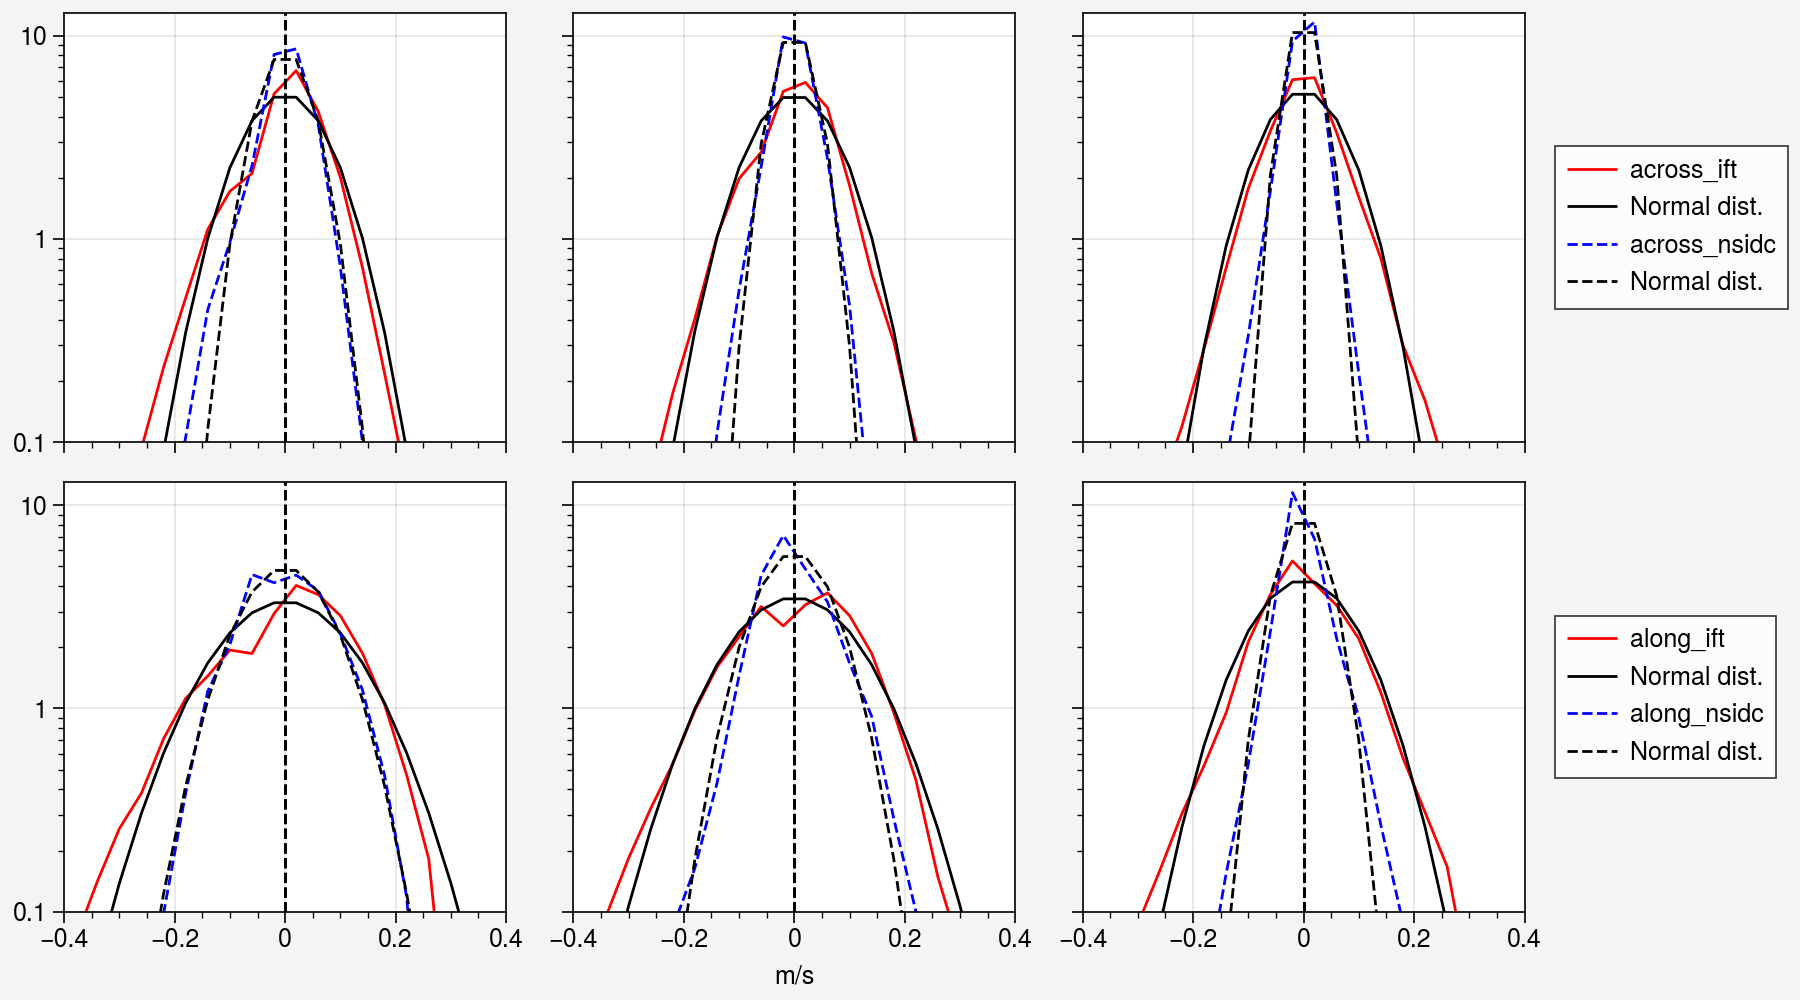

In [284]:
## Directional anomalies
sigma = 0.06

fig, axs = pplt.subplots(width=9, height=5, ncols=3, nrows=2)
for col, month in zip([0, 1, 2], [4, 5, 6]):
    for ls, suffix, c in zip(['-', '--'], ['', '_nsidc'], ['r', 'b']):
        
        x_bins = np.linspace(-0.6, 0.6, 31)
        tau = '5D'
        idx = df_ift.datetime.dt.month == month 
        df_rotated = compute_along_across_components(df_ift.loc[idx,:], uvar='u' + suffix, vvar='v' + suffix,
                                umean='u' + tau + '_nsidc',
                                vmean='u' + tau + '_nsidc') 
        u = df_rotated['U_fluctuating'] - df_rotated['U_fluctuating'].mean()
        v = df_rotated['U_along'] - df_rotated['U_along'].mean()

        # axs[0, col].axvline(df_rotated['U_fluctuating'].mean(), color=c, ls=ls)
        # axs[1, col].axvline(df_rotated['U_along'].mean(), color=c, ls=ls)
        
        u_pdf, _ = np.histogram(u, bins=x_bins, density=True)
        v_pdf, _ = np.histogram(v, bins=x_bins, density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])
        if suffix == '':
            suffix = '_ift'
        axs[0, col].plot(x_center, u_pdf, color=c, label='across' + suffix, ls=ls, lw=1, m='')
        axs[1, col].plot(x_center, v_pdf, color=c, label='along' + suffix, ls=ls, lw=1, m='')
        sigma = v.std()
        mu = v.mean()
        normal_dist = lambda x: 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2 * ((x-mu)/sigma)**2)
        axs[1, col].plot(x_center, normal_dist(x_center), marker='', lw=1, color='k', ls=ls, label='Normal dist.')    
        sigma = u.std()
        mu = u.mean()
        normal_dist = lambda x: 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2 * ((x-mu)/sigma)**2)
        axs[0, col].plot(x_center, normal_dist(x_center), marker='', lw=1, color='k', ls=ls, label='Normal dist.')    
        axs[0, col].axvline(0, c='k', lw=1, ls='--')
        axs[1, col].axvline(0, c='k', lw=1, ls='--')
    
    axs[0,:].format(xlabel='m/s', yscale='log', xlim=(-0.4, 0.4), ylim=(0.1, 13))
    axs[1,:].format(xlabel='m/s', yscale='log', xlim=(-0.4, 0.4), ylim=(0.1, 13))
axs[0,-1].legend(loc='r', ncols=1)    
axs[1,-1].legend(loc='r', ncols=1)
# axs[0].format(title='IFT anomaly')
# axs[1].format(title='NSIDC anomaly')

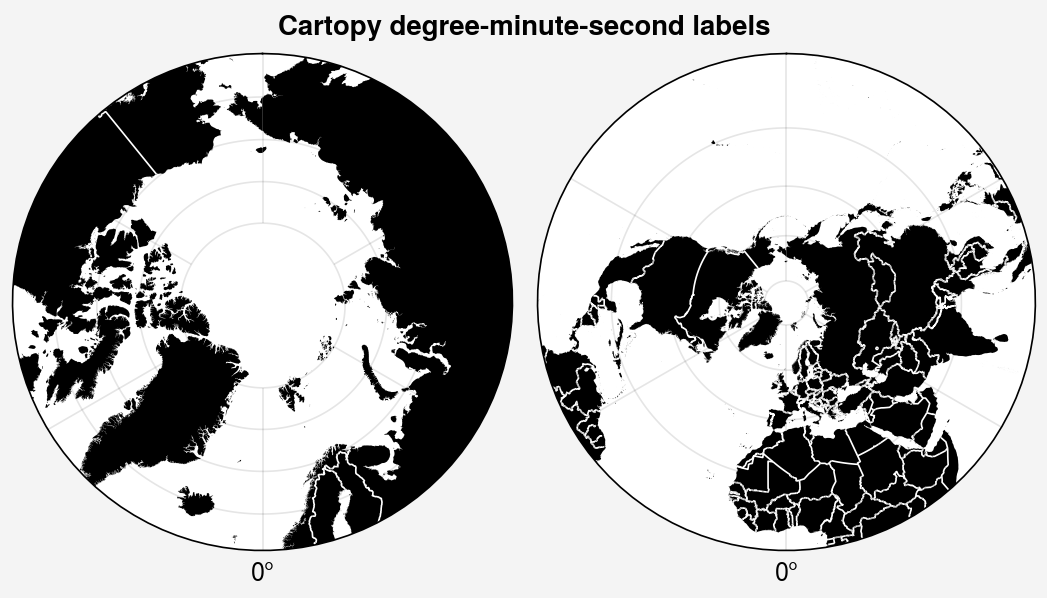

In [33]:
# Zooming in with cartopy degree-minute-second labels
pplt.rc.reso = 'hi'
fig = pplt.figure(refwidth=2.5)
ax = fig.subplot(121, proj='npstere')
ax.format(lonlim=(-7.5, 2), boundinglat=60)
ax = fig.subplot(122, proj='npstere')
ax.format(lonlim=(-6, -2), latlim=(70, 90))
fig.format(
    land=True, labels=True,
    borders=True, borderscolor='white',
    suptitle='Cartopy degree-minute-second labels',
)
pplt.rc.reset()

In [19]:
# dx = np.mean(np.diff(xc))
# dy = np.mean(np.diff(yc))

In [6]:
min_x = df_ift.x_stere.min()
max_x = df_ift.x_stere.max()
min_y = df_ift.y_stere.min()
max_y = df_ift.y_stere.max()

x_bins = np.arange(min_x, max_x, 25e3)
y_bins = np.arange(min_y, max_y, 25e3)
xc = 0.5*(x_bins[1:] + x_bins[:-1])
yc = 0.5*(y_bins[1:] + y_bins[:-1])
X, Y = np.meshgrid(xc, yc)


In [43]:
# compute the bin-mean velocity anomaly compared to the NSIDC grid



In [7]:
# Select data from 25 km bins for IFT and for NSIDC to compute monthly means
# 
import scipy.stats as stats
import pyproj
crs0 = pyproj.CRS('WGS84')
crs1 = pyproj.CRS('epsg:3413')
transformer_pstere = pyproj.Transformer.from_crs(crs1, crs_to=crs0, always_xy=True)
 
lon_grid, lat_grid = transformer_pstere.transform(np.ravel(X), np.ravel(Y))
lon_grid = np.reshape(lon_grid, X.shape)
lat_grid = np.reshape(lat_grid, Y.shape)

u_data = {}
v_data = {}
hist = {}
diffs_mean = {}
diffs_u = {}
diffs_v = {}

for month in [4, 5, 6, 7]:
    u_data[month] = {}
    v_data[month] = {}
    hist[month] = {}
    for label, suffix in zip(['IFT', 'NSIDC'], ['', '_nsidc']):
        sel = (df_ift.datetime.dt.month == month) & (df_ift['u'].notnull())
        x = df_ift.x_stere
        y = df_ift.y_stere
        u = df_ift['u' + suffix]
        v = df_ift['v' + suffix]
        
        hist2d = np.histogram2d(df_ift.loc[sel, 'x_stere'],
                       df_ift.loc[sel, 'y_stere'],
                      bins=[x_bins, y_bins])
        df_hist = pd.DataFrame(hist2d[0], index=xc, columns=yc)
        hist[month] = df_hist
        
        u_mean, xedges, yedges, binnumber = stats.binned_statistic_2d(
            x[sel], y[sel], values=u[sel], statistic='mean', 
            bins=[x_bins, y_bins])
        v_mean, xedges, yedges, binnumber = stats.binned_statistic_2d(
            x[sel], y[sel], values=v[sel], statistic='mean', 
            bins=[x_bins, y_bins])
        U_nps = u_mean.T * np.sin(np.deg2rad(lon_grid + 45)) + v_mean.T * np.cos(np.deg2rad(lon_grid + 45))
        V_nps = v_mean.T * np.cos(np.deg2rad(lon_grid + 45)) - u_mean.T * np.sin(np.deg2rad(lon_grid + 45))
        u_data[month][label] = pd.DataFrame(U_nps.T, index=xc, columns=yc)
        v_data[month][label] = pd.DataFrame(V_nps.T, index=xc, columns=yc)

    diff_u = df_ift['u'] - df_ift['u_nsidc']
    diff_v = df_ift['v'] - df_ift['v_nsidc']
    diff_norm = np.sqrt(diff_u**2 + diff_v**2)
    dn, xedges, yedges, binnumber = stats.binned_statistic_2d(
                x[sel], y[sel], values=diff_norm[sel], statistic='mean', 
                bins=[x_bins, y_bins])
    diffs_mean[month] = pd.DataFrame(dn, index=xc, columns=yc)
    du, xedges, yedges, binnumber = stats.binned_statistic_2d(
                x[sel], y[sel], values=diff_u[sel], statistic='mean', 
                bins=[x_bins, y_bins])
    dv, xedges, yedges, binnumber = stats.binned_statistic_2d(
                x[sel], y[sel], values=diff_v[sel], statistic='mean', 
                bins=[x_bins, y_bins])
    U_nps = du.T * np.sin(np.deg2rad(lon_grid + 45)) + dv.T * np.cos(np.deg2rad(lon_grid + 45))
    V_nps = dv.T * np.cos(np.deg2rad(lon_grid + 45)) - du.T * np.sin(np.deg2rad(lon_grid + 45))
    diffs_u[month] = pd.DataFrame(U_nps.T, index=xc, columns=yc)
    diffs_v[month] = pd.DataFrame(V_nps.T, index=xc, columns=yc)

(array([23., 82., 83., 46., 31., 24.,  7.,  8.,  3.,  1.]),
 array([0.00381105, 0.04119624, 0.07858143, 0.11596663, 0.15335182,
        0.19073702, 0.22812221, 0.2655074 , 0.3028926 , 0.34027779,
        0.37766298]),
 <BarContainer object of 10 artists>)

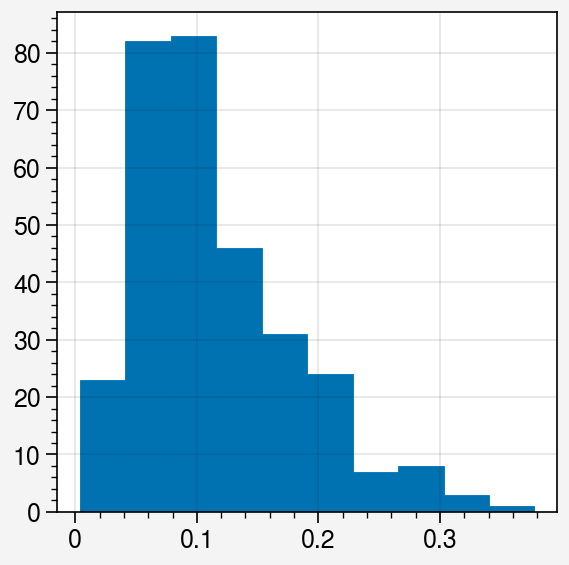

In [8]:
fig, ax = pplt.subplots()
ax.hist(np.ravel(diffs_mean[month]))

In [19]:
0.83e6 + 150e3

980000.0

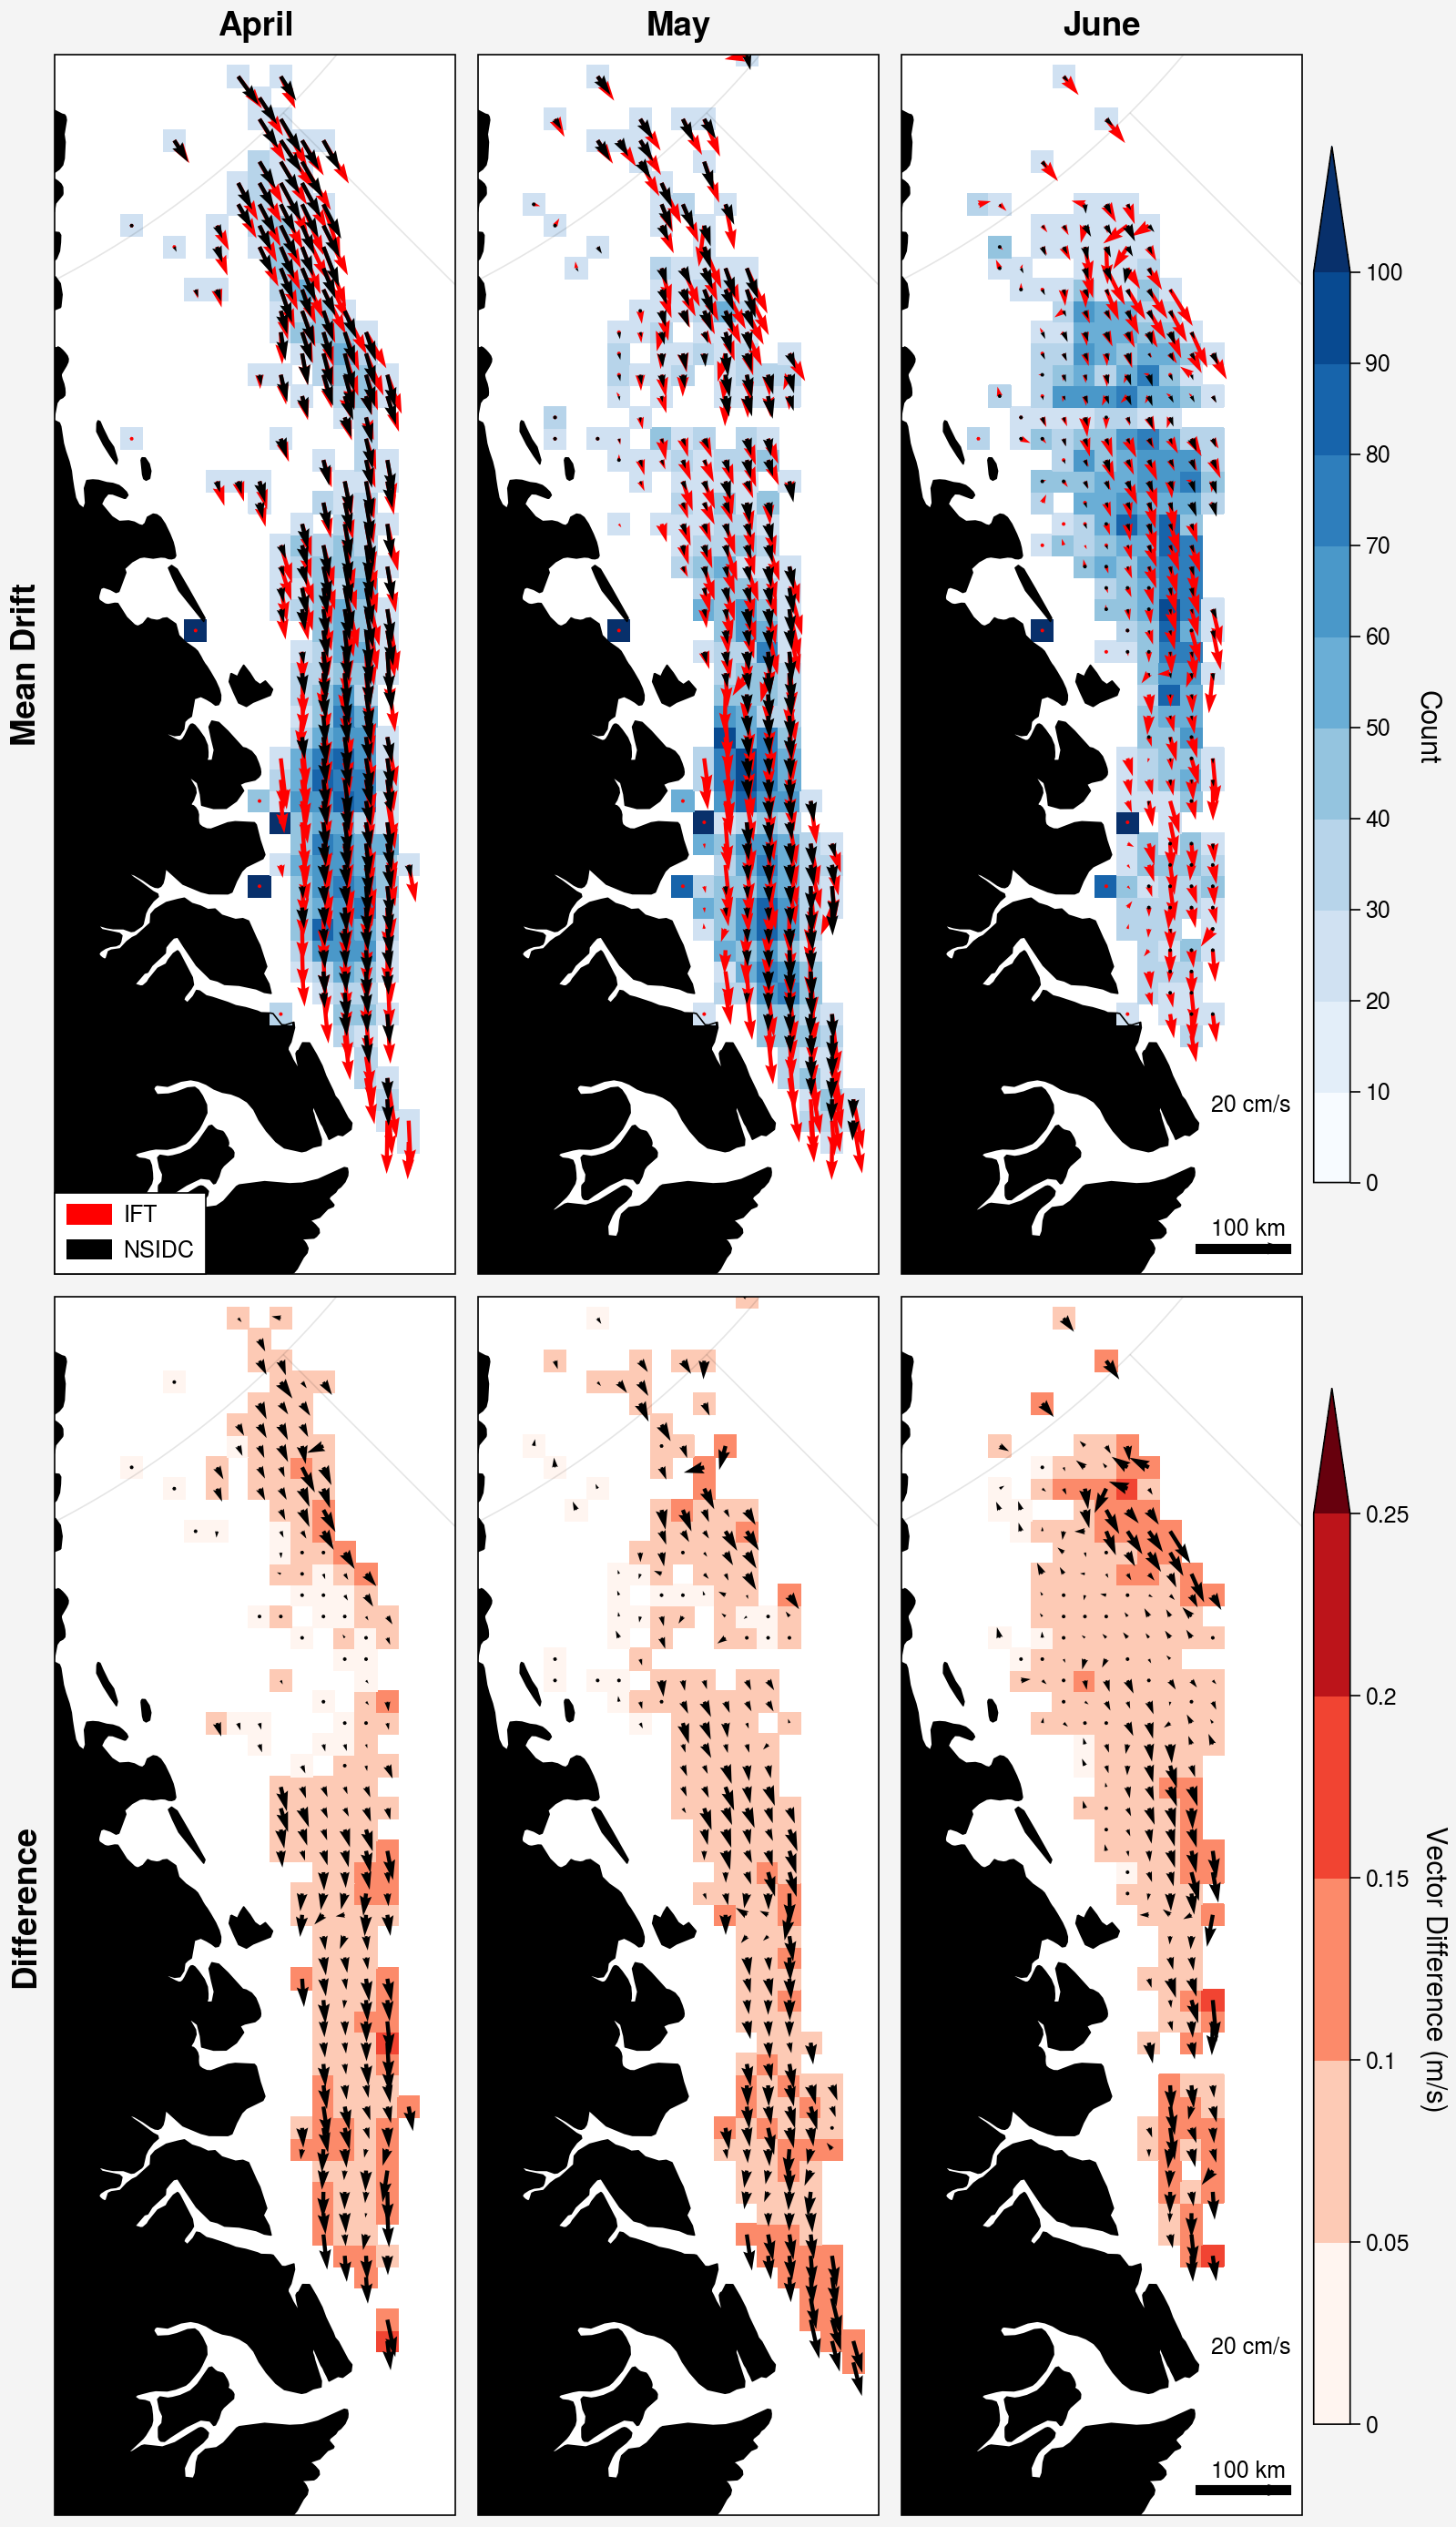

In [43]:
import cartopy.crs as ccrs
pplt.rc.reso = 'med'
pplt.rc['cartopy.circular'] = False

crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, axs = pplt.subplots(width=8, proj='npstere',
                         proj_kw={'lon_0': -45}, ncols=3, nrows=2, share=False)

for ax in axs:
    ax.set_extent([0.5e6, 0.97e6, -2.13e6, -0.7e6], crs=crs)  
    ax.format(land=True, coast=True, 
           landzorder=0, landcolor='k', facecolor='w')
for ax in axs[:, -1]:
    ax.plot([0.95e6 - 100e3, 0.95e6], [-2.1e6, -2.1e6], lw=4, color='k', zorder=3, transform=crs)
    ax.text(0.89e6, -2.15e6, '100 km', color='k')

    ax.quiver(0.89e6, -2.1e6, 0.2, 0, lw=4, color='k', scale=1.5, width=1/100, zorder=3, transform=crs)
    ax.text(0.89e6, -2e6, '20 cm/s', color='k')


for col, month in zip([0, 1, 2], [4, 5, 6]):

    idx_data = hist[month] > 20
    
    # Plot count of IFT observations
    c0 = axs[0, col].pcolor(lon_grid, lat_grid, hist[month].where(idx_data).T.values, vmin=0, vmax=100,
           transform=ccrs.PlateCarree(), cmap='blues', extend='max')
    
    axs[0, col].quiver(lon_grid, lat_grid, u_data[month]['IFT'].where(idx_data).T.values, v_data[month]['IFT'].where(idx_data).T.values,
               transform=ccrs.PlateCarree(), color='r', scale=1.5, width=1/100, label='IFT')
    axs[0, col].quiver(lon_grid, lat_grid, u_data[month]['NSIDC'].where(idx_data).T.values, v_data[month]['NSIDC'].where(idx_data).T.values,
               transform=ccrs.PlateCarree(), color='k', scale=1.5, width=1/100, label='NSIDC')
    
    axs[0, 0].legend(loc='ll', ncols=1, alpha=1, lw=2)
    
    c1 = axs[1, col].pcolor(lon_grid, lat_grid, diffs_mean[month].where(idx_data).T.values, vmin=0, vmax=0.3,
           transform=ccrs.PlateCarree(), cmap='reds', extend='max', N=7)
    axs[1, col].quiver(lon_grid, lat_grid, diffs_u[month].where(idx_data).T.values, diffs_v[month].where(idx_data).T.values,
               transform=ccrs.PlateCarree(), color='k', scale=1.5, width=1/100)
        
axs[0, col].colorbar(c0, loc='r', shrink=0.85, label='Count', labelsize=11)
axs[1, col].colorbar(c1, loc='r', shrink=0.85, label='Vector Difference (m/s)', labelsize=11)
axs.format(leftlabels = ['Mean Drift','Difference'],
           toplabels=['April', 'May', 'June'], fontsize=12)


In [120]:
0.05*60*60*24 / 1000 # km/day ---- 5 cm/s uncertainty is 4.32 km/day uncertainty

4.32

What I want to show in the fluctuating velocity section is whether the IFT data does tend to be faster than the NSIDC ice motion product during the early part of the year, but more so, whether the IFT data has higher variance. The best fit normal distribution does OK, maybe a t-distribution would be better. Could check the fit. I've taken the 5D mean of the NSIDC data to get mean sea ice direction, then I've centered the distributions by subtracting the mean across all years. 

For the comparison with the normal distribution, I can use the K-S test since I've used it elsewhere. Question is whether the velocity anomalies in the along and across track directions tend to be normally distributed - testing for significance. Interpreting the tendency toward 0 mean bias -- perhaps a shift toward more wind-driven variability?

I'll need a statistical test to check whether the mean is different between the IFT and NSIDC data.



# Correlation between IFT and NSIDC in the along-track and cross-track directions

31D U_along 10.487 cm/s
15D U_along 10.83 cm/s
5D U_along 11.199 cm/s
31D U_fluctuating 7.177 cm/s
15D U_fluctuating 7.475 cm/s
5D U_fluctuating 7.829 cm/s
31D U_along 8.158 cm/s
15D U_along 8.093 cm/s
5D U_along 7.992 cm/s
31D U_fluctuating 6.012 cm/s
15D U_fluctuating 6.124 cm/s
5D U_fluctuating 6.278 cm/s


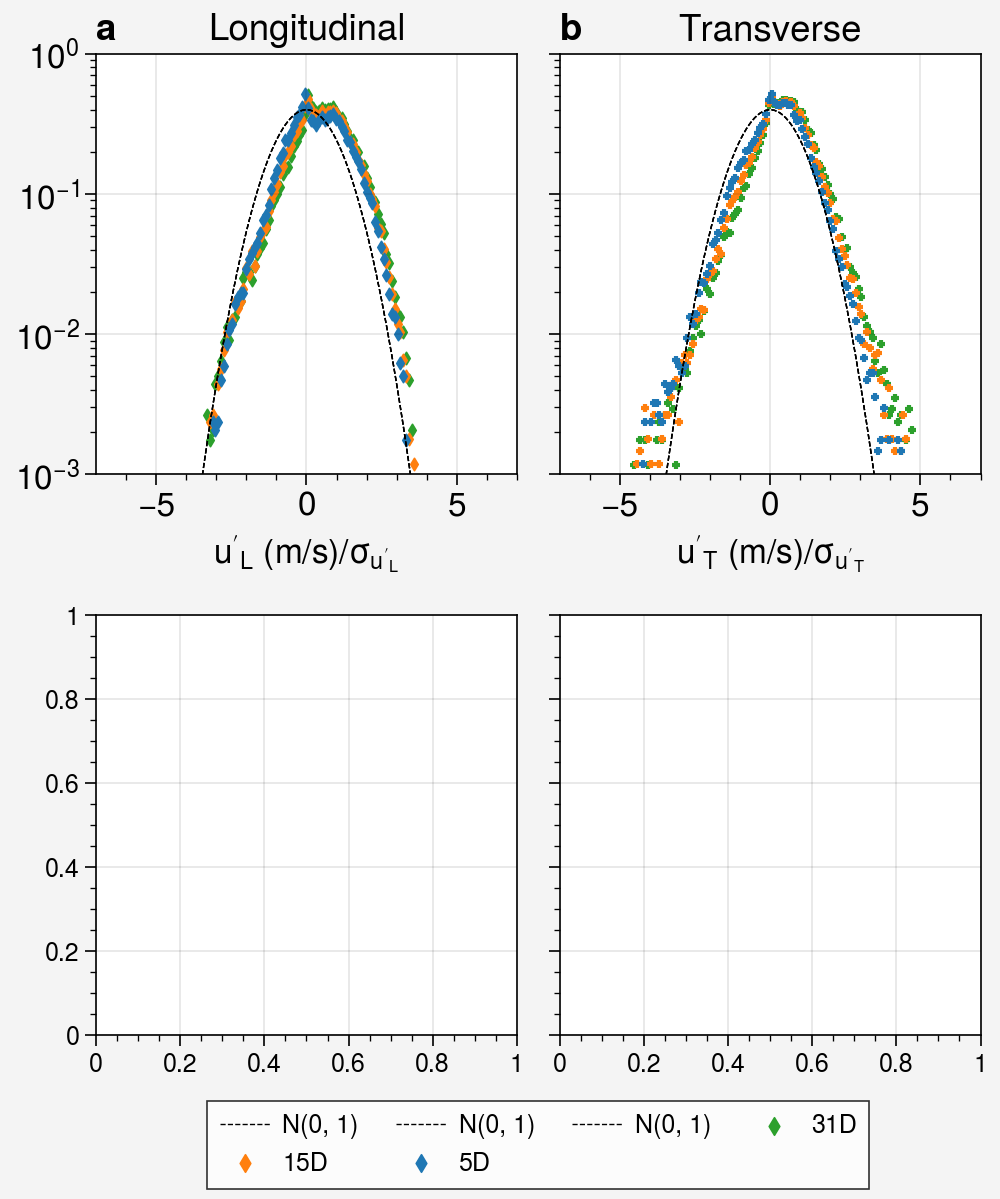

In [110]:

fig, axes = pplt.subplots(ncols=2, nrows=2, width="5in", sharex=False)
normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)
for axs, data_dict in zip([axes[0,:], axs[1,:]],
                          [results, results_anomalies]):
    
    for ax, symb, var in zip(axs, ['d', '+'], ['U_along', 'U_fluctuating']):
        for tau, c in zip(['31D', '15D', '5D'], ['tab:green', 'tab:orange', 'tab:blue']):
            u = data_dict[tau][var]
            ustd = data_dict[tau][var].std()
            print(tau, var, np.round(ustd*100, 3), 'cm/s')   
            pdf, x_bins = np.histogram(u/ustd, bins=np.linspace(-7, 7, 151), density=True)
            x_center = 1/2*(x_bins[1:] + x_bins[:-1])
            if 'along' in var:
                label = tau
                label_pdf = 'N(0, 1)'
            else:
                label = ''
                label_pdf = ''
            ax.scatter(x_center,
                       pdf, marker=symb,
                       color=c,  label=label, ms=10) 
         
            ax.plot(x_center, normal_dist(x_center), marker='', lw=0.5, color='k', ls='--', label=label_pdf)
            ax.format(yscale='log', ylim=(1e-3, 1), xlim=(-7, 7),
               yformatter='log', suptitle='', fontsize=12, abc=True)

axes[0].format(title='Longitudinal', xlabel='$u\'_L$ (m/s)/$\sigma_{u\'_L}$')
axes[1].format(title='Transverse', xlabel='$u\'_T$ (m/s)/$\sigma_{u\'_T}$')
    # axs[0].legend(loc='ul', ncols=1)
fig.legend(loc='b', ncols=4, ms=20)
# fig.save('../figures/fig03_velocity_distribution_tau.pdf', dpi=300)

I separated the fluctuating velocity components by sea ice concentration. I need to revisit the sea ice concentration data, since I think I might be dropping data that has too low of SIC in the flagging process. Likely, the average velocities are not defined in regions with low sea ice concentration, so they are getting dropped at that point. There are a small number of outliers at low edge distances. I see more negative outliers than positive, which contradicts what I was seeing earlier. Some testable hypothesis:
- The distribution has an assymetric peak, and symmetric tails, which could suggest a slight direction bias between the tracked floes and the NSIDC ice motion vectors
- Large fluctuating velocities are less common as you go further from the ice edge, however, the bulk of the observations are within 250 km of the ice edge, so there are few floes available to test this hypothesis more deeply
- Negative outliers for high sea ice concentrations are nearly all in May and April, while the large outliers for moderate SIC are in June and July
- Could report the kurtosis of the distribution

There's likely an issue with where we have ice floe velocity measurements at a broad range of SIC but that we don't have NSIDC ice motion vectors for all those sites.


In [266]:
results['5D'].columns

Index(['datetime', 'floe_id', 'u', 'v', 'u_mean', 'v_mean', 'u_along',
       'v_along', 'u_across', 'v_across', 'U_fluctuating', 'U_along'],
      dtype='object')

In [264]:
df = results['5D'].copy()
edge_bins = np.arange(0, 800, 25)
df['edge_bin'] = np.digitize(df.edge_dist_km, bins=edge_bins)
df_stdev = pd.concat({'sigma_ut': df[['edge_bin', 'U_fluctuating']].groupby('edge_bin').std(),
                      'sigma_ul': df[['edge_bin', 'U_along']].groupby('edge_bin').std(),
              'n': df[['edge_bin', 'U_fluctuating']].groupby('edge_bin').count(),
             'd': df[['edge_bin', 'edge_dist_km']].groupby('edge_bin').mean()}, axis=1)
df_stdev.columns = pd.Index(['sigma_ut', 'sigma_ul', 'n', 'd'])

length_bins = np.arange(0, 50, 2)
df['length_scale'] = df['area_km2']**0.5
df['length_bin'] = np.digitize(df.length_scale, bins=length_bins)
df_stdev_fsd = pd.concat({'sigma_ut': df[['length_bin', 'U_fluctuating']].groupby('length_bin').std(),
                      'sigma_ul': df[['length_bin', 'U_along']].groupby('length_bin').std(),
              'n': df[['length_bin', 'U_fluctuating']].groupby('length_bin').count(),
             'L': df[['length_bin', 'length_scale']].groupby('length_bin').mean()}, axis=1)
df_stdev_fsd.columns = pd.Index(['sigma_ut', 'sigma_ul', 'n', 'L'])

AttributeError: 'DataFrame' object has no attribute 'edge_dist_km'

5D U_along 6.848 cm/s
5D U_fluctuating 4.068 cm/s


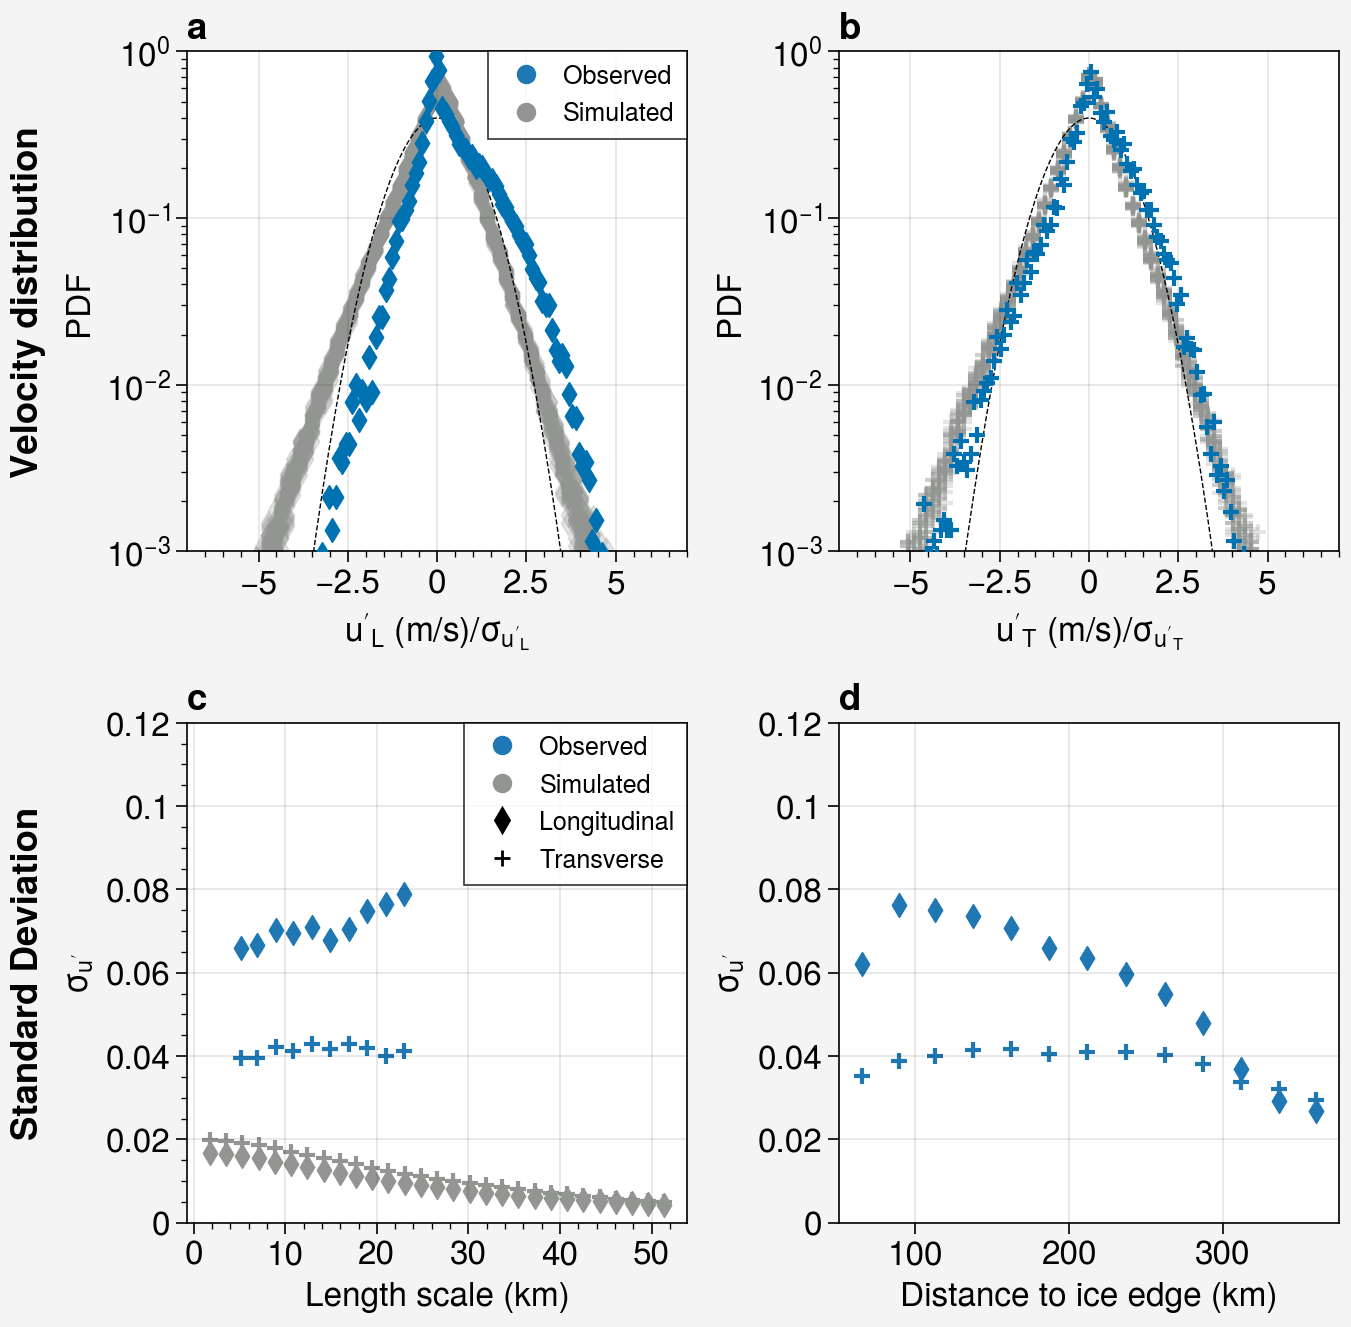

In [263]:
length_bins = np.arange(0, 50, 2)
df['length_scale'] = df['area_km2']**0.5
df['length_bin'] = np.digitize(df.length_scale, bins=length_bins)
df_stdev_fsd = pd.concat({'sigma_ut': df[['length_bin', 'U_fluctuating']].groupby('length_bin').std(),
                      'sigma_ul': df[['length_bin', 'U_along']].groupby('length_bin').std(),
              'n': df[['length_bin', 'U_fluctuating']].groupby('length_bin').count(),
             'L': df[['length_bin', 'length_scale']].groupby('length_bin').mean()}, axis=1)
df_stdev_fsd.columns = pd.Index(['sigma_ut', 'sigma_ul', 'n', 'L'])

R = sim_std_dev['u_along (m/s)'].index
L = np.sqrt(np.pi)*R


fig, axs = pplt.subplots(ncols=2, nrows=2, share=False)

normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)
for ax, symb, var in zip([axs[0], axs[1]], ['d', '+'], ['U_along', 'U_fluctuating']):
    ustd = df[var].std()
    u = df[var]
    print(tau, var, np.round(ustd*100, 3), 'cm/s')   
    pdf, x_bins = np.histogram(u/ustd, bins=np.linspace(-7, 7, 151), density=True)
    x_center = 1/2*(x_bins[1:] + x_bins[:-1])
    if 'along' in var:
        label_pdf = 'N(0, 1)'
    else:
        label_pdf = ''

    ax.scatter(x_center, pdf, marker=symb, label='', zorder=5) 
    ax.plot(x_center, normal_dist(x_center), marker='',
            lw=0.5, color='k', ls='--', label=label_pdf, zorder=1)
    
# The normalization in np.histogram is not the same as the normalization in
# Minki's matlab routine, to bring them to the same convention, we need to divide by
# the bin spacing. 
dx = np.diff(sim_uacross.index)[0]
   
for col in sim_ualong.columns:
    axs[0].scatter(sim_ualong.index, sim_ualong.loc[:, col]/dx, color='gray',
                m='d', alpha=0.25, label='', zorder=0)
    axs[1].scatter(sim_uacross.index, sim_uacross.loc[:, col]/dx, color='gray',
                alpha=0.25, m='+',  label='', zorder=0)
    
axs[0].format(title='', xlabel='$u\'_L$ (m/s)/$\sigma_{u\'_L}$',
              yscale='log', ylim=(1e-3, 1), xlim=(-7, 7),
              yformatter='log', ylabel='PDF')
axs[1].format(title='', xlabel='$u\'_T$ (m/s)/$\sigma_{u\'_T}$',
              yscale='log', ylim=(1e-3, 1), xlim=(-7, 7),
              yformatter='log', ylabel='PDF')

# axs[0].legend(loc='ul', ncols=1)
# fig.legend(loc='b', ncols=4, ms=6)

# fig.save('../figures/fig_01v2_alongtrack_crosstrack_velocity_anomaly.pdf', dpi=300)

idx = df_stdev_fsd.n > 300
ax = axs[2]
ax.scatter(df_stdev_fsd.loc[idx, 'L'].values,
        df_stdev_fsd.loc[idx, 'sigma_ul'].values,
        marker='d', label='', color='tab:blue')
ax.scatter(df_stdev_fsd.loc[idx, 'L'].values,
        df_stdev_fsd.loc[idx, 'sigma_ut'].values,
        marker='+', label='', color='tab:blue')
ax.scatter(L, sim_std_dev['u_along (m/s)'],
           marker='d', label='', color='gray')
ax.scatter(L, sim_std_dev['u_across (m/s)'],
           marker='+', label='', color='gray')



idx = df_stdev.n > 300
axs[3].scatter(df_stdev.loc[idx, 'd'].values,
               df_stdev.loc[idx, 'sigma_ul'].values, marker='d', color='tab:blue')
axs[3].scatter(df_stdev.loc[idx, 'd'].values,
               df_stdev.loc[idx, 'sigma_ut'].values, marker='+', color='tab:blue')
axs[3].format(ylim=(0, 0.12), ytickminor=False, xtickminor=False,
         ylabel='$\sigma_{u\'}$', xlabel='Distance to ice edge (km)', fontsize=12)

l = ['Observed', 'Simulated', 'Longitudinal', 'Transverse']
h = [ax.plot([],[], marker=m, color=c, lw=0) for m, c in zip(['o', 'o', 'd', '+'],
                                                       ['tab:blue', 'gray', 'k', 'k'])]

axs[0].legend(h[0:2], l[0:2], ncols=1)

axs[2].format(ylim=(0, 0.12))
axs[3].format(ylim=(0, 0.12))
ax.format(xlabel='Length scale (km)', ylabel='$\sigma_{u\'}$', title='')
ax.legend(h, l, loc='ur', ncols=1)
fig.format(abc=True, fontsize=12, leftlabels=['Velocity distribution', 'Standard Deviation'])
fig.save('../figures/fig04_velocity_obs_sim.pdf', dpi=300)

In [60]:
print('Unfiltered', df_ift.shape[0])
print('Filtered', df_ift.loc[df_ift.qc_flag==0].shape[0])
print('With SIC', df_ift.loc[(df_ift.qc_flag==0) & df_ift.nsidc_sic.notnull()].shape[0])
print('With NSIDC Ice Motion', df_ift.loc[(df_ift.qc_flag==0) & df_ift.u_nsidc.notnull()].shape[0])
print('With NSIDC Ice Motion & SIC', df_ift.loc[(df_ift.qc_flag==0) & (df_ift.u_nsidc.notnull() & df_ift.nsidc_sic.notnull()) ].shape[0])

Unfiltered 64435
Filtered 0
With SIC 0
With NSIDC Ice Motion 0
With NSIDC Ice Motion & SIC 0


In [62]:
df_ift

datetime     floe_id  longitude  latitude       x_stere  \
0    2003-04-01 12:00:00  2003_00002  -19.12710  75.92290  668678.10000   
1    2003-04-02 12:00:00  2003_00002  -19.12528  75.92190  668769.81490   
2    2003-04-03 12:00:00  2003_00002  -19.12710  75.92290  668678.10000   
3    2003-04-04 12:00:00  2003_00002  -19.12710  75.92290  668678.10000   
4    2003-04-05 12:00:00  2003_00002  -19.12719  75.92314  668664.71665   
...                  ...         ...        ...       ...           ...   
5128 2020-08-08 12:00:00  2020_09862  -10.30608  82.27038  477296.47203   
5129 2020-08-06 12:00:00  2020_09863  -13.89342  80.24396  547266.94571   
5130 2020-08-07 12:00:00  2020_09863  -13.09213  80.30746  556238.57942   
5131 2020-08-06 12:00:00  2020_09872   -6.17890  80.37661  654995.40457   
5132 2020-08-07 12:00:00  2020_09872   -5.42021  80.37312  665958.32961   

           y_stere        area  perimeter  axis_major_length  \
0    -1.378746e+06  1514.00000  189.80000           88.40000   
1    -1.378823e+06  1526.72556  194.16305           89.85435   
2    -1.378746e+06  1514.00000  189.80000           88.40000   
3    -1.378746e+06  1514.00000  189.80000           88.40000   
4    -1.378725e+06  1510.68963  189.75271           88.11625   
...            ...         ...        ...                ...   
5128 -6.894606e+05   620.78078  104.02171           35.98747   
5129 -9.069813e+05   566.54857  102.06114           34.77200   
5130 -8.933627e+05   539.00995  100.89954           33.89985   
5131 -8.140372e+05   304.57714   73.82800           25.15314   
5132 -8.055842e+05   306.00536   76.49878           25.79939   

      axis_minor_length  ...  u_along  v_along  u_across  v_across  \
0              23.00000  ...      NaN      NaN       NaN       NaN   
1              23.00000  ...      NaN      NaN       NaN       NaN   
2              23.00000  ...      NaN      NaN       NaN       NaN   
3              23.00000  ...      NaN      NaN       NaN       NaN   
4              23.04729  ...      NaN      NaN       NaN       NaN   
...                 ...  ...      ...      ...       ...       ...   
5128           23.30313  ...      NaN      NaN       NaN       NaN   
5129           22.77657  ...      NaN      NaN       NaN       NaN   
5130           22.00054  ...      NaN      NaN       NaN       NaN   
5131           16.63429  ...      NaN      NaN       NaN       NaN   
5132           16.50069  ...      NaN      NaN       NaN       NaN   

      U_fluctuating  U_along  u_nsidc_along  v_nsidc_along  u_nsidc_across  \
0               NaN      NaN            NaN            NaN             NaN   
1               NaN      NaN            NaN            NaN             NaN   
2               NaN      NaN            NaN            NaN             NaN   
3               NaN      NaN            NaN            NaN             NaN   
4               NaN      NaN            NaN            NaN             NaN   
...             ...      ...            ...            ...             ...   
5128            NaN      NaN         0.0135         0.0135         -0.0135   
5129            NaN      NaN            NaN            NaN             NaN   
5130            NaN      NaN         0.0165         0.0165         -0.0095   
5131            NaN      NaN         0.0245         0.0245          0.0345   
5132            NaN      NaN         0.0130         0.0130          0.0060   

      v_nsidc_across  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
5128          0.0135  
5129             NaN  
5130          0.0095  
5131         -0.0345  
5132         -0.0060  

[64435 rows x 45 columns]

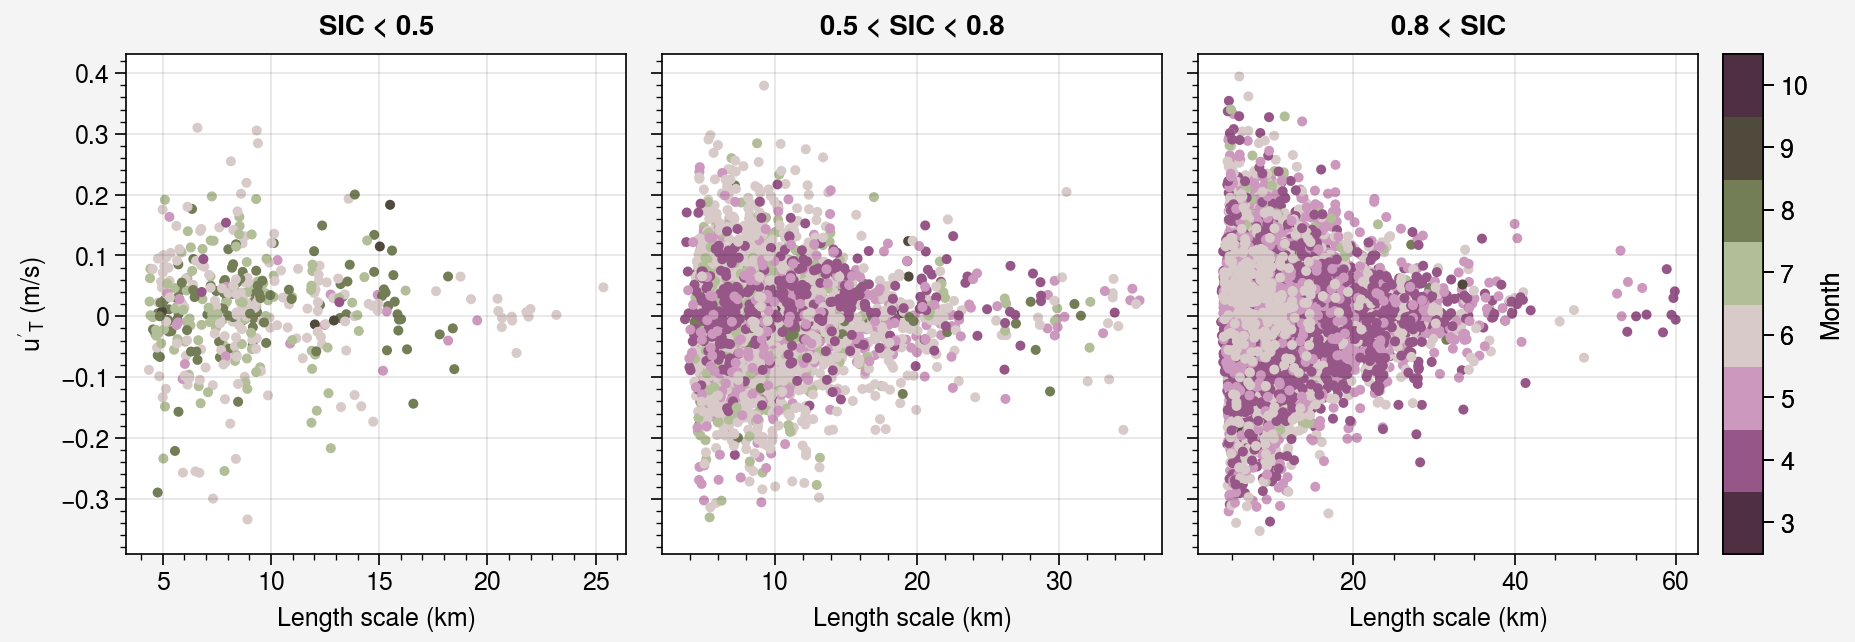

In [524]:
df = results_anomalies['5D']
fig, ax = pplt.subplots(ncols=3, sharex=False)
sic_idx = df.sea_ice_concentration < 0.5
c = ax[0].scatter(df.loc[sic_idx, 'floe_size']**0.5, df.loc[sic_idx, 'U_fluctuating'], m='.',
              c=df.loc[sic_idx, 'datetime'].dt.month, cmap='bamO', vmin=2.5, vmax=10.5, N=8)
sic_idx = df.sea_ice_concentration > 0.5
sic_idx = sic_idx & (df.sea_ice_concentration < 0.8)
ax[1].scatter(df.loc[sic_idx, 'floe_size']**0.5, df.loc[sic_idx, 'U_fluctuating'], m='.',
              c=df.loc[sic_idx, 'datetime'].dt.month, cmap='bamO', vmin=2.5, vmax=10.5, N=8)
sic_idx = df.sea_ice_concentration > 0.8
ax[2].scatter(df.loc[sic_idx, 'floe_size']**0.5, df.loc[sic_idx, 'U_fluctuating'], m='.',
              c=df.loc[sic_idx, 'datetime'].dt.month, cmap='bamO', vmin=2.5, vmax=10.5, N=8)
fig.colorbar(c, loc='r', label='Month')
ax.format(toplabels=['SIC < 0.5', '0.5 < SIC < 0.8', '0.8 < SIC'])
ax.format(ylabel='$u\'_T$ (m/s)', xlabel='Length scale (km)')

From the scatterplots, we can see a possible month dependence, and a pretty clear length scale dependence. The length scale dependence is harder to see in the low sea ice concentration due to the smaller number of observations. It appears to me (I aim to quantify this with percentiles) that there is a change in the scale of the distribution with increasing floe length scale. There may be differences between months in the number of floes at each length scale that may make it difficult to compare, so a bootstrap approach would likely be useful here.

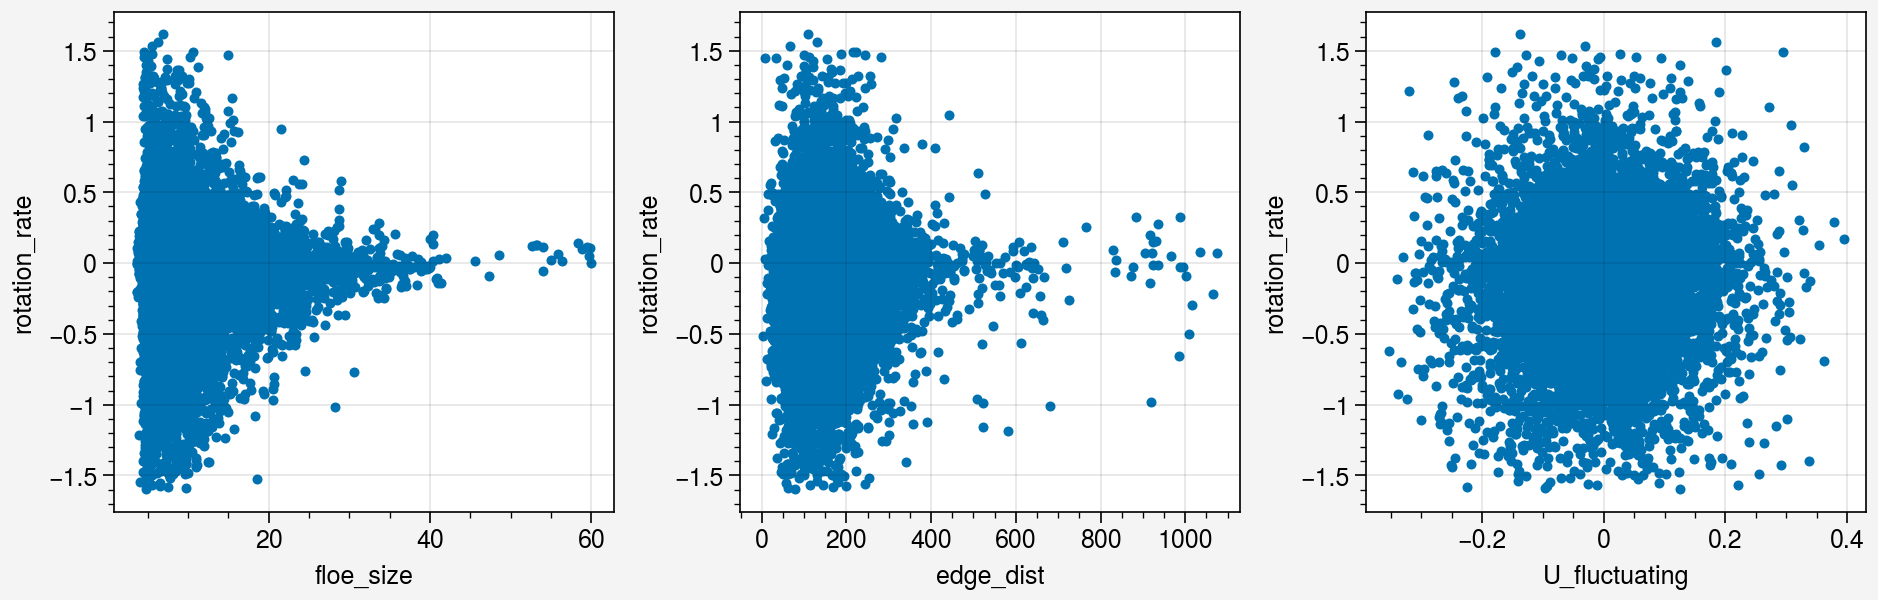

In [525]:
fig, ax = pplt.subplots(ncols=3, share=False)
ax[0].scatter(results_anomalies['5D']['floe_size']**0.5, results_anomalies['5D']['rotation_rate'], 
           marker='.')
ax[1].scatter(results_anomalies['5D']['edge_dist']/1e3, results_anomalies['5D']['rotation_rate'], marker='.')
ax[2].scatter(results_anomalies['5D']['U_fluctuating'], results_anomalies['5D']['rotation_rate'], marker='.')

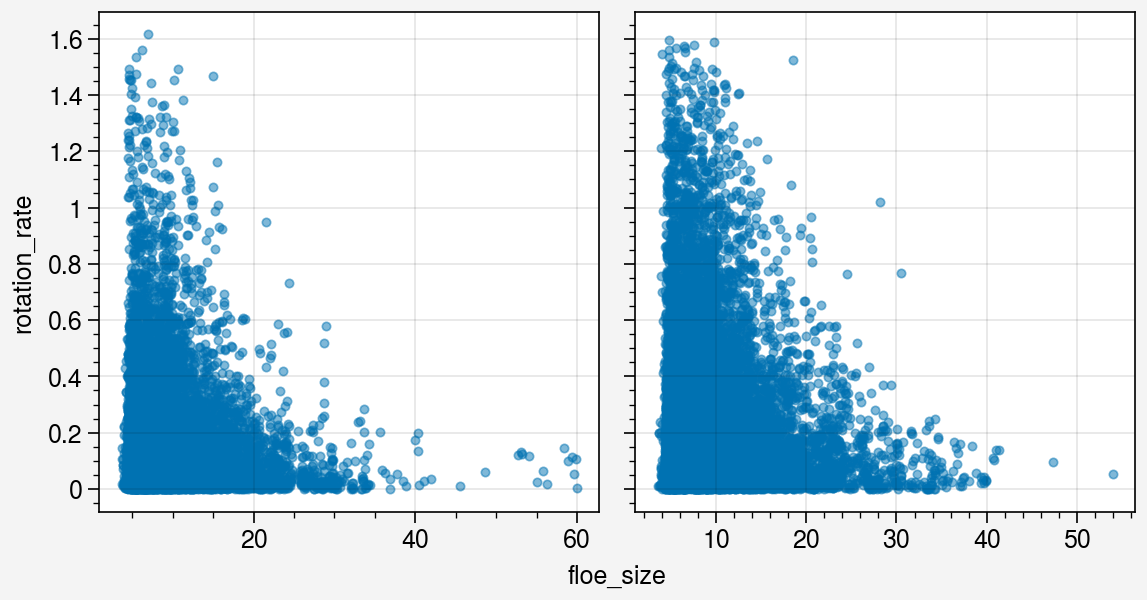

In [526]:
fig, ax = pplt.subplots(ncols=2, share=True)
anticyclonic = results_anomalies['5D']['rotation_rate'].where(results_anomalies['5D']['rotation_rate'] > 0)
cyclonic = results_anomalies['5D']['rotation_rate'].where(results_anomalies['5D']['rotation_rate'] < 0)
ax[0].scatter(results_anomalies['5D']['floe_size']**0.5, anticyclonic, 
           marker='.', alpha=0.5)
ax[1].scatter(results_anomalies['5D']['floe_size']**0.5, -cyclonic, 
           marker='.', alpha=0.5)


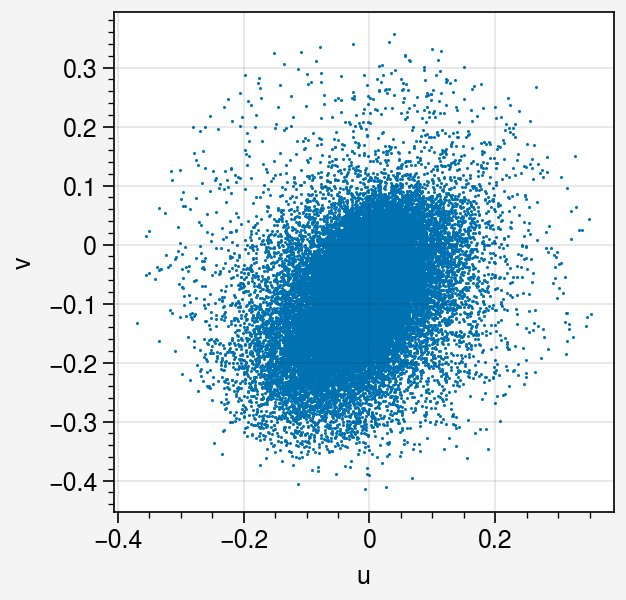

In [527]:
large_fluctuations = df_filtered.loc[np.abs(df_filtered.U_fluctuating) > 0.5]
fig, ax = pplt.subplots()
# ax.scatter(df_ift.u, df_ift.v, marker='.', ms=1)
ax.scatter(df_filtered.u, df_filtered.v, m='.', ms=1)
ax.scatter(large_fluctuations.u, large_fluctuations.v)

If we separate out the effects of edge distance, do we still see a rotation rate effect in the floe sizes?

The goal is to quantify the joint relationship between rotation rate, edge distance, and floe size, as the three appear to be mutually correlated. However, it is not clear how we should do this. I suspect that the thing we want to do is to quantify the spread of the distribution. The circular standard deviation is probably the right way to go but there are some questions I have about the dependence on the choice of high and low thresholds. 

In [452]:
df_ift['edge_dist'].max()


2109901.0

In [528]:
from scipy.stats import circmean, circstd


Using the regular standard deviation, there appears to be an effect with the length scale within edge distance groups, but oddly, I don't see the effect when using the circular standard deviation.
When we bin the rotation rate observations by the distance to the ice edge, we find that the signal is noisy, but that there does appear to be some kind of effect. I'm not sure what the appropriate statistic is here. While we still need to figure out the appropriate method to test statistical significance. 

The results are non-intuitive and depend on the choice of high and low angles. I need to think carefully about this so that we aren't mislead. However, it is extremely clear in the data that there is a dependency of some sort.

In [510]:
# I think there's an error in the edge distance calculation, since there are data points at 70 latitude registering as
# over 400 km from the ice edge. Let's take a look at those again.

In [534]:
df_filtered.loc[df_filtered.edge_dist > 400e3].sea_ice_concentration

2003    0.96
2003    1.00
2003    0.89
2003    0.92
2003    0.89
        ... 
2020    0.70
2020    0.78
2020    0.71
2020    0.76
2020    0.52
Name: sea_ice_concentration, Length: 322, dtype: float64

## Considering the effect of the wind

Can the velocity fluctuatings be explained by the wind? We consider the effect of the wind based on the ERA5 daily average wind reanalysis (itself an estimate). We employ a linear free drift model $$u'_{ice} = \alpha \exp^{-i\theta} U_{wind} + \overline{U}_{ice}$$. To find the best fit for the parameters $\alpha$ and $\theta$, we take a random sample of $n=1000$ observations, calculate the empirical drift speed ratio $\alpha$ and turning angle $\theta$ relative to the velocity perturbation $u'$, and calculate the expected value of $\alpha$ and $\theta$. (For $\theta$, the expected value uses a circular mean).

In [31]:
import metpy.calc as mcalc
from metpy.units import units

In [188]:
df_filtered.reset_index(inplace=True, drop=True)
up = df_filtered['u'] - df_filtered['u5D_nsidc'] + 1j*(df_filtered['v'] - df_filtered['v5D_nsidc'])

# up = df_filtered['u'] + 1j*df_filtered['v']
uw = df_filtered['u_wind'] + 1j*df_filtered['v_wind']

In [189]:
wind_bearing = mcalc.wind_direction(df_filtered['u_wind'].values * units('m/s'),
                                    df_filtered['v_wind'].values * units('m/s'), convention='to')
ice_bearing = mcalc.wind_direction(np.real(up) * units('m/s'),
                                   np.imag(up) * units('m/s'), convention='to')
delta = np.deg2rad(ice_bearing.magnitude) - np.deg2rad(wind_bearing.magnitude)
turning_angle = pd.Series(np.rad2deg(np.arctan2(np.sin(delta), np.cos(delta))),
                          index=df_filtered.index)

drift_speed_ratio = np.abs(up) / df_filtered['wind_speed']

In [190]:
data_df = pd.DataFrame({'theta': turning_angle, 
                       'alpha': drift_speed_ratio})
data_df.dropna(inplace=True)


In [284]:
theta = np.deg2rad(25)
up_est = 0.015*np.exp(-1j*theta)*uw

In [306]:
test_df = pd.DataFrame({
    'latitude': df_filtered['latitude'],
    'longitude': df_filtered['longitude'],
    'floe_size': df_filtered['area'],
    'edge_dist': df_filtered['edge_dist'],    
    'sea_ice_concentration': df_filtered['sea_ice_concentration'],
    'uL_ice': df_filtered['U_along'],
    'uT_ice': df_filtered['U_fluctuating'],
    'u_est': np.real(up_est),
    'v_est': np.imag(up_est),
    'u_mean': df_filtered['u5D_nsidc'],
    'v_mean': df_filtered['v5D_nsidc']})
test_df = compute_along_across_components(test_df, uvar='u_est', vvar='v_est')

In [307]:
test_df.rename({'U_fluctuating': 'uT_ice_est',
                'U_along': 'uL_ice_est'}, axis=1, inplace=True)

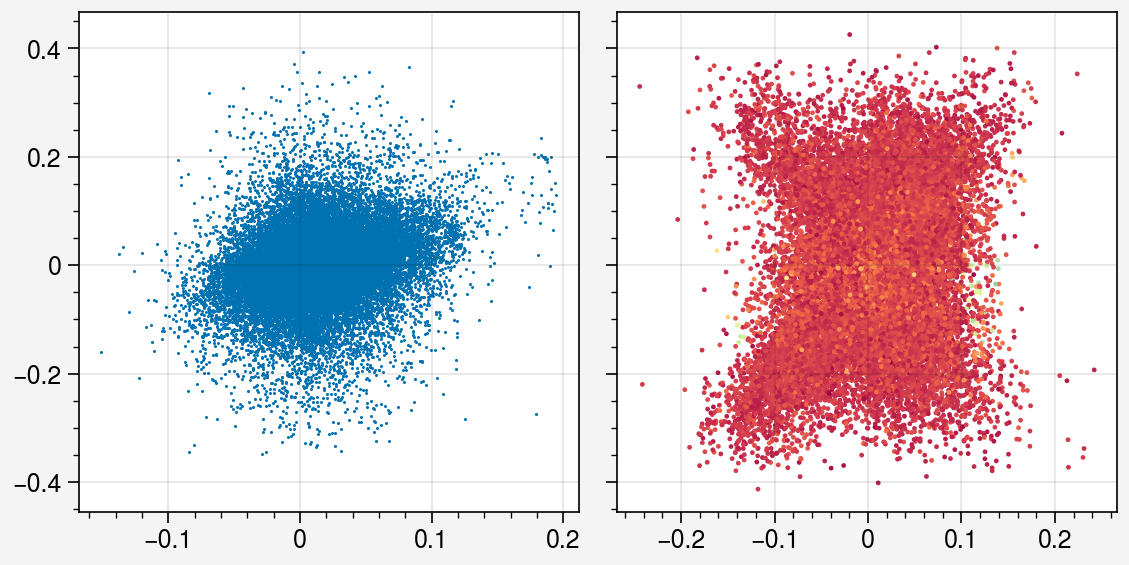

In [308]:
fig, ax = pplt.subplots(ncols=2)
ax[0].scatter(test_df['uT_ice_est'].values, test_df['uT_ice'].values, marker='.', ms=1)
ax[1].scatter(test_df['uL_ice_est'].values, test_df['uL_ice'].values,
              marker='.', ms=5, c=test_df['edge_dist'], cmap='spectral')

In [317]:
test_df['err'] = np.sqrt((test_df['uL_ice_est'] - test_df['uL_ice'])**2 + (test_df['uT_ice_est'] - test_df['uT_ice'])**2)

In [319]:
extremes = test_df.loc[test_df.err > 0.3]

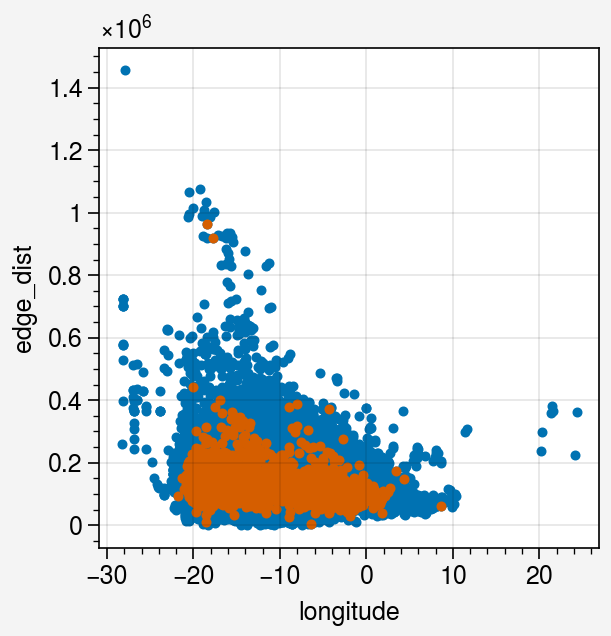

In [322]:
fig, ax = pplt.subplots()
ax.scatter(test_df.longitude, test_df.edge_dist, marker='.')
ax.scatter(extremes.longitude, extremes.edge_dist, marker='.')

In [191]:
%time
n = 1000
bs_n = 10000
# Resampling:
alpha = []
theta = []
for idx in range(bs_n):
    data_samp = data_df.sample(n, replace=True)
    theta.append(np.rad2deg(circmean(np.deg2rad(data_samp['theta']),
                               high=np.pi, low=-np.pi)))
    alpha.append(data_samp['alpha'].median())

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.9 µs


(array([   4.,   33.,  297., 1147., 2517., 3035., 2059.,  738.,  144.,
          26.]),
 array([34.09980967, 37.14513454, 40.19045942, 43.23578429, 46.28110917,
        49.32643404, 52.37175892, 55.41708379, 58.46240867, 61.50773354,
        64.55305842]),
 <BarContainer object of 10 artists>)

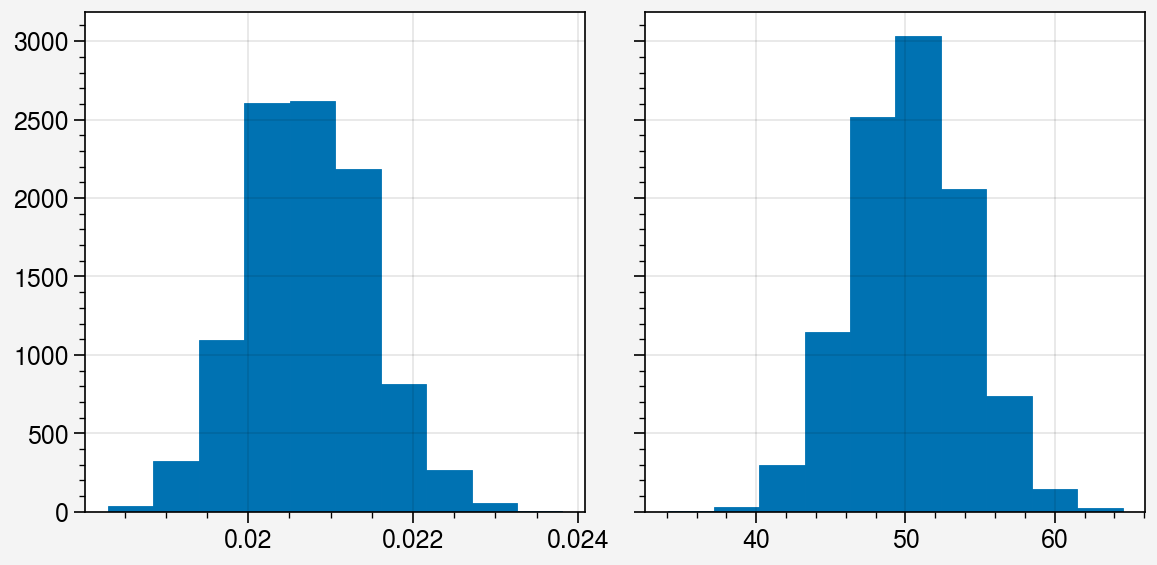

In [192]:
fig, ax = pplt.subplots(ncols=2)
ax[0].hist(alpha)
ax[1].hist(theta)

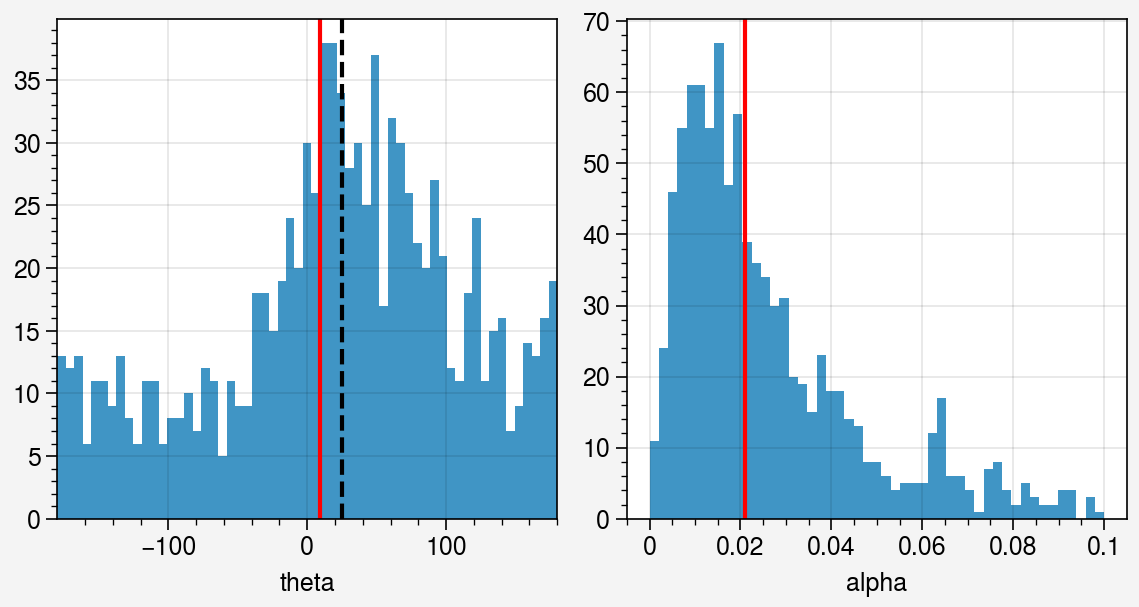

In [194]:
from scipy.stats import circmean
fig, axs = pplt.subplots(ncols=2, share=False)
pdf = axs[0].hist(data_samp['theta'], bins=np.linspace(-180, 180, 60), alpha=0.75)
axs[0].axvline(pdf[1][pdf[0].argmax()], color='r')
axs[0].axvline(25, color='k', ls='--')
axs[0].format(xlim=(-180, 180))
_ = axs[1].hist(data_samp['alpha'], bins=np.linspace(0, 0.1, 50), alpha=0.75)
axs[1].axvline(np.median(data_samp['alpha']), color='r')

For each random sample, we find the value of theta that minimizes the square error $\hat U - u_{ice}$.

In [173]:
alpha = 0.01
theta = np.linspace(10, 70, 100)
mse = []
for th in theta:
    u_est= alpha*np.exp(-1j*np.deg2rad(th))*uw
    mse.append(np.mean(np.abs(u_est - up)**2))

In [186]:
%%time
n = 1000
bs_n = 1000
alpha = 0.01
theta = np.linspace(10, 70, 100)
results_mse = []
for idx in range(bs_n):
    mse = []
    idx = df_filtered.sample(n).index
    for th in theta:
        u_est= alpha*np.exp(-1j*np.deg2rad(th))*uw[idx]
        mse.append(np.mean(np.abs(u_est - up[idx])**2))
    theta_min = theta[np.array(mse).argmin()]
    results_mse.append(theta_min)

CPU times: user 2min 35s, sys: 1.5 s, total: 2min 36s
Wall time: 2min 49s


(array([ 19.,  47., 148., 169., 195., 241.,  94.,  67.,  13.,   7.]),
 array([39.09090909, 40.54545455, 42.        , 43.45454545, 44.90909091,
        46.36363636, 47.81818182, 49.27272727, 50.72727273, 52.18181818,
        53.63636364]),
 <BarContainer object of 10 artists>)

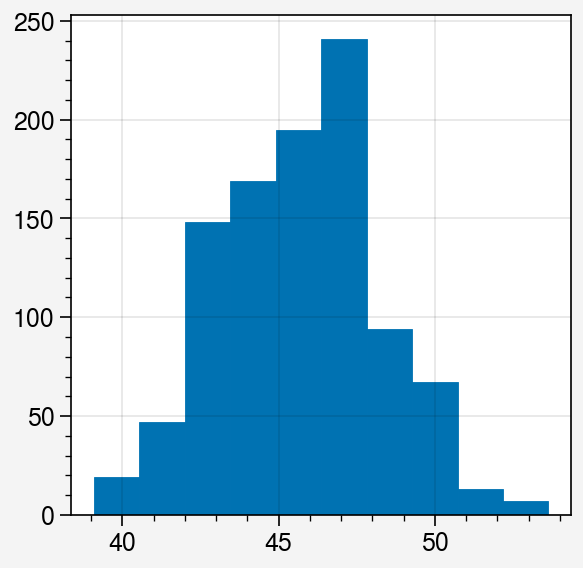

In [187]:
fig, ax = pplt.subplots()
ax.hist(results_mse)

Error is actually minimized for a turning angle of 46 degrees. This doesn't seem right. Are we getting the right wind speeds here?

In [206]:
df_long = df_filtered.groupby('floe_id').filter(lambda x: len(x) > 6)
floes_long = {f: g for f, g in df_long.groupby('floe_id')}


Double check the velocity components - do they actually make sense? Are my velocity directions consistent? Why is it that 45 degrees minimizes error, but the mode is at about 25?

What direction should the arrows be pointing compared to spatial locations?

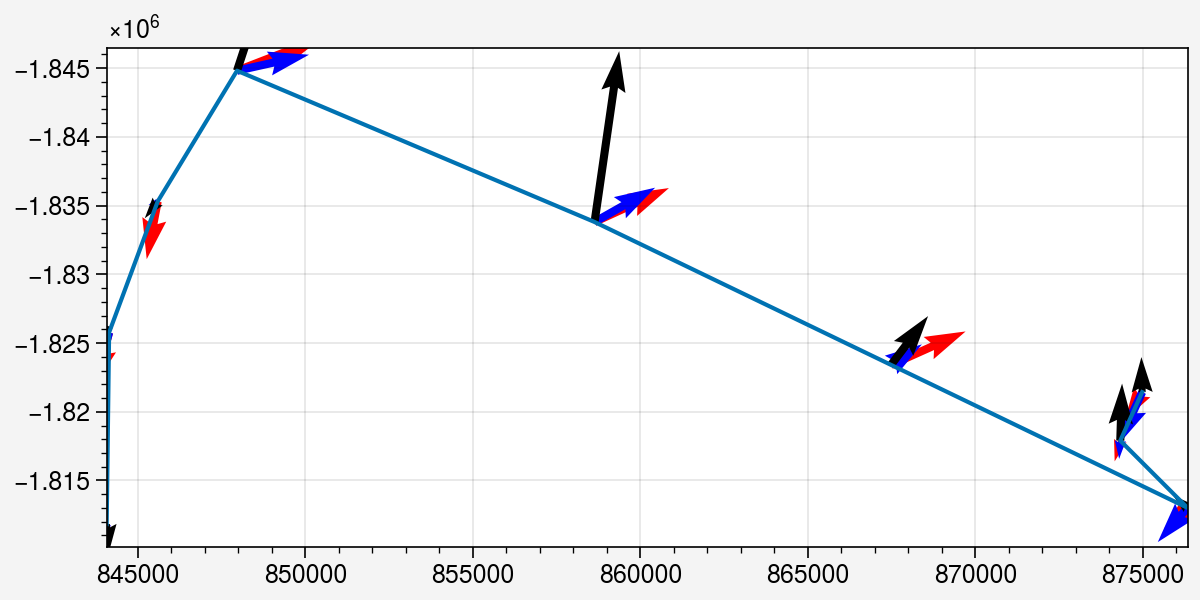

In [283]:
fig, ax = pplt.subplots(width=6, height=3)
group = floes_long['2003_00452']
ax.plot(group.x_stere.values, group.y_stere.values)
ax.quiver(group.x_stere.values, group.y_stere.values, group.u.values, group.v.values, color='r')
ax.quiver(group.x_stere.values, group.y_stere.values, group.u_nsidc.values, group.v_nsidc.values, color='b')
ax.quiver(group.x_stere.values, group.y_stere.values, group.u_wind.values, group.v_wind.values)

# Updated velocity analysis

5D U_along 8.315 cm/s
Fitted exponential dist. scale param: 0.75
5D U_fluctuating 6.445 cm/s
Fitted exponential dist. scale param: 0.73


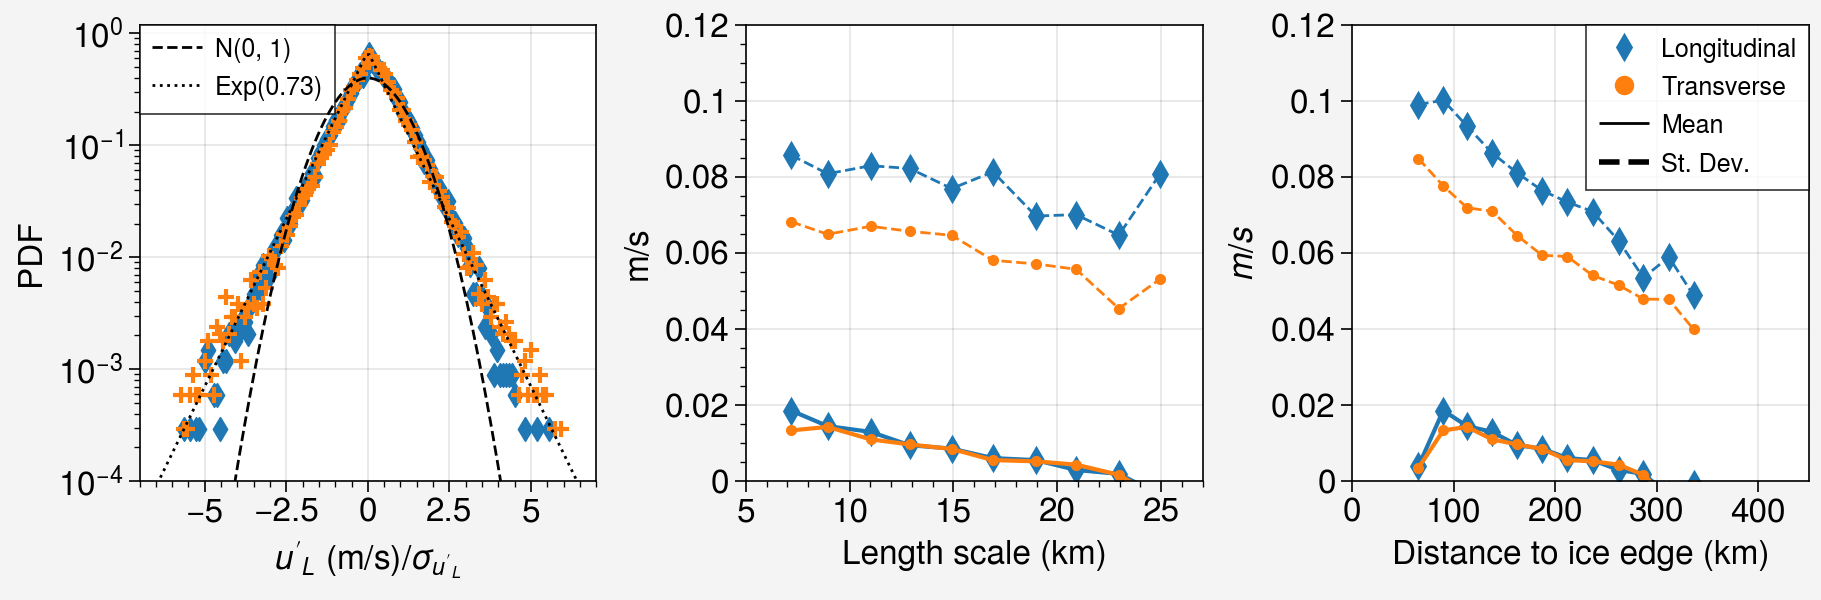

In [68]:
import cartopy.crs as ccrs
import numpy as np
import os
import pandas as pd
import ultraplot as pplt
import pyproj
import scipy.stats as stats
from scipy.interpolate import interp2d
import sys
import warnings

sys.path.append('../scripts/')
from drifter import compute_along_across_components


pplt.rc.reso = 'med'
pplt.rc['cartopy.circular'] = False

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

df_ift = pd.read_csv('../data/floe_tracker/ift_floe_trajectories.csv', index_col=0)
df_ift['datetime'] = pd.to_datetime(df_ift['datetime'].values)

# Calculations
# Length scale bins need area adjustment
df_ift['area_adj_km2'] = (np.sqrt(df_ift.area) + 8)**2*.25*.25 # 6 pixel shift minimizes error against manual

edge_bins = np.arange(0, 800, 25)
df_ift['edge_bin'] = np.digitize(df_ift.edge_dist_km, bins=edge_bins)

length_bins = np.arange(0, 50, 2)
df_ift['length_scale'] = df_ift['area_adj_km2']**0.5
df_ift['length_bin'] = np.digitize(df_ift.length_scale, bins=length_bins)

# Compute anomaly relative to the NSIDC data
tau = '5D'
comp = df_ift.copy()
comp['u'] = comp['u'] - comp['u_nsidc']
comp['v'] = comp['v'] - comp['v_nsidc']
df_comp = compute_along_across_components(comp, uvar='u', vvar='v',
                                    umean='u' + tau + '_nsidc',
                                    vmean='u' + tau + '_nsidc')

length_bins = np.arange(0, 50, 2)

df_edge = pd.concat({'sigma_ut': df_comp[['edge_bin', 'U_fluctuating']].groupby('edge_bin').std(),
                      'sigma_ul': df_comp[['edge_bin', 'U_along']].groupby('edge_bin').std(),
                     'mean_ut': df_comp[['edge_bin', 'U_fluctuating']].groupby('edge_bin').mean(),
                      'mean_ul': df_comp[['edge_bin', 'U_along']].groupby('edge_bin').mean(),
              'n': df_comp[['edge_bin', 'U_fluctuating']].groupby('edge_bin').count(),
             'd': df_comp[['edge_bin', 'edge_dist_km']].groupby('edge_bin').mean()}, axis=1)
df_edge.columns = pd.Index(['sigma_ut', 'sigma_ul', 'mean_ut', 'mean_ul',  'n', 'd'])

df_lscale = pd.concat({'sigma_ut': df_comp[['length_bin', 'U_fluctuating']].groupby('length_bin').std(),
                      'sigma_ul': df_comp[['length_bin', 'U_along']].groupby('length_bin').std(),
                      'mean_ut': df_comp[['edge_bin', 'U_fluctuating']].groupby('edge_bin').mean(),
                      'mean_ul': df_comp[['edge_bin', 'U_along']].groupby('edge_bin').mean(),
              'n': df_comp[['length_bin', 'U_fluctuating']].groupby('length_bin').count(),
             'L': df_comp[['length_bin', 'length_scale']].groupby('length_bin').mean()}, axis=1)
df_lscale.columns = pd.Index(['sigma_ut', 'sigma_ul', 'mean_ut', 'mean_ul', 'n', 'L'])

normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)

## Directional anomalies
sigma = 1
normal_dist = lambda x: 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2 * (x/sigma)**2)

fig, axs = pplt.subplots(height=3, nrows=1, ncols=3, share=False)
x_bins = np.linspace(-0.6, 0.6, 51)
tau = '5D'
# df_rot_ift = compute_along_across_components(df_ift.copy(), uvar='u', vvar='v',
#                                     umean='u' + tau + '_nsidc',
#                                     vmean='u' + tau + '_nsidc')
# df_rot_nsidc = compute_along_across_components(df_ift.drop(['u', 'v'], axis=1).rename({'u_nsidc': 'u', 'v_nsidc': 'v'}, axis=1), uvar='u', vvar='v',
#                                 umean='u' + tau + '_nsidc',
#                                 vmean='u' + tau + '_nsidc')
comp = df_ift.copy()
comp['u'] = comp['u'] - comp['u5D_nsidc']
comp['v'] = comp['v'] - comp['v5D_nsidc']
df_comp = compute_along_across_components(comp, uvar='u', vvar='v',
                                    umean='u' + tau + '_nsidc',
                                    vmean='u' + tau + '_nsidc')

#### Fluctuating Velocity Distributions
ax = axs[0]
for symb, c, var in zip(['d', '+'], ['tab:blue', 'tab:orange'], ['U_along', 'U_fluctuating']):
    ustd = df_comp[var].std()
    u = df_comp[var]
    print(tau, var, np.round(ustd*100, 3), 'cm/s')   
    pdf, x_bins = np.histogram(u/ustd, bins=np.linspace(-7, 7, 151), density=True)
    x_center = 1/2*(x_bins[1:] + x_bins[:-1])
    if 'along' in var:
        label_pdf = 'N(0, 1)'
    else:
        label_pdf = ''

    ax.scatter(x_center, pdf, marker=symb, zorder=5, color=c, label='') 

    train = df_comp.dropna(subset=var).sample(1000, replace=False)
    test = df_comp.dropna(subset=var)
    test = test.loc[[x for x in test.index if x not in train.index]]
    abs_u_train = np.abs(train[var])/np.std(train[var])
    abs_u_test = np.abs(test[var])/np.std(test[var])
    exp_loc, exp_scale = stats.expon.fit(abs_u_train, floc=0)
    print('Fitted exponential dist. scale param:', np.round(exp_scale, 2))
    expon_dist = stats.expon(loc=0, scale=exp_scale).pdf
    normal_dist = stats.norm(loc=0, scale=1).pdf
    
ax.plot(x_center, normal_dist(x_center), marker='',
        lw=1, color='k', ls='--', label='N(0, 1)', zorder=10)
ax.plot(x_center, 0.5*expon_dist(np.abs(x_center)), marker='',
        lw=1, color='k', ls=':', label='Exp({s})'.format(s=np.round(exp_scale, 2)), zorder=10)
    
axs[0].format(title='', xlabel='$u\'_L$ (m/s)/$\sigma_{u\'_L}$',
              yscale='log', ylim=(1e-4, 1.2), xlim=(-7, 7),
              yformatter='log', ylabel='PDF')

axs[0].legend(ncols=1, loc='ul')


# Length scale dependence, for length scales with at least 300 observations
idx = df_lscale.n > 300
ax = axs[1]

ax.plot(df_lscale.loc[idx, 'L'].values,
               df_lscale.loc[idx, 'mean_ul'].values, marker='d', color='tab:blue', label='Longitudinal')

ax.plot(df_lscale.loc[idx, 'L'].values,
               df_lscale.loc[idx, 'sigma_ul'].values, marker='d', ls='--', lw=1, color='tab:blue', label='Longitudinal')

ax.plot(df_lscale.loc[idx, 'L'].values,
               df_lscale.loc[idx, 'mean_ut'].values, marker='.', color='tab:orange', label='Transverse')
ax.plot(df_lscale.loc[idx, 'L'].values,
               df_lscale.loc[idx, 'sigma_ut'].values, marker='.', ls='--', lw=1, color='tab:orange', label='Transverse')



ax.format(xlabel='Length scale (km)', ylabel='m/s', title='', ylim=(0, 0.12), xlim=(5, 27), yscale='linear')
# ax.plot([], 

# Edge distance, for edge bins with at least 300 observations
idx = df_edge.n > 300
ax = axs[2]
ax.plot(df_edge.loc[idx, 'd'].values,
               df_edge.loc[idx, 'mean_ul'].values, marker='d', color='tab:blue', label='Longitudinal')

ax.plot(df_edge.loc[idx, 'd'].values,
               df_edge.loc[idx, 'sigma_ul'].values, marker='d', ls='--', lw=1, color='tab:blue', label='Longitudinal')

ax.plot(df_edge.loc[idx, 'd'].values,
               df_edge.loc[idx, 'mean_ut'].values, marker='.', color='tab:orange', label='Transverse')
ax.plot(df_edge.loc[idx, 'd'].values,
               df_edge.loc[idx, 'sigma_ut'].values, marker='.', ls='--', lw=1, color='tab:orange', label='Transverse')


ax.format(ylim=(0, 0.12), ytickminor=False, xtickminor=False, yscale='linear', xlim=(0, 450),
         ylabel='$m/s$', xlabel='Distance to ice edge (km)', fontsize=12)

l = ['Longitudinal', 'Transverse', 'Mean', 'St. Dev.']
h = [ax.plot([],[], marker=m, color=c, lw=lw, ls=ls) for m, c, lw, ls in zip(['d', 'o', '', ''],
                                                           ['tab:blue', 'tab:orange', 'k', 'k'],
                                                                    [0, 0, 1, 2], ['-', '-', '-', '--'])]
# axs[1].legend(h, l, ncols=1, loc='b')
axs[2].legend(h, l, ncols=1, loc='ur')

fig.format(fontsize=12)

fig.save('../figures/figXX_simpler_velocity_dist.png', dpi=300)

# Interpretation of the ice motion statistics.
- Nearly centered at 0 -- this indicates that a portion of the mean flow remains within the fluctuating velocity
- Statistical tests for the fluctuating velocity:
  - Is the dependence distance to the ice edge due to differences in the number of small / large floes?
  - Are the departures of the mean from 0 significant?
  - How does the local sea ice concentration affect the results? Is there a difference between the pack ice and the MIZ?
  - Are the velocity fluctuations correlated with the wind?
    



In [69]:
df_comp.columns

Index(['datetime', 'floe_id', 'longitude', 'latitude', 'x_stere', 'y_stere',
       'area', 'perimeter', 'axis_major_length', 'axis_minor_length',
       'solidity', 'circularity', 'nsidc_sic', 'lr_probability', 'zeta',
       'zeta_est', 'u', 'v', 'bearing', 'speed', 'area_km2', 'perimeter_km',
       'axis_major_length_km', 'axis_minor_length_km', 'edge_dist_km',
       'coast_dist_km', 'u_nsidc', 'v_nsidc', 'u5D_nsidc', 'v5D_nsidc',
       'u15D_nsidc', 'v15D_nsidc', 'u31D_nsidc', 'v31D_nsidc', 'area_adj_km2',
       'edge_bin', 'length_scale', 'length_bin', 'u_along', 'v_along',
       'u_across', 'v_across', 'U_fluctuating', 'U_along'],
      dtype='object')

In [72]:
df_edge = pd.concat({'sigma_ut': df_comp[['edge_bin', 'U_fluctuating']].groupby('edge_bin').std(),
                      'sigma_ul': df_comp[['edge_bin', 'U_along']].groupby('edge_bin').std(),
                     'area_km2': df_comp[['edge_bin', 'area_km2']].groupby('edge_bin').median(),
                      'area_km2_std': df_comp[['edge_bin', 'area_km2']].groupby('edge_bin').std(),
              'n': df_comp[['edge_bin', 'area_km2']].groupby('edge_bin').count(),
             'd': df_comp[['edge_bin', 'edge_dist_km']].groupby('edge_bin').mean()}, axis=1)
df_edge.columns = pd.Index(['sigma_ut', 'sigma_ul', 'area_km2', 'area_km2_std',  'n', 'd'])


<a list of 1 Line2D objects>

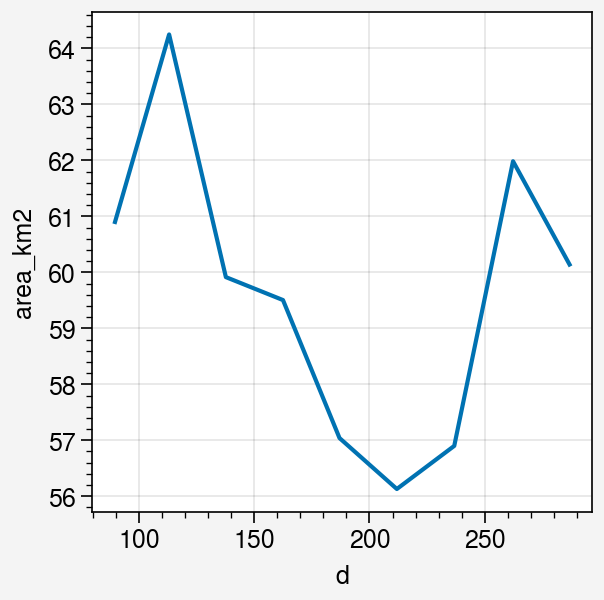

In [74]:
fig, ax = pplt.subplots()
ax.plot(df_edge['d'], df_edge['area_km2'].where(df_edge.n > 1000))

# Some notes to build on 
* This first image is using the NSIDC 5-day mean. This vector also, in a sense, represents the spatial average in that 25-km pixel (and may really represent up to 75 km spatial averaging, depending on where the buoys are).
* We could potentially take Sentinel sea ice motion vectors and do a similar smoothing to make sure the result is robust.
* With the IFT, it will be challenging to find enough data where multiple floes are tracked in the same area.
* Rampal et al. used joint time-space filter windows to estimate the mean current
* The mean perturbation magnitude is actually smaller than the standard deviation. We should use a statistical approach to determine whether the trend is significant. Is there enough data to determine whether there is a seasonal cycle here?
* If we control for the distance to the ice edge, do we still get the length scale dependence? Or is it that the correlation between length scale and distance to the ice edge is imprinted here?

<a list of 1 Line2D objects>

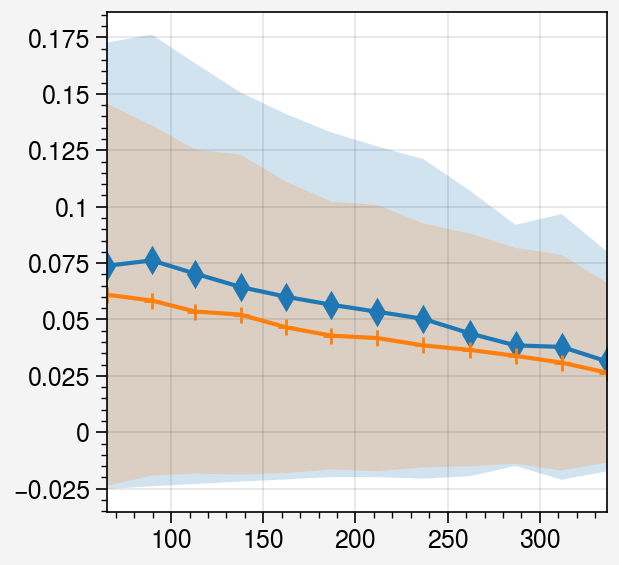

In [232]:
fig, ax = pplt.subplots()
idx = df_edge.n > 300
ax.plot(df_edge.loc[idx, 'd'].values,
               df_edge.loc[idx, 'mean_ul'].values, 
        fadedata = df_edge.loc[idx, 'sigma_ul'].values, 
        marker='d', color='tab:blue', label='Longitudinal')

ax.plot(df_edge.loc[idx, 'd'].values,
               df_edge.loc[idx, 'mean_ut'].values, 
        fadedata = df_edge.loc[idx, 'sigma_ut'].values, 
        marker='+', color='tab:orange', label='Transverse')
